#  <span style="color:cornflowerblue"> Сборный проект - 2. HR-аналитика

<div style="background-color: white; border: 3px solid yellowgreen; border-radius: 10px; padding: 15px 25px; display: inline-block; color: black;">

## Описание проекта 

---

**Заказчик:** HR-отдел компании "Работа с заботой".
    
**Цель:** Оптимизировать управление персоналом через прогнозирование ключевых HR-показателей с помощью машинного обучения.

**Задачи:**

**1.** Разработать модель прогнозирования уровня удовлетворённости сотрудников (SMAPE ≤15)

**2.** Построить модель предсказания увольнения сотрудников (ROC-AUC ≥0.91)

**3.** Провести исследовательский анализ данных и составить портрет "уволившегося сотрудника"

**4.** Создать пайплайны предобработки и подготовки данных для обеих задач

**5.** Проанализировать влияние удовлетворённости на отток персонала

**6.** Предложить рекомендации для бизнеса по снижению рисков внезапных увольнений

---    
    
**Описание данных:**
    
<span style="color:crimson">

- `id` — уникальный идентификатор сотрудника (анкеты);
- `dept` — отдел, в котором работает сотрудник;
- `level` — уровень занимаемой должности;
- `workload` — уровень загруженности сотрудника;
- `employment_years` — длительность работы в компании (в годах);
- `last_year_promo` — показывает, было ли повышение за последний год;
- `last_year_violations` — показывает, нарушал ли сотрудник трудовой договор за последний год;
- `supervisor_evaluation` — оценка качества работы сотрудника, которую дал руководитель;
- `salary` — ежемесячная зарплата сотрудника;
- `job_satisfaction_rate` — уровень удовлетворённости сотрудника работой в компании, целевой признак.

---

<span style="color:yellowgreen"> ДЛЯ ЗАДАЧИ **1**:

-  <span style="color:black">Тренировочная выборка

<span style="color:yellowgreen"> **1.** <span style="color:black">Таблица  `train_satisfaction` 

<span style="color:black">[содержит информацию **о характеристиках сотрудников и их уровне удовлетворённости работой для обучения модели**]

- <span style="color:black"> Входные признаки тестовой выборки
    
<span style="color:yellowgreen"> **2.** <span style="color:black">Таблица `test_features` [содержит информацию **о характеристиках сотрудников без целевого признака для проверки качества модели**]

- <span style="color:black"> Целевой признак тестовой выборки

<span style="color:yellowgreen"> **3.** <span style="color:black">Таблица `test_target_satisfaction` [содержит информацию **об истинных значениях удовлетворённости сотрудников для оценки точности прогноза**]


<span style="color:royalblue"> ДЛЯ ЗАДАЧИ **2**:

-  <span style="color:black">Тренировочная выборка:
  
<span style="color:royalblue"> **1.** <span style="color:black">Таблица `train_quit` [содержит информацию **о характеристиках сотрудников и фактах их увольнения для обучения модели оттока**]

-  <span style="color:black">Входные признаки тестовой выборки те же, что и в задаче 1:

<span style="color:royalblue"> **2.** <span style="color:black">Таблица `test_features` [содержит информацию **о характеристиках сотрудников без целевого признака для прогнозирования риска увольнения**]

-  <span style="color:black"> Целевой признак тестовой выборки:

<span style="color:royalblue"> **3.** <span style="color:black">Таблица `test_target_quit` [содержит информацию **об истинных фактах увольнения сотрудников для оценки качества классификации**]

---

## Импорты

In [1]:
# Установка библиотек
!pip install phik -q
!pip install -q scikit-learn
!pip install -q shap
!pip install -q imblearn

# Необходимые импорты
import pandas as pd
import os
import requests
from io import BytesIO

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shap
from phik import phik_matrix
from scipy.stats import shapiro, normaltest

from sklearn.metrics import make_scorer, roc_auc_score
from sklearn.model_selection import (
                                     train_test_split,
                                     RandomizedSearchCV,
                                     GridSearchCV
                                    )
from sklearn.preprocessing import (
                                   OneHotEncoder,
                                   OrdinalEncoder,
                                   LabelEncoder,
                                   StandardScaler,
                                   MinMaxScaler,
                                   RobustScaler
                                  )
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.ensemble import (
                               HistGradientBoostingRegressor,
                               RandomForestRegressor,
                               HistGradientBoostingClassifier
                              )
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier

from imblearn.over_sampling import SMOTENC
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.pipeline import Pipeline


[notice] A new release of pip is available: 25.3 -> 26.0.1
[notice] To update, run: C:\Users\dns\AppData\Local\Python\pythoncore-3.14-64\python.exe -m pip install --upgrade pip

[notice] A new release of pip is available: 25.3 -> 26.0.1
[notice] To update, run: C:\Users\dns\AppData\Local\Python\pythoncore-3.14-64\python.exe -m pip install --upgrade pip

[notice] A new release of pip is available: 25.3 -> 26.0.1
[notice] To update, run: C:\Users\dns\AppData\Local\Python\pythoncore-3.14-64\python.exe -m pip install --upgrade pip

[notice] A new release of pip is available: 25.3 -> 26.0.1
[notice] To update, run: C:\Users\dns\AppData\Local\Python\pythoncore-3.14-64\python.exe -m pip install --upgrade pip


In [2]:
# Константы
RANDOM_STATE = 42
TEST_SIZE = 0.25

#### <span style="color:royalblue"> Функция. Импорт Google-таблицы

In [3]:
def import_google_sheet(spreadsheet_id, sheet_name=None, local_paths=None):
    '''
    Импортируем Google-таблицу в pandas DataFrame с fallback на локальные файлы
    '''
    
    # Сначала пробуем локальные файлы
    if local_paths:
        for path in local_paths:
            if os.path.exists(path):
                print(f"Загружаем из локального файла: {path}")
                return pd.read_csv(path)
    
    # Если локальных файлов нет, грузим из Google Sheets
    if sheet_name:
        url = f'https://docs.google.com/spreadsheets/d/{spreadsheet_id}/gviz/tq?tqx=out:csv&sheet={sheet_name}'
    else:
        url = f'https://docs.google.com/spreadsheets/d/{spreadsheet_id}/export?format=csv'
    
    print(f"Загружаем из Google Sheets: {url}")
    
    r = requests.get(url)
    r.raise_for_status()
    
    return pd.read_csv(BytesIO(r.content))

#### <span style="color:royalblue">Функция. Общая информация и Первые строки

In [4]:
def head_and_info_display(df, n=5, show_shape=True, show_dtypes=True):
    '''
    Параметры:
    df - DataFrame для анализа
    n - Количество строк
    '''
    print('~' * 23)
    print('ИНФОРМАЦИЯ О ДАТАФРЕЙМЕ')
    print('~' * 23)
    
    # 1. Размер данных
    print(f'Форма данных: {df.shape[0]} строк, {df.shape[1]} столбцов')

    # 2. Названия столбцов
    print(f"\nНАЗВАНИЯ СТОЛБЦОВ ({len(df.columns)} шт.):")
    print("-" * 30)
    for i, col in enumerate(df.columns, 1):
       print(f"{i:2}. {col}")
    
    # 2. Первые n строк
    print(f"\nПервые {n} строк:")
    print("-" * 15)
    display(df.head(n))
    
    # 3. Общая информация
    print(f"\nОбщая информация:")
    print("-" * 17)
    df.info()
    
    # 4. Пропущенные значения
    print(f"\nПРОПУЩЕННЫЕ ЗНАЧЕНИЯ:")
    print("-" * 30)
    
    # Вычисляем количество и процент пропусков по столбцам
    missing_values = df.isnull().sum()
    total_rows = df.shape[0]
    
    # Фильтруем только столбцы с пропусками
    columns_with_missing = missing_values[missing_values > 0]
    
    if len(columns_with_missing) == 0:
        print('Пропущенных значений нет')
    else:
        print(f'Столбцы с пропущенными значениями ({len(columns_with_missing)} из {df.shape[1]}):')
        
        # Создаем DataFrame для красивого отображения
        missing_df = pd.DataFrame({
                                    'Столбец': columns_with_missing.index,
                                    'Кол-во пропусков': columns_with_missing.values,
                                    '% пропусков': (columns_with_missing.values / total_rows * 100).round(2)
                                 })
        display(missing_df)
        
        print(f'Всего пропусков в датафрейме: {missing_values.sum()}')
        print(f'Средний % пропусков: {(missing_values.sum() / (total_rows * df.shape[1]) * 100).round(2)}%')
       
    # 5. Дубликаты строк
    print(f'\nПРОВЕРКА ЯВНЫХ ДУБЛИКАТОВ:')
    print("-" * 20)
    duplicates_count = df.duplicated().sum()
    if duplicates_count == 0:
        print('Дубликатов строк нет')
    else:
        print(f'Найдено {duplicates_count} дубликатов строк ({duplicates_count/total_rows*100:.2f}% данных)') 
        
    # 6. Проверка уникальности id
    if 'id' in df.columns:
        unique_ids = df['id'].nunique()
        total_ids = len(df['id'])
        print(f"\nУникальных ID: {unique_ids}/{total_ids}")

# З А Д А Ч А № 1


<div style="border-left: 3px solid yellowgreen; padding-left: 15px; margin: 15px 0;"> 
    
Предсказание уровня удовлетворённости сотрудника

In [5]:
# 1. Тренировочные данные с целевым признаком удовлетворённости
train_satisfaction = import_google_sheet(
                                        spreadsheet_id='1G1acyQaEDj-Fy2PgbJUWG5qJriykBQno9cG3OX57vQk',  # ID Google таблицы с train_job_satisfaction_rate
                                        local_paths=[
                                                     '/data/train_job_satisfaction_rate.csv',  # серверный путь
                                                     'C:/projects/data/train_job_satisfaction_rate.csv', # Windows путь
                                                     './data/train_job_satisfaction_rate.csv'  # локальный путь
                                                    ]
                                        )
# 2. Тестовые данные (признаки) для проверки модели
test_features = import_google_sheet(
                                    spreadsheet_id='1swW4KlgOoHz0RUI9ZVH78nM3iE5SEyBY9nJm68iG_lU',  # ID Google таблицы с test_features
                                    local_paths=[
                                                 '/data/test_features.csv',
                                                 'C:/projects/data/test_features.csv',
                                                 './data/test_features.csv' 
                                                 ]
                                     )
# 3. Истинные значения удовлетворённости для тестовой выборки
test_target_satisfaction = import_google_sheet(
                                               spreadsheet_id='1rfg_g0a7mpwb31Z3ch4ynPX7vZGRK_MlFpTqkbcsVAw',  # ID Google таблицы с test_target_job_satisfaction_rate
                                               local_paths=[
                                                            '/data/test_target_job_satisfaction_rate.csv',
                                                            'C:/projects/data/test_target_job_satisfaction_rate.csv',
                                                            './data/test_target_job_satisfaction_rate.csv'
                                                           ]
                                                )

Загружаем из Google Sheets: https://docs.google.com/spreadsheets/d/1G1acyQaEDj-Fy2PgbJUWG5qJriykBQno9cG3OX57vQk/export?format=csv
Загружаем из Google Sheets: https://docs.google.com/spreadsheets/d/1swW4KlgOoHz0RUI9ZVH78nM3iE5SEyBY9nJm68iG_lU/export?format=csv
Загружаем из Google Sheets: https://docs.google.com/spreadsheets/d/1rfg_g0a7mpwb31Z3ch4ynPX7vZGRK_MlFpTqkbcsVAw/export?format=csv


In [6]:
# Устанавливаем 'id' как индекс для данных
train_satisfaction.set_index('id', inplace=True)
test_features.set_index('id', inplace=True)
test_target_satisfaction.set_index('id', inplace=True)
# Сортируем тестовые признаки по индексу
test_features = test_features.sort_index()
test_target_satisfaction = test_target_satisfaction.sort_index()

## ш а г  .1. Загрузка данных

### Таблица `train_satisfaction`

In [7]:
head_and_info_display(train_satisfaction)

~~~~~~~~~~~~~~~~~~~~~~~
ИНФОРМАЦИЯ О ДАТАФРЕЙМЕ
~~~~~~~~~~~~~~~~~~~~~~~
Форма данных: 4000 строк, 9 столбцов

НАЗВАНИЯ СТОЛБЦОВ (9 шт.):
------------------------------
 1. dept
 2. level
 3. workload
 4. employment_years
 5. last_year_promo
 6. last_year_violations
 7. supervisor_evaluation
 8. salary
 9. job_satisfaction_rate

Первые 5 строк:
---------------


,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
id,,,,,,,,,
155278,sales,junior,medium,2,no,no,1,24000,0.58
653870,hr,junior,high,2,no,no,5,38400,0.76
184592,sales,junior,low,1,no,no,2,12000,0.11
171431,technology,junior,low,4,no,no,2,18000,0.37
693419,hr,junior,medium,1,no,no,3,22800,0.20



Общая информация:
-----------------
<class 'pandas.core.frame.DataFrame'>
Index: 4000 entries, 155278 to 338347
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   dept                   3994 non-null   object 
 1   level                  3996 non-null   object 
 2   workload               4000 non-null   object 
 3   employment_years       4000 non-null   int64  
 4   last_year_promo        4000 non-null   object 
 5   last_year_violations   4000 non-null   object 
 6   supervisor_evaluation  4000 non-null   int64  
 7   salary                 4000 non-null   int64  
 8   job_satisfaction_rate  4000 non-null   float64
dtypes: float64(1), int64(3), object(5)
memory usage: 312.5+ KB

ПРОПУЩЕННЫЕ ЗНАЧЕНИЯ:
------------------------------
Столбцы с пропущенными значениями (2 из 9):


,Столбец,Кол-во пропусков,% пропусков
0,dept,6,0.15
1,level,4,0.10


Всего пропусков в датафрейме: 10
Средний % пропусков: 0.03%

ПРОВЕРКА ЯВНЫХ ДУБЛИКАТОВ:
--------------------
Найдено 245 дубликатов строк (6.12% данных)


In [8]:
# Дропаем дубликаты
train_satisfaction = train_satisfaction.drop_duplicates()
train_satisfaction.shape

(3755, 9)

<div style="background-color: white; border: 2px solid yellowgreen; border-radius: 0px; padding: 15px 25px; display: inline-block; color: black;">

<span style="color:royalblue">ПРЕДВАРИТЕЛЬНАЯ ОЦЕНКА ДАННЫХ 

<span style="color:crimson">
    
- <span style="color:black">Есть пропущенные значения (0.03%), типы данных верные;
- <span style="color:black">Обнаружены явные дубликаты (6.12%) - удалили;
- <span style="color:black">В таблице `train_satisfaction` 3755 строк и 9 столбцов.

### Таблица `test_features`

In [9]:
head_and_info_display(test_features)

~~~~~~~~~~~~~~~~~~~~~~~
ИНФОРМАЦИЯ О ДАТАФРЕЙМЕ
~~~~~~~~~~~~~~~~~~~~~~~
Форма данных: 2000 строк, 8 столбцов

НАЗВАНИЯ СТОЛБЦОВ (8 шт.):
------------------------------
 1. dept
 2. level
 3. workload
 4. employment_years
 5. last_year_promo
 6. last_year_violations
 7. supervisor_evaluation
 8. salary

Первые 5 строк:
---------------


,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
id,,,,,,,,
100298,hr,junior,low,2,no,no,4,19200
100480,marketing,junior,low,4,no,no,4,16800
100503,purchasing,middle,high,5,no,no,4,55200
100610,sales,middle,medium,5,no,no,4,43200
100692,sales,middle,high,6,no,no,4,48000



Общая информация:
-----------------
<class 'pandas.core.frame.DataFrame'>
Index: 2000 entries, 100298 to 999029
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   dept                   1997 non-null   object
 1   level                  1999 non-null   object
 2   workload               1999 non-null   object
 3   employment_years       2000 non-null   int64 
 4   last_year_promo        2000 non-null   object
 5   last_year_violations   2000 non-null   object
 6   supervisor_evaluation  2000 non-null   int64 
 7   salary                 2000 non-null   int64 
dtypes: int64(3), object(5)
memory usage: 140.6+ KB

ПРОПУЩЕННЫЕ ЗНАЧЕНИЯ:
------------------------------
Столбцы с пропущенными значениями (3 из 8):


,Столбец,Кол-во пропусков,% пропусков
0,dept,3,0.15
1,level,1,0.05
2,workload,1,0.05


Всего пропусков в датафрейме: 5
Средний % пропусков: 0.03%

ПРОВЕРКА ЯВНЫХ ДУБЛИКАТОВ:
--------------------
Найдено 557 дубликатов строк (27.85% данных)


<div style="background-color: white; border: 2px solid yellowgreen; border-radius: 0px; padding: 15px 25px; display: inline-block; color: black;">

<span style="color:royalblue">ПРЕДВАРИТЕЛЬНАЯ ОЦЕНКА ДАННЫХ 

<span style="color:crimson">

- <span style="color:black">В таблице `test_features` 2000 строк и 8 столбцов;
- <span style="color:black">Есть пропущенные значения (0.03%), типы данных верные;
- <span style="color:black">Обнаружены явные дубликаты (27.85%)- оставим их, они никак не повлияют на обучение модели.


### Таблица `test_target_satisfaction`

In [10]:
head_and_info_display(test_target_satisfaction)

~~~~~~~~~~~~~~~~~~~~~~~
ИНФОРМАЦИЯ О ДАТАФРЕЙМЕ
~~~~~~~~~~~~~~~~~~~~~~~
Форма данных: 2000 строк, 1 столбцов

НАЗВАНИЯ СТОЛБЦОВ (1 шт.):
------------------------------
 1. job_satisfaction_rate

Первые 5 строк:
---------------


,job_satisfaction_rate
id,
100298,0.80
100480,0.84
100503,0.79
100610,0.75
100692,0.69



Общая информация:
-----------------
<class 'pandas.core.frame.DataFrame'>
Index: 2000 entries, 100298 to 999029
Data columns (total 1 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   job_satisfaction_rate  2000 non-null   float64
dtypes: float64(1)
memory usage: 31.2 KB

ПРОПУЩЕННЫЕ ЗНАЧЕНИЯ:
------------------------------
Пропущенных значений нет

ПРОВЕРКА ЯВНЫХ ДУБЛИКАТОВ:
--------------------
Найдено 1902 дубликатов строк (95.10% данных)


<div style="background-color: white; border: 2px solid yellowgreen; border-radius: 0px; padding: 15px 25px; display: inline-block; color: black;">

<span style="color:royalblue">ПРЕДВАРИТЕЛЬНАЯ ОЦЕНКА ДАННЫХ 

<span style="color:crimson">
    
- <span style="color:black">В таблице `test_target_satisfaction` 2000 строк и 1 столбц.
- <span style="color:black">Нет пропущенных значений, типы данных верные
- <span style="color:black">Хотя и обнаружены явные дубликаты, но по факту - дубликатов нет (естественно, что в целевом признаке будут одинаковые значения).

<div style="background-color: white; border: 1.5px solid crimson; border-radius: 10px; padding: 15px 25px; display: inline-block; color: black;">

---

### Вывод

<span style="color:cornflowerblue"> В ДАННОМ РАЗДЕЛЕ МЫ ЗНАКОМИЛИСЬ С ДАННЫМИ И ПЕРВИЧНО ИХ ОЦЕНИЛИ.

---    

<span style="color:cornflowerblue"> **.1.** <span style="color:black">Устанавили `id` как индекс для данных и отсортировали тестовые признаки по индексу.
    
<span style="color:cornflowerblue"> **.2.** <span style="color:black">Создали функцию для быстрого первичного анализа структуры и содержимого датафреймов.

<span style="color:crimson">
  
- <span style="color:black">  В таблице `train_satisfaction` 3755 записей и 9 столбцов.

 1. <span style="color:black">  Удалили дубликаты(6.12%). 
 2. <span style="color:black">  Типы данных верные. 
 3. <span style="color:black">  Пропуски(0.03%) обработаем в пайплайне.
    
- <span style="color:black">  В таблице `test_features` 2000 записей и 8 столбцов.

 1. <span style="color:black">  Найдены дубликаты (27.85%) - оставили.
 2. <span style="color:black">  Типы данных верные. 
 3. <span style="color:black">  Пропуски(0.03%) обработаем в пайплайне.

- <span style="color:black">  В таблице `test_target_satisfaction` 2000 записей и 1 столбец.

1. <span style="color:black">  Типы данных верные.
2. <span style="color:black">  Нет пропущенных значений.

---
    
<span style="color:cornflowerblue">ДАЛЕЕ ПРОВЕДЁМ ПРЕДОРАБОТКУ ДАННЫХ: 

- <span style="color:black">  Проверим данные на неявные дубликаты и некорректные значения

- <span style="color:black">  Работу с пропусками проведем в пайплайне

## ш а г  .2. Предобработка данных

### Работа с неявными дубликатами

#### <span style="color:royalblue"> Функция. Вывод уникальных значений

In [11]:
def show_unique_simple(**tables):
    ''' Для вывода уникальных значений таблиц с категориальными столбцами'''
    for name, df in tables.items():
        print(f'\n--- {name} ---')
        for col in df.select_dtypes(include=['object']).columns:
            print(f'{col}: {list(df[col].unique())}')

In [12]:
# Выявляем
show_unique_simple(train_satisfaction=train_satisfaction, test_features=test_features)


--- train_satisfaction ---
dept: ['sales', 'hr', 'technology', 'purchasing', 'marketing', nan]
level: ['junior', 'middle', 'sinior', nan]
workload: ['medium', 'high', 'low']
last_year_promo: ['no', 'yes']
last_year_violations: ['no', 'yes']

--- test_features ---
dept: ['hr', 'marketing', 'purchasing', 'sales', 'technology', nan]
level: ['junior', 'middle', 'sinior', nan]
workload: ['low', 'high', 'medium', nan]
last_year_promo: ['no', 'yes']
last_year_violations: ['no', 'yes']


In [13]:
# Заменяем некорректные значения
train_satisfaction['level'] = train_satisfaction['level'].str.replace('sinior', 'senior')
test_features['level'] = test_features['level'].str.replace('sinior', 'senior')

In [14]:
# Проверочка
show_unique_simple(train_satisfaction=train_satisfaction, test_features=test_features)


--- train_satisfaction ---
dept: ['sales', 'hr', 'technology', 'purchasing', 'marketing', nan]
level: ['junior', 'middle', 'senior', nan]
workload: ['medium', 'high', 'low']
last_year_promo: ['no', 'yes']
last_year_violations: ['no', 'yes']

--- test_features ---
dept: ['hr', 'marketing', 'purchasing', 'sales', 'technology', nan]
level: ['junior', 'middle', 'senior', nan]
workload: ['low', 'high', 'medium', nan]
last_year_promo: ['no', 'yes']
last_year_violations: ['no', 'yes']


### Работа с явными дубликатами

#### <span style="color:royalblue"> Функция. Кол-во дубликатов для нескольких таблиц

In [15]:
def cnt_duplicates(**tables):
    '''Отображает кол-во дублей для нескольких таблиц'''    
    for name, df in tables.items():
        duplicates = df.duplicated().sum()
        print(f'{name}: Кол-во дублей: {duplicates}')

In [16]:
cnt_duplicates(train_satisfaction=train_satisfaction, test_features=test_features, test_target_satisfaction=test_target_satisfaction)

train_satisfaction: Кол-во дублей: 0
test_features: Кол-во дублей: 557
test_target_satisfaction: Кол-во дублей: 1902


<div style="background-color: white; border: 1.5px solid crimson; border-radius: 10px; padding: 15px 25px; display: inline-block; color: black;">

---

### Вывод

<span style="color:cornflowerblue"> В ДАННОМ РАЗДЕЛЕ МЫ ПРОВЕЛИ ПЕРВИЧНЫЕ АНАЛИЗ И ПОЗНАКОМИЛИСЬ С ДАННЫМИ ПОБЛИЖЕ.

---

<span style="color:crimson">
  
<span style="color:black">  В таблицах `train_satisfaction`, `test_features`, `test_target_satisfaction`:

- <span style="color:black">  Неявных дубликатов **не обнаружено**
- <span style="color:black">  Устранили некорректные значения в столбцах `level` - поменяли `sinior` на `senior`
- <span style="color:black">  Сделали повторную проверку явных дубликатов новых дубликатов после замены некорректных значений **не обнаружено**. А в тестовых данных дубли не трогаем.

---
    
<span style="color:cornflowerblue"> ДАЛЕЕ ПРИСТУПИМ К ИССЛЕДОВАТЕЛЬСКОМУ АНАЛИЗУ ДАННЫХ

- <span style="color:black">   Разделим данные на колличесвенные и качественные, посмотрим на распределения значений в данных, построив графики для каждого признака.
    
    - <span style="color:black">  Для количественных признаков мы построим: "Ящик с усами" и Гистограмму.
    - <span style="color:black">  Для категориальных признаков мы построим: Столбчатую и круговую диаграммы.

## ш а г  .3. Исследовательский анализ данных

---

<span style="color:cornflowerblue">
    
- <span style="color:black">Таблица `train_satisfaction` - это тренировочные данные для модели прогнозирования уровня удовлетворённости сотрудников
- <span style="color:black">Таблица `test_features` - это входные признаки тестовой выборки без целнвого признака
- <span style="color:black">Таблица `test_target_satisfaction` - это целевой признак тестовой выборки

<span style="color:black">Таким образом, в первую очередь нам интересны **пропорциональность** данных в выборках и **распределение**. Также обратим внимание на **дисбаланс** классов.

---

### I Статистика и графики распределений для категориальных и дискретных значений

#### <span style="color:royalblue"> Функция. Столбчатая и Круговая диаграммы

In [17]:
# Функция для быстрого отображения категориальных признаков с двумя графиками и симпатичной цветовой палитрой
def plot_categorical(df, column, figsize=(15, 8), palette='Paired'):
    
    '''Столбчатая и круговая диаграмма'''
    
    # Подсчитываем кол-во уникальных значений
    value_counts = df[column].value_counts()
    
    # Создаем две диаграммы
    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, # 1 ряд, 2 графика в ряд
                                   figsize=figsize)
    # fig управляет всей областью отрисовки
    # ax1 - левый график (первый столбец)
    # ax2 - правый график (второй столбец)  
    
    # 1. Столбчатая диаграмма
    sns.countplot(data=df, # Указываем, откуда брать данные для построения графика
                  x=column, # Указываем, какой столбец использовать для оси X
                  hue=column,  # Раскрашиваем столбцы по тому же столбцу
                  legend=False,  # Отключаем  дублирующую легенду
                  palette=palette, # Задаем цветовую схему для столбцов
                  ax=ax1 # Указываем, в какой области рисовать график
                  )
    ax1.set_title(f'Распределение по {column}', fontsize=14)
    ax1.set_xlabel(column) #Подпись дляя оси х на графике ах1
    ax1.set_ylabel('Кол-во')
    # Поворачиваем подписи и выравниваем вправо
    plt.setp(ax1.get_xticklabels(), rotation=45, ha='right')
    
    # Добавляем числа на столбцы
    for p in ax1.patches: # Цикл по каждому столбцу на графике
        ax1.annotate(f'{p.get_height()}', #добавляем текстовую аннотацию на график
                    (p.get_x() + p.get_width()/2, p.get_height()),
                    ha='center',# Горизонтальное выравнивание по центру
                    va='bottom', # Вертикальное выравнивание по низу (текст над столбцом)
                    fontweight='bold')
    #p.get_x() - координата X левого края столбца
    #get_width()/2 - половина ширины столбца
    #p.get_height() - координата Y верхнего края столбца
    
    # 2. Круговая диаграмма
    colors = sns.color_palette(palette, 
                               len(value_counts)#количество цветов (по числу категорий)
                               )
    ax2.pie(value_counts.values,#кол-во
            labels=value_counts.index,#название категорий 
            autopct='%1.1f%%', #отображение процентов
            colors=colors, #цвета секторов
            startangle=90) #начальный угол
    ax2.set_title(f'Доли категорий {column}', 
                  fontsize=14)
    
    print(f"Статистика для '{column}':")
    print(f"Всего записей: {len(df)}")
    print(f"Уникальных категорий: {df[column].nunique()}")
    print(f"Самая частая категория: '{value_counts.index[0]}' ({value_counts.iloc[0]} записей)")
    print(f"Доля самой частой категории: {value_counts.iloc[0]/len(df)*100:.1f}%")

#### <span style="color:royalblue"> Функция. Вывод столбцов с категориальными и дискретными значениями

In [18]:
def get_column_types(df, threshold=11):
    '''
    Возвращает типы столбцов с учетом порога уникальности для дискретных значений
    '''
    # Категориальные
    categorical = df.select_dtypes(include=['object']).columns.tolist()
    
    # Дискретные количественные (int с малым количеством уникальных значений)
    discrete = []
    for col in df.select_dtypes(include=['int64', 'int32']).columns:
        if df[col].nunique() < threshold:
            discrete.append(col)    
    return categorical, discrete

### Таблица `train_satisfaction`

In [19]:
# Выводим Категориальные и Дискретные количественные столбцы таблицы 'train_satisfaction'
cat_cols, disc_cols = get_column_types(train_satisfaction)
print(f'Категориальные: {cat_cols}')
print(f'Дискретные количественные (>11 уникальных): {disc_cols}')

Категориальные: ['dept', 'level', 'workload', 'last_year_promo', 'last_year_violations']
Дискретные количественные (>11 уникальных): ['employment_years', 'supervisor_evaluation']


<div style="border-left: 3px solid yellowgreen; padding-left: 15px; margin: 15px 0;"> 

#### dept `[отдел, в котором работает сотрудник]`

Статистика для 'dept':
Всего записей: 3755
Уникальных категорий: 5
Самая частая категория: 'sales' (1374 записей)
Доля самой частой категории: 36.6%


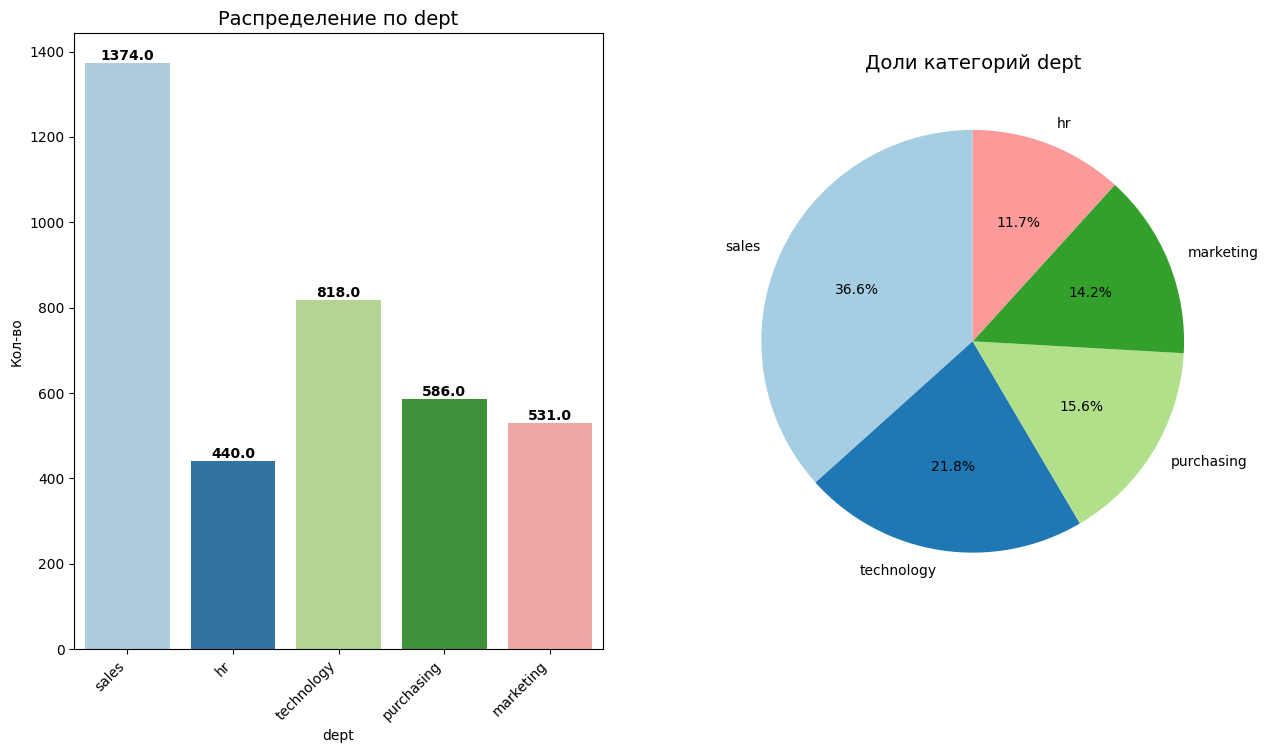

In [20]:
# Столбец 'dept'
plot_categorical(train_satisfaction, column='dept')

<div style="background-color: white; border: 2px solid yellowgreen; border-radius: 0px; padding: 15px 25px; display: inline-block; color: black;">

По графику распределения категории `dept` видим, что большая часть компании в данной таблице - это сотрудники отдела `sales` (1374 записей, доля 36.6%). Уникальных 

<span style="color:crimson">

- <span style="color:black">Уникальных категорий: `5`
- <span style="color:black">В топ-3 также входят `technology` (21.8%) и `purchasing` (15.6%).

<span style="color:black"> **Структура компании** имеет явную ориентацию на продажи (`sales` более трети штата), что логично для коммерческой организации. При этом технологическое подразделение занимает второе место по численности (21.8%), что свидетельствует о значимости IT-инфраструктуры. Наименьшую долю имеет HR-отдел (11.7%)

<div style="border-left: 3px solid yellowgreen; padding-left: 15px; margin: 15px 0;"> 

#### level `[уровень занимаемой должности]`

Статистика для 'level':
Всего записей: 3755
Уникальных категорий: 3
Самая частая категория: 'junior' (1699 записей)
Доля самой частой категории: 45.2%


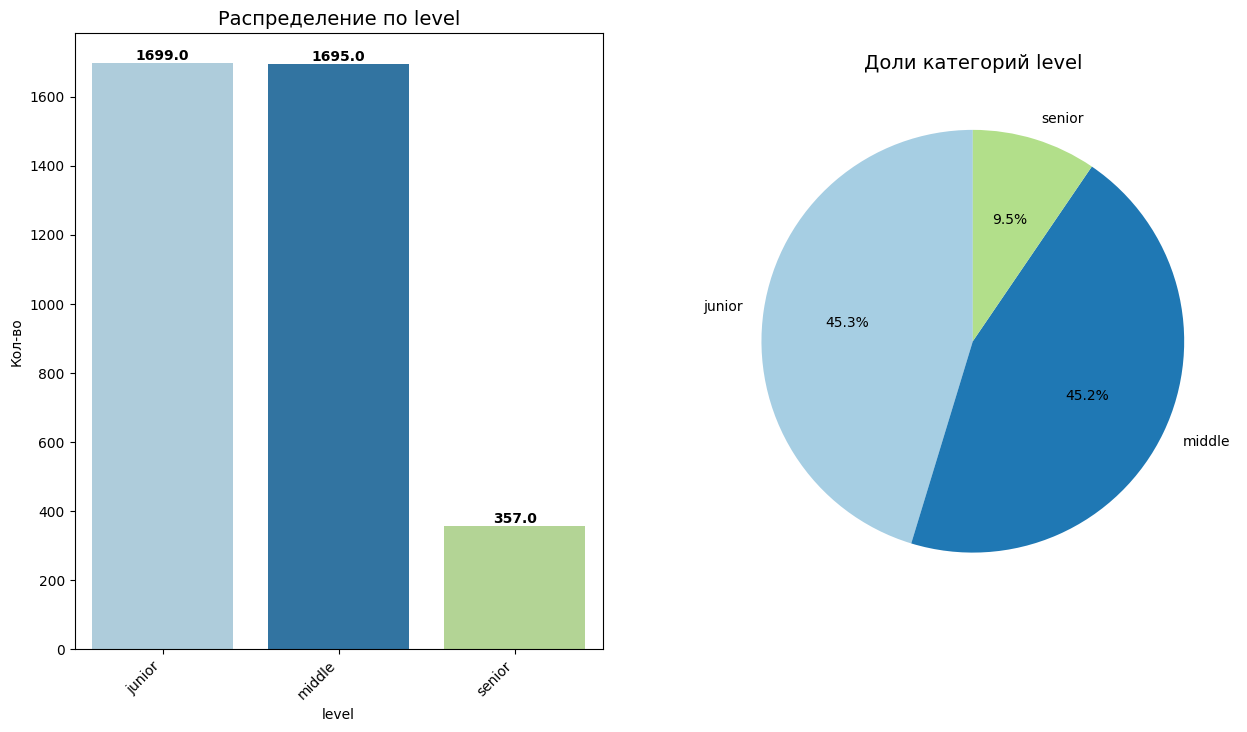

In [21]:
# Столбец 'level'
plot_categorical(train_satisfaction, column='level')

<div style="background-color: white; border: 2px solid yellowgreen; border-radius: 0px; padding: 15px 25px; display: inline-block; color: black;">

По графику распределения категории `level` видим, что большая часть сотрудников в компании - это сотрудники с уровнем `junior` (1699 записей, доля 45.3%) и `middle` (1695 записей, доля 45.2%).

Дефицит `senior`: Всего 9.5% руководителей/экспертов может указывать на:

<span style="color:crimson">
    
- <span style="color:black">Молодую компанию;
- <span style="color:black">Высокую текучку на `senior` позициях (Низкая доля `senior` может ограничивать менторство и развитие `junior`/`middle`).

---

<span style="color:black">Стоит проанализировать удовлетворённость по уровням - возможно, `senior` перегружены, а `junior` нуждаются в большем руководстве.

<div style="border-left: 3px solid yellowgreen; padding-left: 15px; margin: 15px 0;"> 

#### workload `[уровень загруженности сотрудника]`

Статистика для 'workload':
Всего записей: 3755
Уникальных категорий: 3
Самая частая категория: 'medium' (1908 записей)
Доля самой частой категории: 50.8%


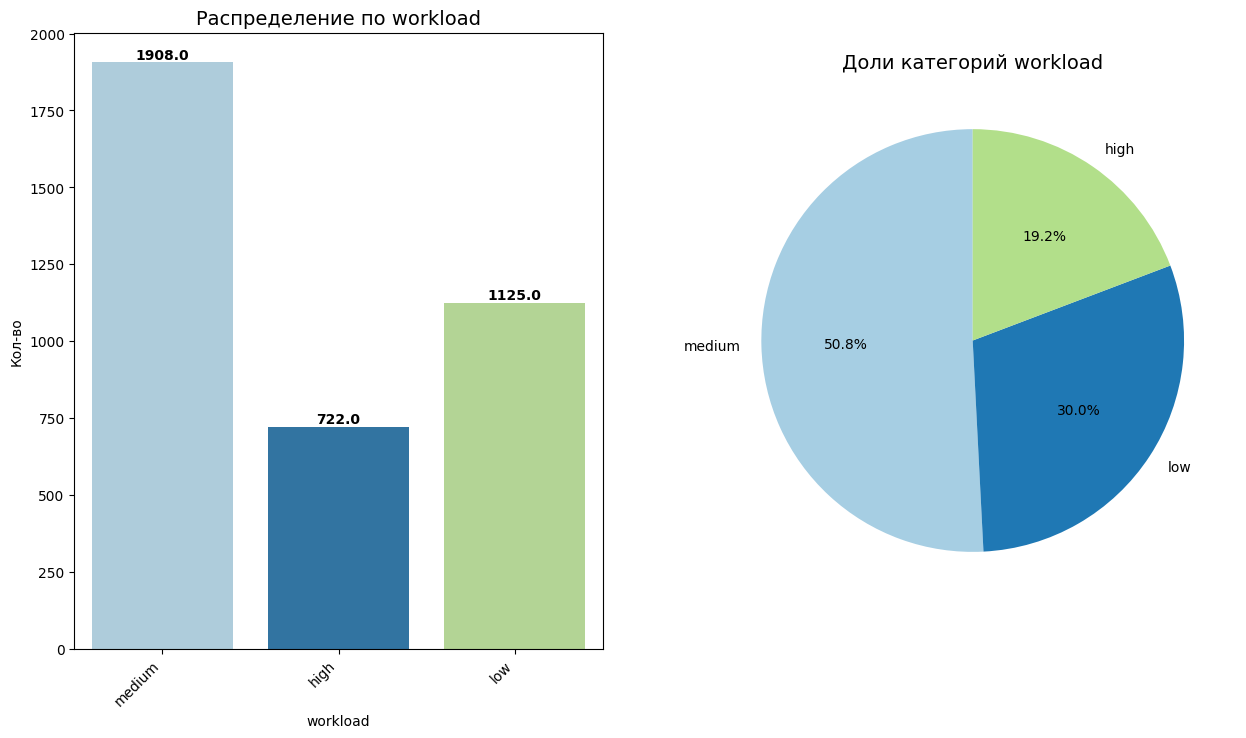

In [22]:
# Столбец 'workload'
plot_categorical(train_satisfaction, column='workload')

<div style="background-color: white; border: 2px solid yellowgreen; border-radius: 0px; padding: 15px 25px; display: inline-block; color: black;">

По графику распределения категории `workload` видим, что уровень загруженности сотрудников в основном средний - `medium` (1908 записей, доля 50.8%).

<span style="color:crimson">

- <span style="color:black">`low` 30% сотрудников с низкой нагрузкой (могут взять дополнительные задачи)
- <span style="color:black">`high` 12.2% с высокой нагрузкой (риск выгорания)

--- 

<span style="color:black">Признак `workload` может быть значимым прогностическим фактором удовлетворённости, особенно для категорий `high` и `low`.

<div style="border-left: 3px solid yellowgreen; padding-left: 15px; margin: 15px 0;"> 

#### last_year_promo `[было ли повышение за последний год]`

Статистика для 'last_year_promo':
Всего записей: 3755
Уникальных категорий: 2
Самая частая категория: 'no' (3635 записей)
Доля самой частой категории: 96.8%


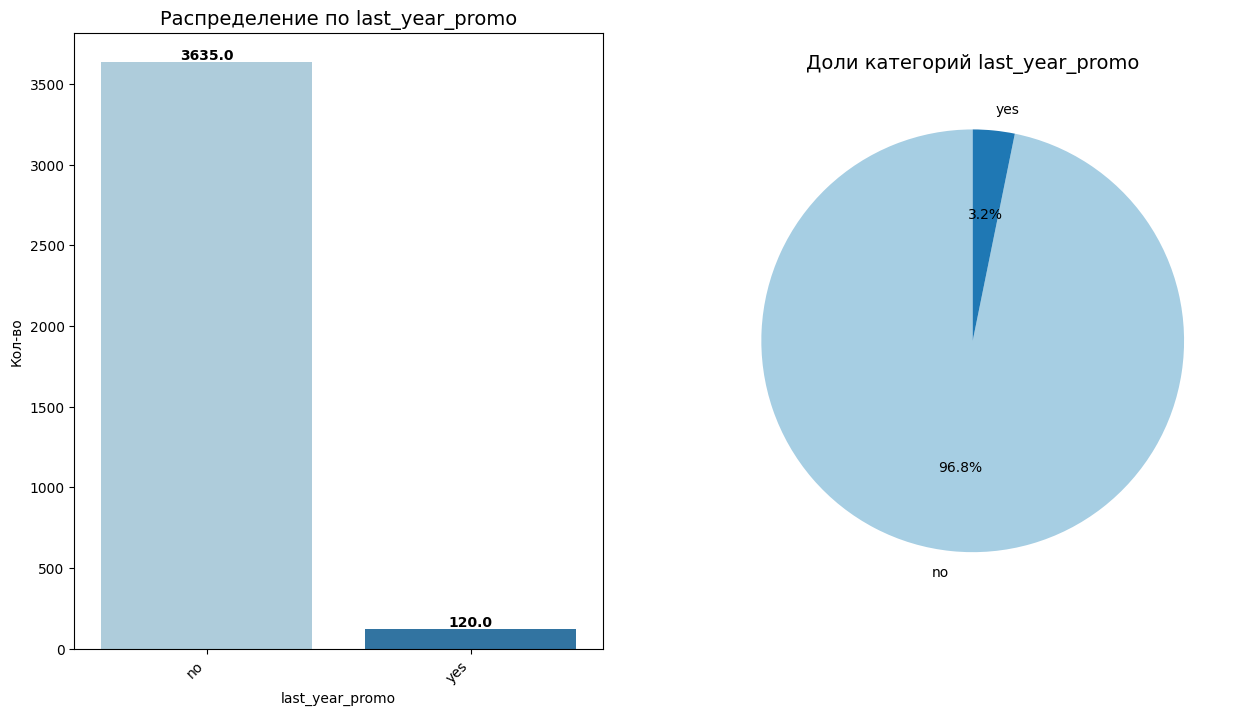

In [23]:
# Столбец 'last_year_promo'
plot_categorical(train_satisfaction, column='last_year_promo')

<div style="background-color: white; border: 2px solid yellowgreen; border-radius: 0px; padding: 15px 25px; display: inline-block; color: black;">


По графику распределения категории `last_year_promo` видим, что подавляющее большенство сотрудников `не получило повышения` (3635 записей, 96.8%). 

<span style="color:crimson">

- <span style="color:black">Сильный дисбаланс классов. Повышение - редкое событие (3.2%).Минимальные возможности карьерного роста. Сотрудники могут не видеть перспектив;
- <span style="color:black">Необходимо учитывать сильный дисбаланс при построении модели.


<div style="border-left: 3px solid yellowgreen; padding-left: 15px; margin: 15px 0;"> 

#### last_year_violations `[нарушал ли сотрудник трудовой договор за последний год]`

Статистика для 'last_year_violations':
Всего записей: 3755
Уникальных категорий: 2
Самая частая категория: 'no' (3202 записей)
Доля самой частой категории: 85.3%


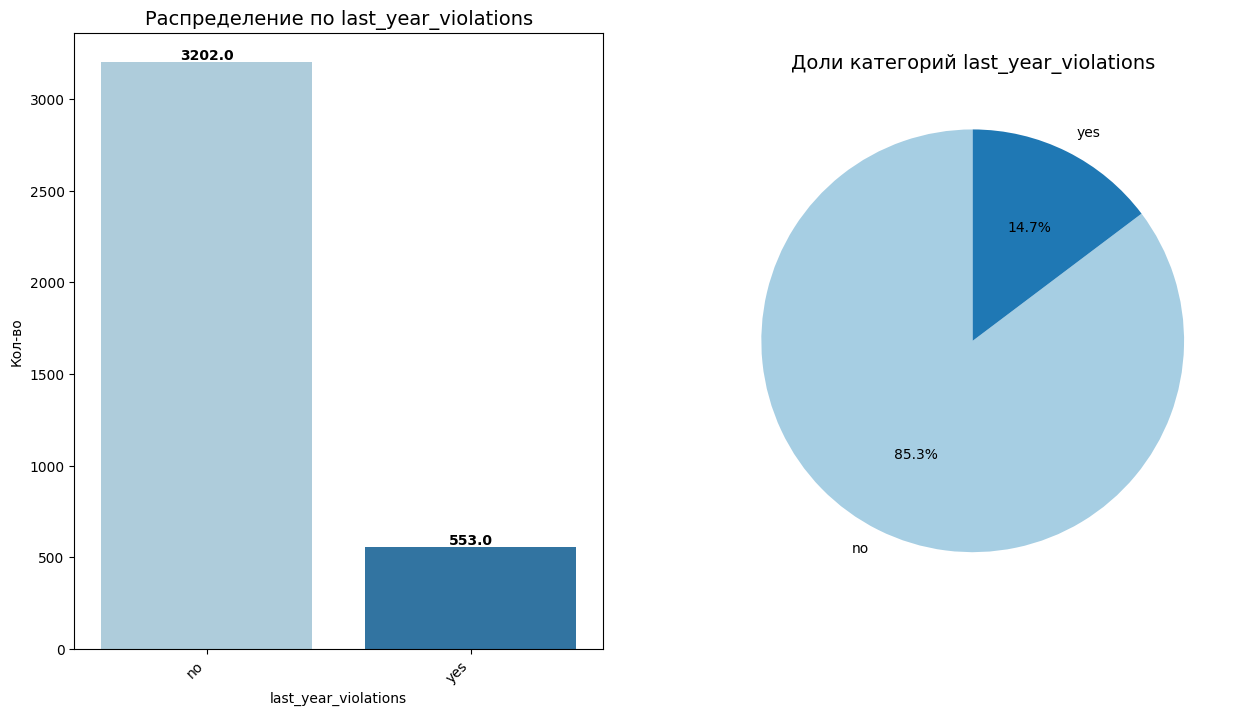

In [24]:
# Столбец 'last_year_violations'
plot_categorical(train_satisfaction, column='last_year_violations')

<div style="background-color: white; border: 2px solid yellowgreen; border-radius: 0px; padding: 15px 25px; display: inline-block; color: black;">

По графику распределения категории `last_year_violations` видим внушительный процент нарушений трудового договора за последний год у сотрудников (553 записи, 14.7%).

<span style="color:crimson">

- <span style="color:black">Каждый 6-ой сотрудник с нарушениями (553 записи, 14.7%). Весьма высокий процент. Хорошо бы проанализировать типы нарушений.

<span style="color:black">Для модели машинного обучения признак `last_year_violations` имеет значимую долю положительных случаев (14.7%), что делает его информативным прогностическим фактором для дальнейшего моделирования.

<div style="border-left: 3px solid yellowgreen; padding-left: 15px; margin: 15px 0;"> 

#### employment_years `[длительность работы в компании в годах]`

Статистика для 'employment_years':
Всего записей: 3755
Уникальных категорий: 10
Самая частая категория: '1' (852 записей)
Доля самой частой категории: 22.7%


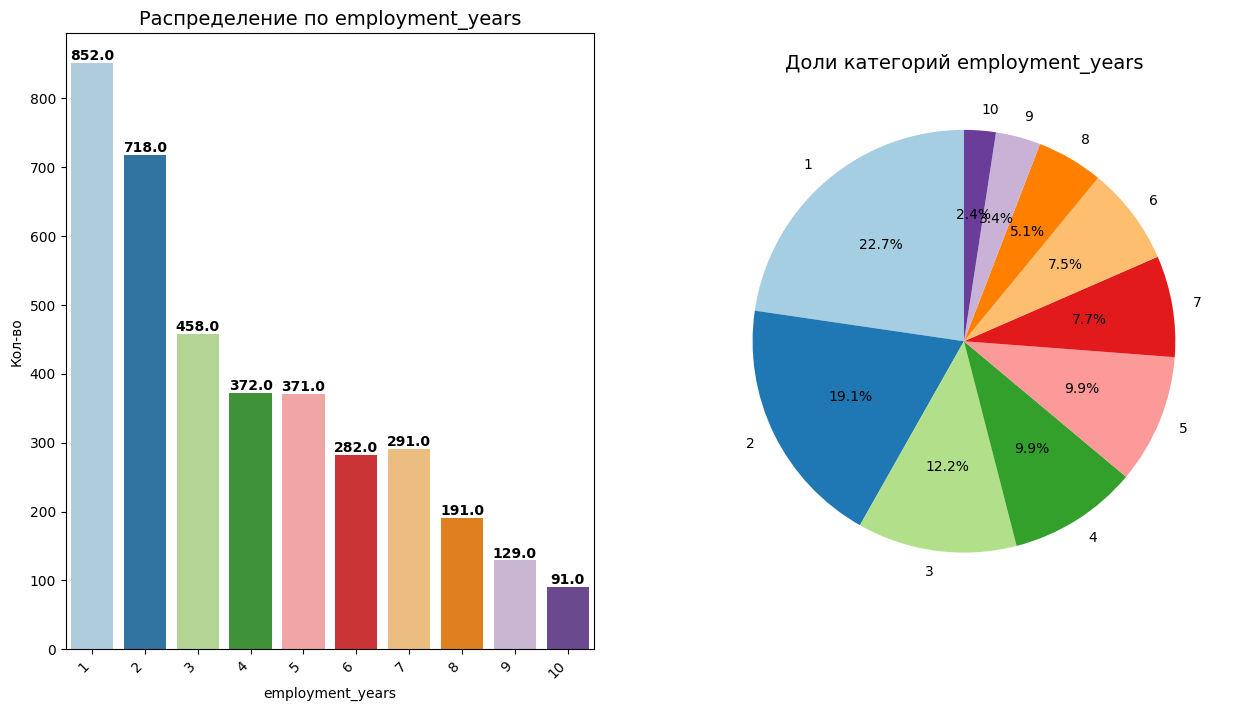

In [25]:
# Столбец 'employment_years'
plot_categorical(train_satisfaction, column='employment_years')

<div style="background-color: white; border: 2px solid yellowgreen; border-radius: 0px; padding: 15px 25px; display: inline-block; color: black;">

По графику распределения категории `employment_years` видим, что большенство сотрудников работают в компании `1 год` (852 записей, 22.7%).

<span style="color:crimson"> 

- <span style="color:black">`2 года`: 19.1% (вторая по величине)
- <span style="color:black">`3 года`: 12.2%
- <span style="color:black">`4-5 лет`: 19.8% (4 года: 9.9%, 5 лет: 9.9%)
- <span style="color:black">`6-10 лет`: 26.1% (6 лет: 7.5%, 7 лет: 7.7%, 8 лет: 5.1%, 9 лет: 3.4%, 10 лет: 2.4%)

---

- <span style="color:black">Компания с высокой текучкой/резким увеличением штата: 22.7% сотрудников работают всего 1 год
- <span style="color:black">Количество сотрудников резко уменьшается с ростом стажа
- <span style="color:black">Только 2.3% сотрудников достигают 10-летнего стажа

---

- <span style="color:black">Резкое снижение доли сотрудников после 2-го года работы (Первые 2 года - ключевые для удержания персонала)
- <span style="color:black">Отток на 3 и 4 годах

<span style="color:black">Необходимо проанализировать связь стажа с `job_satisfaction_rate`

<div style="border-left: 3px solid yellowgreen; padding-left: 15px; margin: 15px 0;"> 

#### supervisor_evaluation `[оценка качества работы сотрудника, которую дал руководитель]`

Статистика для 'supervisor_evaluation':
Всего записей: 3755
Уникальных категорий: 5
Самая частая категория: '4' (1451 записей)
Доля самой частой категории: 38.6%


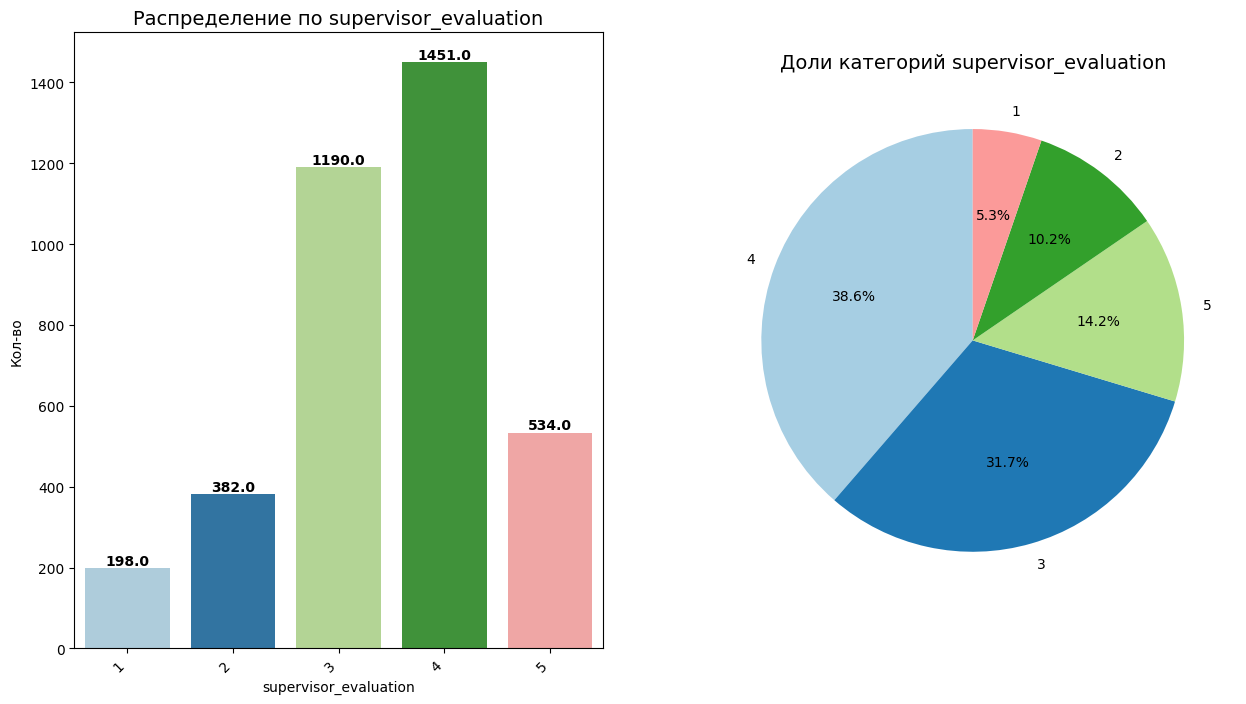

In [26]:
# Столбец 'supervisor_evaluation'
plot_categorical(train_satisfaction, column='supervisor_evaluation')

<div style="background-color: white; border: 2px solid yellowgreen; border-radius: 0px; padding: 15px 25px; display: inline-block; color: black;">

По графику распределения категории `supervisor_evaluation` видим, что большенству сотрудников, которым руководители дали оценку качества работы `4` (1451 запись, 38.6%).

<span style="color:crimson"> 

- <span style="color:black">Положительные оценки у 52.8% сотрудников
- <span style="color:black">Средние 31.7%
- <span style="color:black">Негативные 15.5%

### Таблица `test_features`

In [27]:
# Выводим Категориальные и Дискретные количественные столбцы таблицы 'test_features'
cat_cols, disc_cols = get_column_types(test_features)
print(f"Категориальные: {cat_cols}")
print(f"Дискретные количественные (<11 уникальных): {disc_cols}")

Категориальные: ['dept', 'level', 'workload', 'last_year_promo', 'last_year_violations']
Дискретные количественные (<11 уникальных): ['employment_years', 'supervisor_evaluation']


<div style="border-left: 3px solid yellowgreen; padding-left: 15px; margin: 15px 0;"> 

#### dept `[отдел, в котором работает сотрудник]`

Статистика для 'dept':
Всего записей: 2000
Уникальных категорий: 5
Самая частая категория: 'sales' (763 записей)
Доля самой частой категории: 38.1%


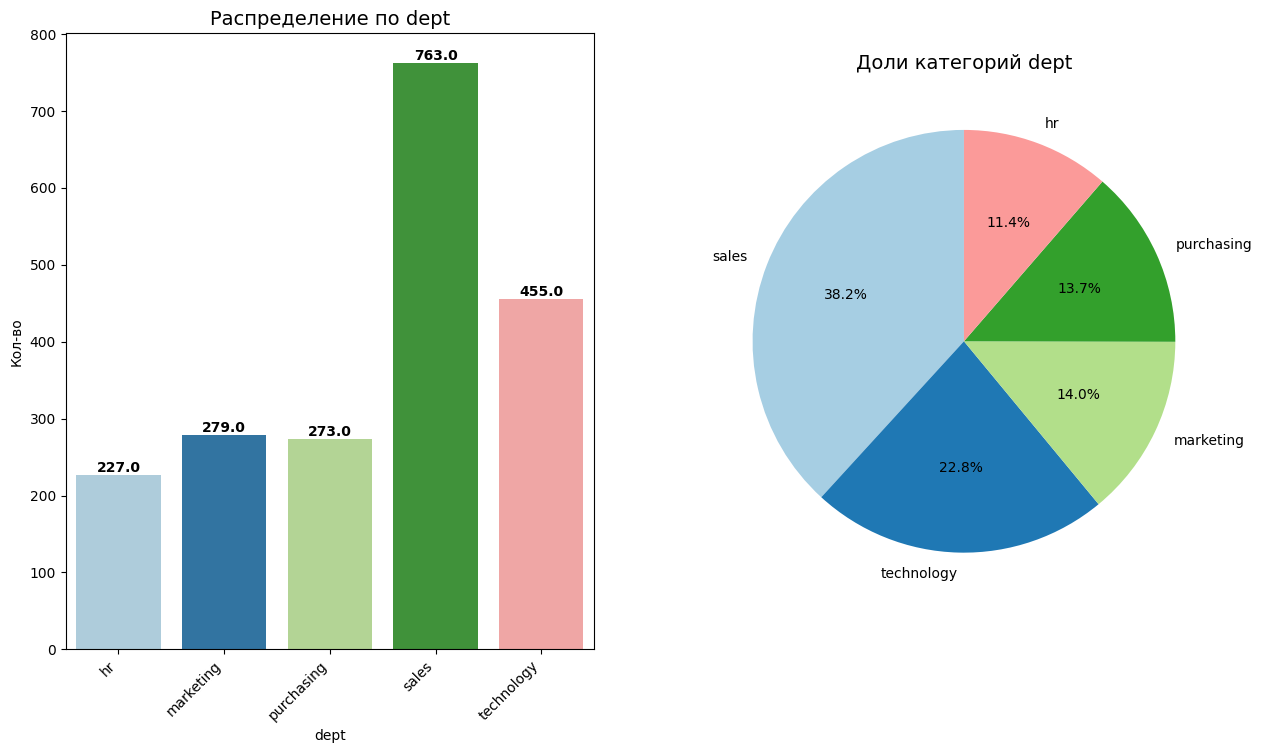

In [28]:
# Столбец 'dept'
plot_categorical(test_features, column='dept')

<div style="background-color: white; border: 2px solid yellowgreen; border-radius: 0px; padding: 15px 25px; display: inline-block; color: black;">

По графику распределения категории `dept` видим, что обльшая часть компании в данной таблице - это сотрудники отдела `sales` (763 записи, доля 38.2%).

<span style="color:crimson"> 

- <span style="color:black"> В топ-3 также входят `technology` (22.8%) и `marketing` (14.0%).
- <span style="color:black">Соотношение отделов сохраняется - распределение практически идентично в обеих выборках
- <span style="color:black">Продажи доминируют - отдел `sales` составляет около 38.2% в обеих выборках

<span style="color:black"> **Незначительные изменения:**

- <span style="color:black">`Technology` увеличилась с 21.8% до 22.8%
- <span style="color:black">`Purchasing` уменьшилась с 15.6% до 13.7%
- <span style="color:black">`Marketing` и `HR` остались практически без изменений

---

<span style="color:black">Распределение сотрудников по отделам стабильно между тренировочной и тестовой выборками, что свидетельствует о репрезентативности тестовых данных. Отсутствие значительных расхождений подтверждает корректность разделения на выборки и снижает риск смещения при обучении моделей.

<div style="border-left: 3px solid yellowgreen; padding-left: 15px; margin: 15px 0;"> 

#### level `[уровень занимаемой должности]`

Статистика для 'level':
Всего записей: 2000
Уникальных категорий: 3
Самая частая категория: 'junior' (974 записей)
Доля самой частой категории: 48.7%


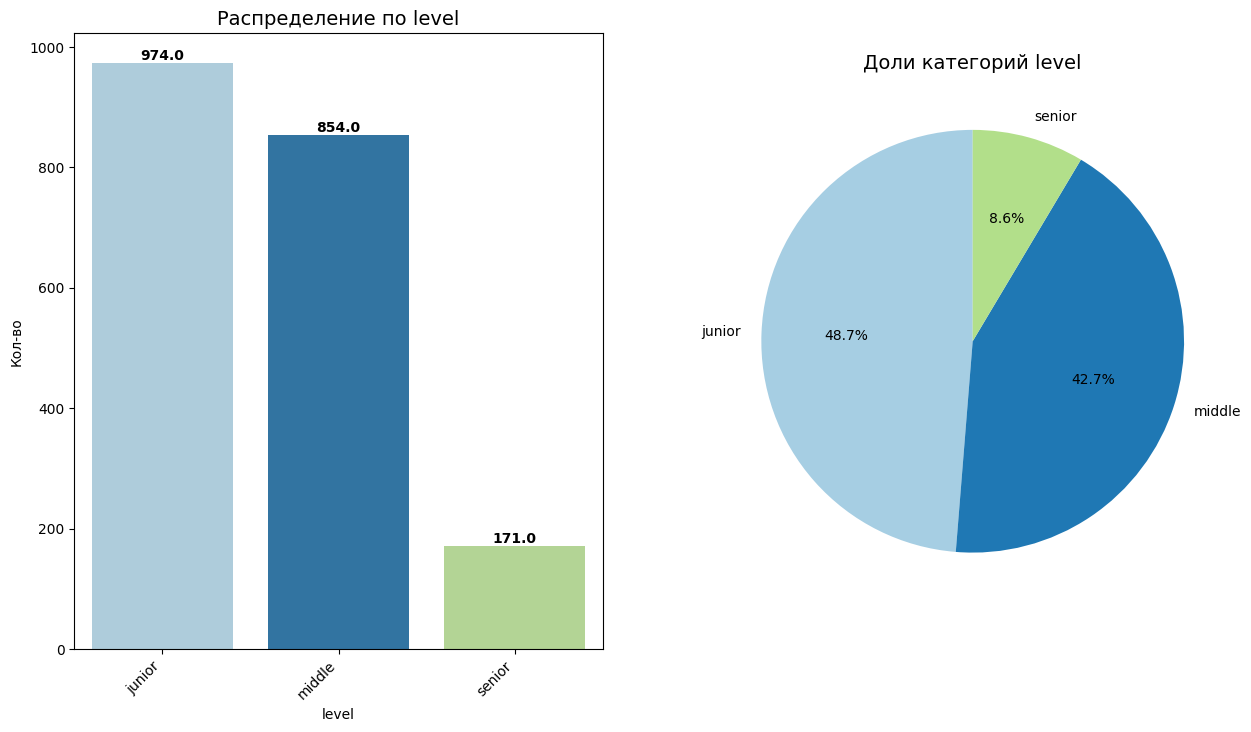

In [29]:
# Столбец 'level'
plot_categorical(test_features, column='level')

<div style="background-color: white; border: 2px solid yellowgreen; border-radius: 0px; padding: 15px 25px; display: inline-block; color: black;">

По графику распределения категории `level` видим, что большая часть сотрудников в компании - это сотрудники с уровнем `junior` (974 записей, доля 48.7%).

<span style="color:crimson">

- <span style="color:black">Распределение практически идентично между выборками

<span style="color:black">**Незначительные отличия**:

- <span style="color:black"> `junior`: +3.4% в тестовой выборке
- <span style="color:black"> `middle`: -2.5%
- <span style="color:black"> `senior`: -0.9%

<span style="color:black">Минимальные расхождения между выборками и стабильное соотношение junior/middle  подтверждают, что распределение по уровням должностей в тестовых данных практически идентично тренировочным.

---

- <span style="color:black"> Выборки репрезентативны, что обеспечивает надежность прогнозных моделей и корректность оценки их качества.
- <span style="color:black"> В компании сохраняется устойчивая иерархическая структура с преобладанием рядовых специалистов (около 90% штата), что создает значительную нагрузку на старших сотрудников.

<div style="border-left: 3px solid yellowgreen; padding-left: 15px; margin: 15px 0;"> 

#### workload `[уровень загруженности сотрудника]`

Статистика для 'workload':
Всего записей: 2000
Уникальных категорий: 3
Самая частая категория: 'medium' (1043 записей)
Доля самой частой категории: 52.1%


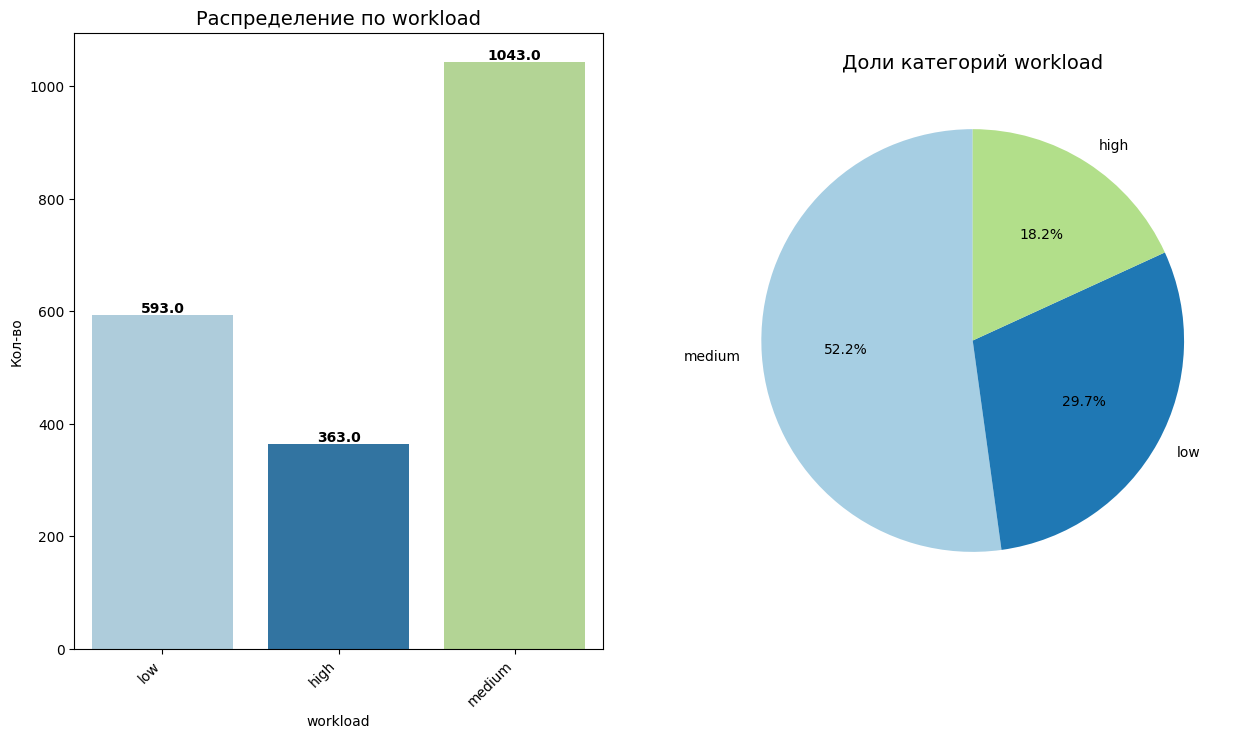

In [30]:
# Столбец 'workload'
plot_categorical(test_features, column='workload')

<div style="background-color: white; border: 2px solid yellowgreen; border-radius: 0px; padding: 15px 25px; display: inline-block; color: black;">

По графику распределения категории `workload` видим, что уровень загруженности сотрудников в основном `medium` (1043 записей, доля 52.1%).

<span style="color:crimson">

- <span style="color:black"> `medium`: 52.1% (1043 сотрудников)
- `low`:  <span style="color:black">29.7%
- `high`:  <span style="color:black">18.2%

---

-  <span style="color:black">Распределение между тестовой и тренировочной выборками практически идентичное (различия менее 0.5% по всем категориям). Соотношение medium/low/high сохраняется в обеих выборках.
-  <span style="color:black">Данные репрезентативны (тестовые данные полностью отражают распределение тренировочных).

<div style="border-left: 3px solid yellowgreen; padding-left: 15px; margin: 15px 0;"> 

####  last_year_promo `[было ли повышение за последний год]`

Статистика для 'last_year_promo':
Всего записей: 2000
Уникальных категорий: 2
Самая частая категория: 'no' (1937 записей)
Доля самой частой категории: 96.9%


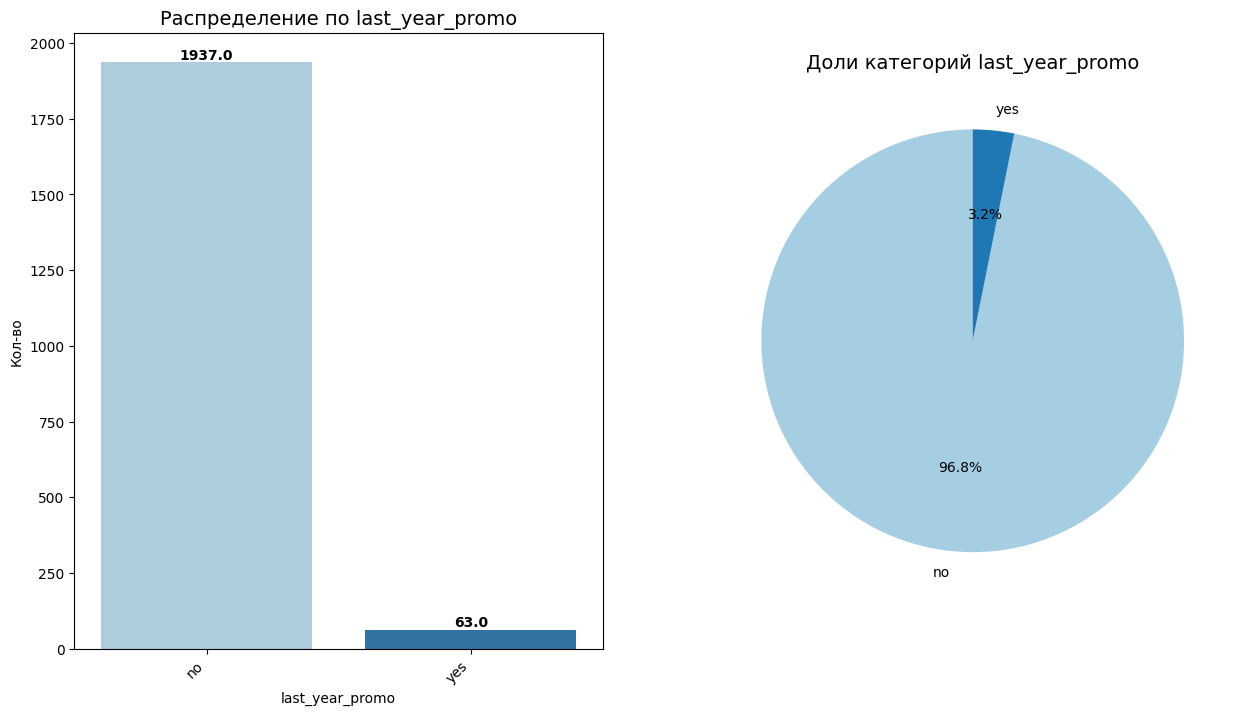

In [31]:
# Столбец 'last_year_promo'
plot_categorical(test_features, column='last_year_promo')

<div style="background-color: white; border: 2px solid yellowgreen; border-radius: 0px; padding: 15px 25px; display: inline-block; color: black;">

По графику распределения категории `last_year_promo` видим, что подавляющее большенство сотрудников `не получили повышения` (1937 записей, 96.8%).

<span style="color:crimson">

- <span style="color:black"> Распределение практически идентично
- <span style="color:black"> Дисбаланс сохраняется и в тестовой выборке
- <span style="color:black">Высокая доля сотрудников без перспектив роста может негативно влиять на удовлетворённость

<div style="border-left: 3px solid yellowgreen; padding-left: 15px; margin: 15px 0;"> 

#### last_year_violations `[нарушал ли сотрудник трудовой договор за последний год]`

Статистика для 'last_year_violations':
Всего записей: 2000
Уникальных категорий: 2
Самая частая категория: 'no' (1738 записей)
Доля самой частой категории: 86.9%


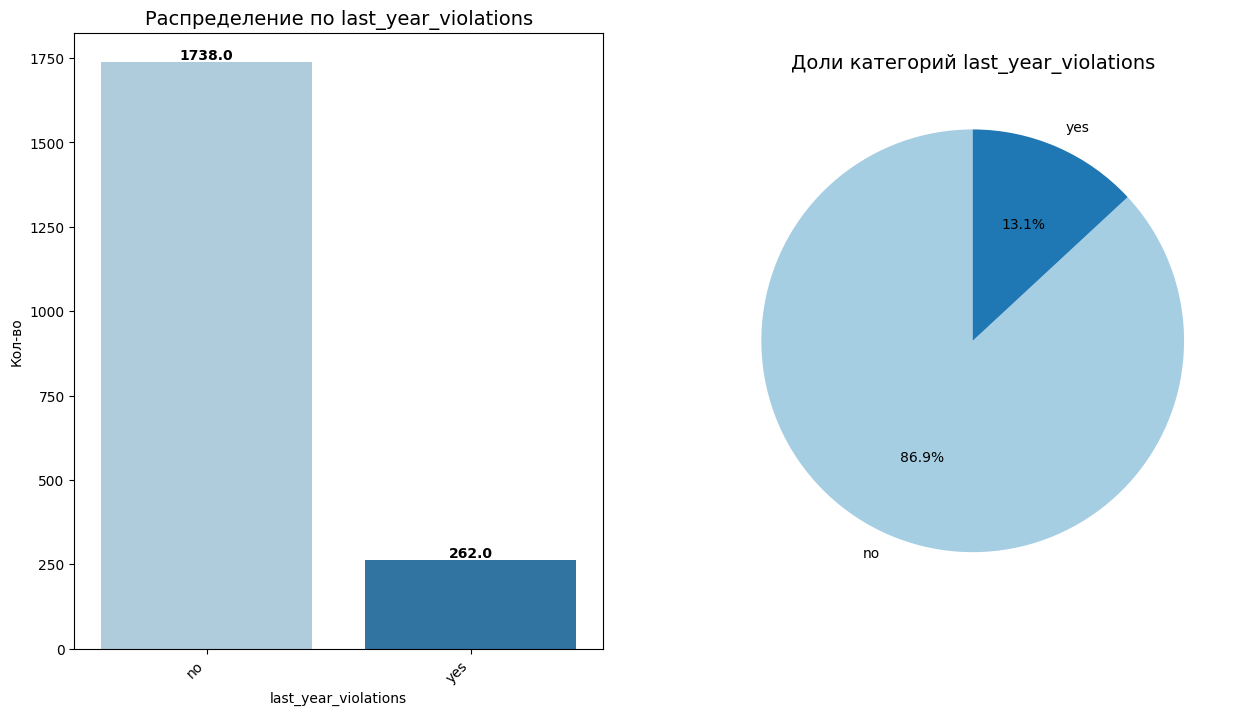

In [32]:
# Столбец 'last_year_violations'
plot_categorical(test_features, column='last_year_violations')

<div style="background-color: white; border: 2px solid yellowgreen; border-radius: 0px; padding: 15px 25px; display: inline-block; color: black;">

По графику распределения категории `last_year_violations` видим, что и в тестовой выборке внушительный процент нарушений трудового договора за последний год у сотрудников (262 записи, 13.1%).

<span style="color:crimson">

- <span style="color:black"> Распределение практически идентично с тренировочной выборкой
-  <span style="color:black"> Стоит изучить связь нарушений с отделами, уровнями должностей, нагрузкой. 

<div style="border-left: 3px solid yellowgreen; padding-left: 15px; margin: 15px 0;"> 

#### employment_years `[длительность работы в компании в годах]`

Статистика для 'employment_years':
Всего записей: 2000
Уникальных категорий: 10
Самая частая категория: '1' (522 записей)
Доля самой частой категории: 26.1%


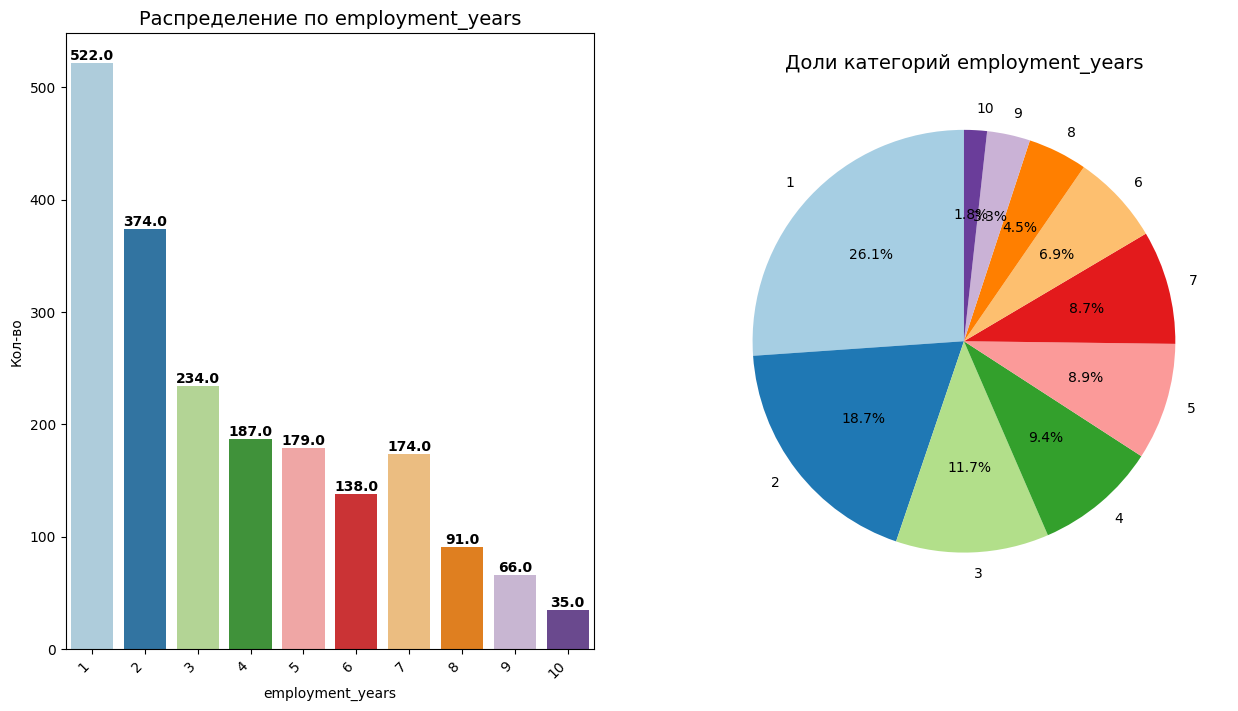

In [33]:
# Столбец 'employment_years'
plot_categorical(test_features, column='employment_years')

<div style="background-color: white; border: 2px solid yellowgreen; border-radius: 0px; padding: 15px 25px; display: inline-block; color: black;">

По графику распределения категории `employment_years` видим, что и в тестовой выборке большенство сотрудников работают в компании `1 год` (522 записи, 26.1%).

<span style="color:crimson">

- <span style="color:black"> Распределение стажа в целом репрезентативно, хотя есть небольшое смещение в сторону сотрудников, которые работают в компании `1 год` в тестовой выборке. Различия не превышают 2%.

<div style="border-left: 3px solid yellowgreen; padding-left: 15px; margin: 15px 0;"> 

#### supervisor_evaluation `[оценка качества работы сотрудника, которую дал руководитель]`

Статистика для 'supervisor_evaluation':
Всего записей: 2000
Уникальных категорий: 5
Самая частая категория: '4' (857 записей)
Доля самой частой категории: 42.9%


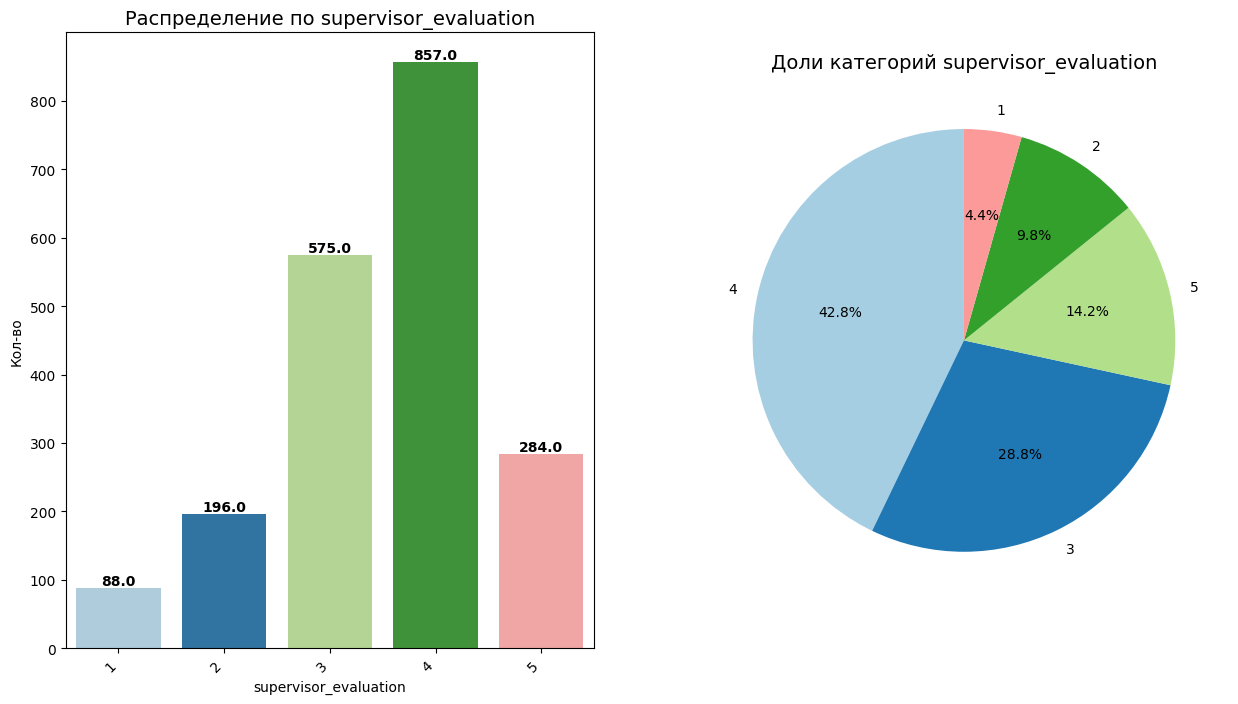

In [34]:
# Столбец 'supervisor_evaluation'
plot_categorical(test_features, column='supervisor_evaluation')

<div style="background-color: white; border: 2px solid yellowgreen; border-radius: 0px; padding: 15px 25px; display: inline-block; color: black;">

По графику распределения категории `supervisor_evaluation` видим, что большенству сотрудников, которым руководители дали оценку качества работы `4` (857 записи, 42.8%).

<span style="color:crimson">

- <span style="color:black"> В тестовых данных больше оценок `4` (+2.7%)
- <span style="color:black">Оценок `3` меньше в тестовой выборке на 2.8%
- <span style="color:black">Оценки `1`, `2`, `5` практически без изменений


### II Статистика и графики распределений для количественных значений

#### <span style="color:royalblue">Функция. Ящик с усами и Гистограмма для количественных признаков

In [35]:
def plot_quantitative_new(df, column, figsize=(15, 6), palette='Paired',
                         custom_labels=None, discrete_threshold=20):
    ''' 
    Ящик с усами и Гистограмма для количественных признаков С ПРОВЕРКОЙ НА НОРМАЛЬНОСТЬ РАСПРЕДЕЛЕНИЯ
    
    Параметры:
    -----------
    df : DataFrame - Датафрейм с данными
    column : str - Название столбца для анализа
    figsize : tuple, default=(15, 6) - размер области построения
    palette : str, default='Paired' - Цветовая палитра
    custom_labels : dict, optional - Словарь с пользовательскими подписями для графиков.
    Формат: {'название_столбца': ['название_графика', 'подпись_оси_X', 'подпись_оси_Y']}
    discrete_threshold : int, default=20 - Пороговое количество уникальных значений для определения дискретного признака
    
    '''
    
    # Создаем словарь с подписями по умолчанию
    default_labels = {
                      'salary': [
                                 'Ежемесячная зарплата сотрудника', 
                                 'Зарплата, руб.', 
                                 'Кол-во сотрудников'
                                 ],
                      'job_satisfaction_rate': [
                                                'Уровень удовлетворенности сотрудника',
                                                'Уровень', 
                                                'Кол-во сотрудников'
                                  ]
                        }
                
    # Объединяем пользовательские подписи с подписями по умолчанию
    if custom_labels:
        default_labels.update(custom_labels)
    
    labels_dict = default_labels
    
    # Получаем подписи для текущего столбца
    if column in labels_dict:
        plot_title, x_label, y_label = labels_dict[column]
    else:
        # Если столбец не найден в словаре, используем общие подписи
        plot_title = f'Распределение: {column}'
        x_label = column
        y_label = 'Кол-во пользователей'
    
    # Определяем, является ли признак дискретным
    unique_values = df[column].nunique()
    is_integer = df[column].dtype in ['int64', 'int32', 'int16', 'int8']
    is_discrete = (unique_values <= discrete_threshold and is_integer) or (unique_values <= 15)
    
    # Создаем две диаграммы
    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=figsize)
    
    # Цвет для графиков
    color = sns.color_palette(palette, 1)[0]
    
    # 1. Ящик с усами
    sns.boxplot(data=df, y=column, color=color, ax=ax1)
    
    ax1.set_title(f'Ящик с усами: {plot_title}', fontsize=14)
    ax1.set_ylabel(x_label)
    
    # 2. Гистограмма с настройкой для дискретных/непрерывных данных
    if is_discrete:
        # Для дискретных данных используем discrete=True
        sns.histplot(data=df, x=column, discrete=True, color=color, ax=ax2, shrink=0.8)
        
        # Настраиваем целочисленные деления на оси X
        min_val = int(df[column].min())
        max_val = int(df[column].max())
        if (max_val - min_val) <= 30:  # Ограничиваем количество меток
            ax2.set_xticks(range(min_val, max_val + 1))
            
        # Для небольшого количества значений добавляем аннотации
        if unique_values <= 15:
            value_counts = df[column].value_counts().sort_index()
            for val, count in value_counts.items():
                ax2.text(val, count + max(value_counts)*0.02, 
                        f'{count}', ha='center', va='bottom', fontsize=9)
    else:
        # Для непрерывных данных используем обычную гистограмму с KDE
        sns.histplot(data=df, x=column, kde=True, color=color, ax=ax2)
    
    ax2.set_title(f'Гистограмма: {plot_title}', fontsize=14)
    ax2.set_xlabel(x_label)
    ax2.set_ylabel(y_label)
    
    # Добавляем линию медианы на гистограмму
    median_val = df[column].median()
    ax2.axvline(median_val, color='red', linestyle='--', 
                label=f'Медиана: {median_val:.3f}')
    ax2.legend()
    
    plt.tight_layout()
    plt.show()
    
    # Вывод статистики с информацией о типе данных
    print(f"Статистика для '{plot_title}':")
    print('-' * 50)
    stats = df[column].describe()
    print(f"Тип данных: {'Дискретный' if is_discrete else 'Непрерывный'}")
    print(f"Уникальных значений: {unique_values}")
    print(f"Кол-во записей: {stats['count']:.0f}")
    print(f"Среднее: {stats['mean']:.3f}")
    print(f"Стандартное отклонение: {stats['std']:.3f}")
    print(f"Медиана: {stats['50%']:.3f}")
    print(f"Минимум: {stats['min']:.3f}")
    print(f"Максимум: {stats['max']:.3f}")
    print(f"25-й перцентиль: {stats['25%']:.3f}")
    print(f"75-й перцентиль: {stats['75%']:.3f}")
    
    # Проверка на нормальность распределения
    if len(df[column].dropna()) >= 3:
        print(f"\nПроверка на нормальность распределения (α=0.05):")
        print('-' * 50)
        data = df[column].dropna()
        
        # Критерий Шапиро-Уилка
        if len(data) <= 5000:
            shapiro_stat, shapiro_p = shapiro(data)
            shapiro_normal = shapiro_p > 0.05
            print(f"Критерий Шапиро-Уилка: p-value = {shapiro_p:.4f} {'> 0.05 (нормальное)' if shapiro_normal else '< 0.05 (не нормальное)'}")
        
        # Критерий Д'Агостино
        try:
            dagostino_stat, dagostino_p = normaltest(data)
            dagostino_normal = dagostino_p > 0.05
            print(f"Критерий Д'Агостино: p-value = {dagostino_p:.4f} {'> 0.05 (нормальное)' if dagostino_normal else '< 0.05 (не нормальное)'}")
            
            # Итоговый вывод
            if dagostino_p > 0.05:
                print('ВЫВОД: распределение соответствует нормальному')
            else:
                print('ВЫВОД: распределение НЕ соответствует нормальному')
                
        except Exception as e:
            print(f'Ошибка при проверке на нормальное распределение: {e}')
    else:
        print(f'\nПримечание: недостаточно данных для проверки на нормальное распределение (n < 3)')

#### <span style="color:royalblue"> Функция. Вывод столбцов с колличественными значениями

In [36]:
def get_numeric_types(df, threshold=11):
    '''
    Только для числовых столбцов
    '''
    # Дискретные (int с > threshold уникальных значений)
    discrete = []
    # Непрерывные (int с >= threshold + все float)
    continuous = []
    
    for col in df.select_dtypes(include=['int64', 'int32', 'float64', 'float32']).columns:
        if df[col].dtype in ['int64', 'int32']:
            if df[col].nunique() > threshold:
                discrete.append(col)
        else:  # float типы
            continuous.append(col)
    
    return discrete, continuous

### Таблица `train_satisfaction`

In [37]:
# Выводим Непрерывные и Дискретные столбцы таблицы 'train_satisfaction' 
discrete, continuous = get_numeric_types(train_satisfaction)
print(f"\nДискретные (<11 уникальных): {discrete}")
print(f"Непрерывные (≥11 уникальных int + все float): {continuous}")


Дискретные (<11 уникальных): ['salary']
Непрерывные (≥11 уникальных int + все float): ['job_satisfaction_rate']


<div style="border-left: 3px solid yellowgreen; padding-left: 15px; margin: 15px 0;"> 

#### salary `[ежемесячная зарплата сотрудника]`

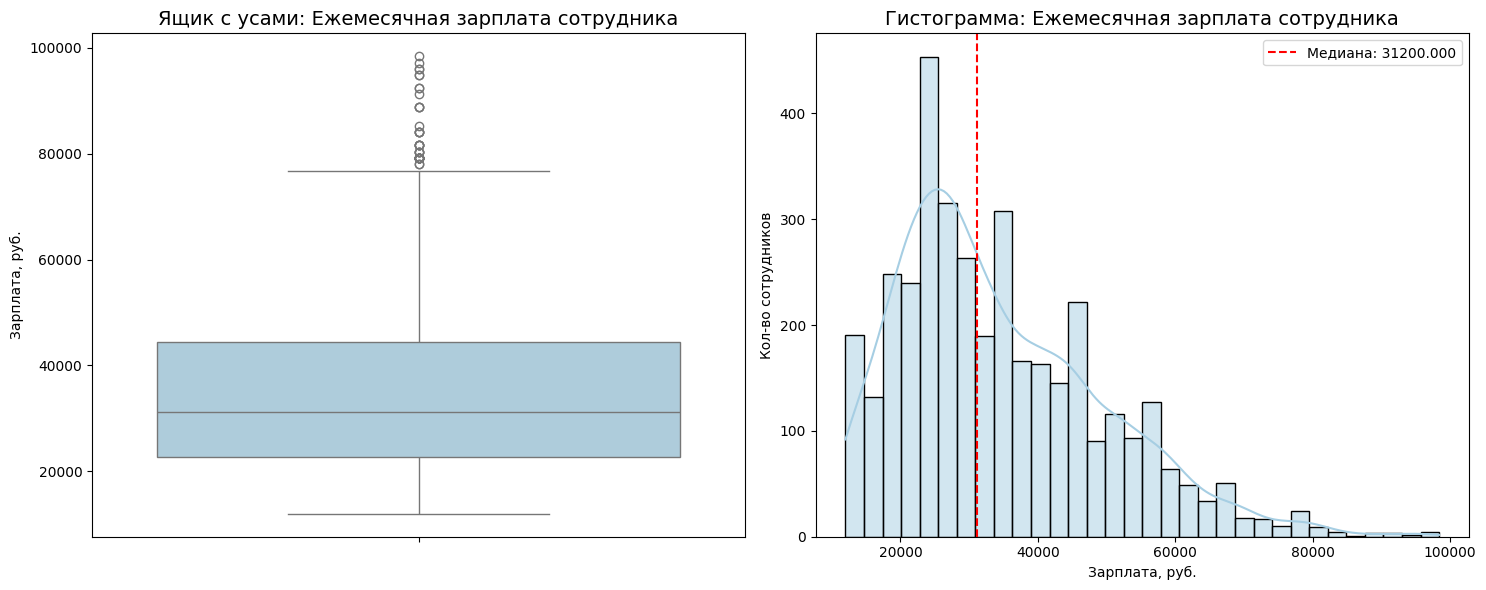

Статистика для 'Ежемесячная зарплата сотрудника':
--------------------------------------------------
Тип данных: Непрерывный
Уникальных значений: 68
Кол-во записей: 3755
Среднее: 34457.417
Стандартное отклонение: 15050.644
Медиана: 31200.000
Минимум: 12000.000
Максимум: 98400.000
25-й перцентиль: 22800.000
75-й перцентиль: 44400.000

Проверка на нормальность распределения (α=0.05):
--------------------------------------------------
Критерий Шапиро-Уилка: p-value = 0.0000 < 0.05 (не нормальное)
Критерий Д'Агостино: p-value = 0.0000 < 0.05 (не нормальное)
ВЫВОД: распределение НЕ соответствует нормальному


In [38]:
# Столбец 'salary'
plot_quantitative_new(train_satisfaction, 'salary')

<div style="background-color: white; border: 2px solid yellowgreen; border-radius: 0px; padding: 15px 25px; display: inline-block; color: black;">

По графику распределения признака `salary` видим, что ежемесячная зарплата сотрудника:
    
    - в среднем 34 457 руб
    - медиана 31 200 руб
    - Стандартное отклонение 15 050 руб. указывает на сильный разброс данных (что характерно для компаний с выраженной грейдовой системой и значительными различиями в оплате труда между уровнями должностей).

- Правосторонняя асимметрия (высокие зарплаты "тянут" среднее вверх)
- Большой разброс данных (8.2 раза между минимумом и максимумом)
- Выбросы минимальны и сохранены для анализа. Так как зарплата в 98400 руб. не является чем-то сверхъестественным (репрезентируют высококвалифицированных специалистов).
- Данные столбца без аномальных значений.

---
 
<span style="color:crimson"> **Распределение НЕ соответствует нормальному.**



<div style="border-left: 3px solid yellowgreen; padding-left: 15px; margin: 15px 0;"> 

#### job_satisfaction_rate `[уровень удовлетворённости сотрудника работой в компании, целевой признак]`

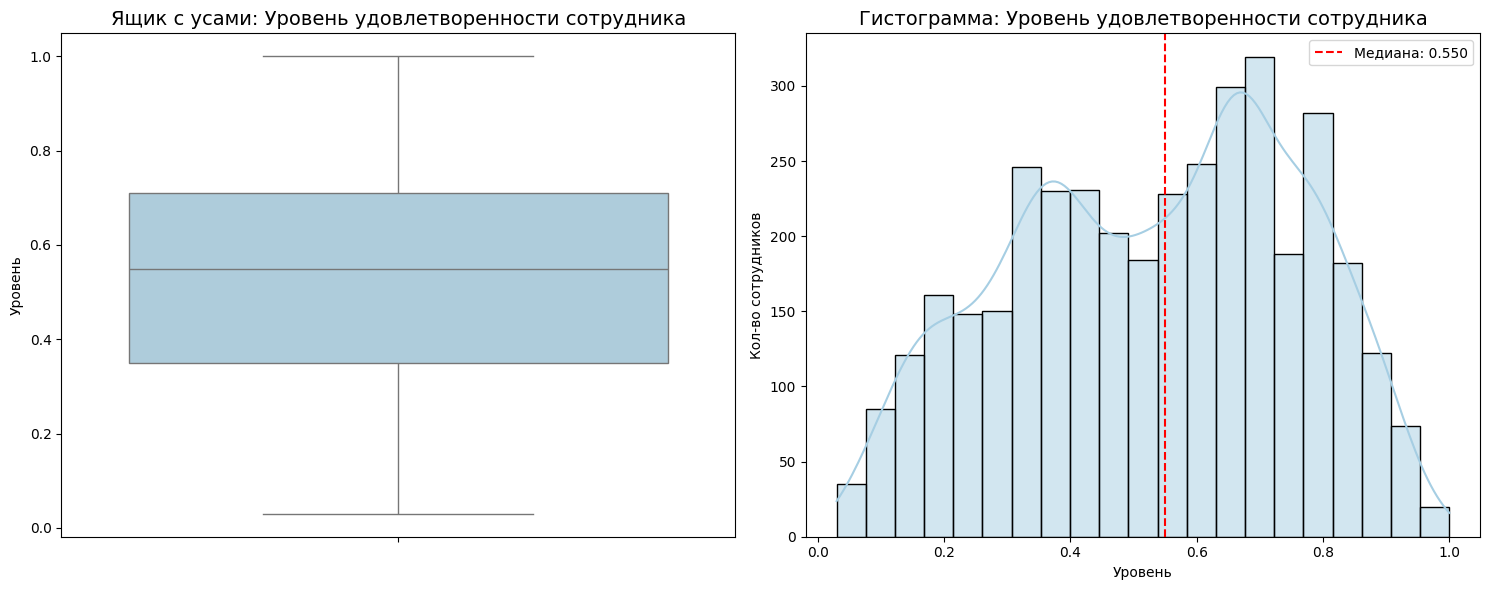

Статистика для 'Уровень удовлетворенности сотрудника':
--------------------------------------------------
Тип данных: Непрерывный
Уникальных значений: 98
Кол-во записей: 3755
Среднее: 0.533
Стандартное отклонение: 0.226
Медиана: 0.550
Минимум: 0.030
Максимум: 1.000
25-й перцентиль: 0.350
75-й перцентиль: 0.710

Проверка на нормальность распределения (α=0.05):
--------------------------------------------------
Критерий Шапиро-Уилка: p-value = 0.0000 < 0.05 (не нормальное)
Критерий Д'Агостино: p-value = 0.0000 < 0.05 (не нормальное)
ВЫВОД: распределение НЕ соответствует нормальному


In [39]:
# Столбец 'job_satisfaction_rate'
plot_quantitative_new(train_satisfaction, 'job_satisfaction_rate')

<div style="background-color: white; border: 2px solid yellowgreen; border-radius: 0px; padding: 15px 25px; display: inline-block; color: black;">

По графику распределения признака `job_satisfaction_rate` видим, что уровень удовлетворенности сотрудника работой в компании:

    - в среднем 53%
    - медиана 55%
    - стандартное отклонение ~23% указывает на сильный разброс в значениях

- Левосторонняя ассиметрия (Хвост в сторону низких значений "тянет" среднее вниз - указывает на наличие группы сильно неудовлетворённых сотрудников)
- 25% сотрудников с удовлетворённостью < 35%. Это критически низко - эти сотрудники представляют наибольший риск увольнения.
- 50% сотрудников с удовлетворённостью в среднем диапазоне (36-71%)
- 25% сотрудников с удовлетворённостью > 71%

---

<span style="color:crimson"> **Распределение НЕ соответствует нормальному.**

### Таблица `test_features`

In [40]:
# Выводим Непрерывные и Дискретные столбцы таблицы 'test_features' 
discrete, continuous = get_numeric_types(test_features)
print(f"\nДискретные (<11 уникальных): {discrete}")
print(f"Непрерывные (≥11 уникальных int + все float): {continuous}")


Дискретные (<11 уникальных): ['salary']
Непрерывные (≥11 уникальных int + все float): []


<div style="border-left: 3px solid yellowgreen; padding-left: 15px; margin: 15px 0;"> 

#### salary `[ежемесячная зарплата сотрудника]`

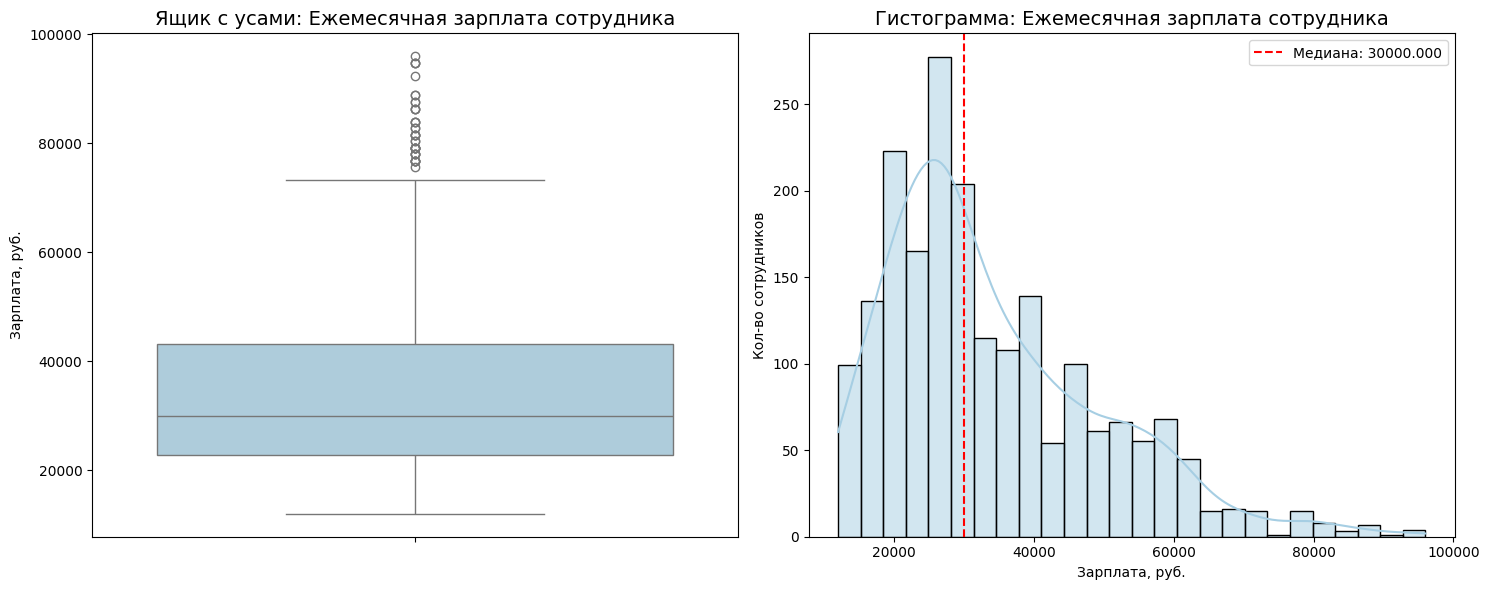

Статистика для 'Ежемесячная зарплата сотрудника':
--------------------------------------------------
Тип данных: Непрерывный
Уникальных значений: 66
Кол-во записей: 2000
Среднее: 34066.800
Стандартное отклонение: 15398.437
Медиана: 30000.000
Минимум: 12000.000
Максимум: 96000.000
25-й перцентиль: 22800.000
75-й перцентиль: 43200.000

Проверка на нормальность распределения (α=0.05):
--------------------------------------------------
Критерий Шапиро-Уилка: p-value = 0.0000 < 0.05 (не нормальное)
Критерий Д'Агостино: p-value = 0.0000 < 0.05 (не нормальное)
ВЫВОД: распределение НЕ соответствует нормальному


In [41]:
# Столбец 'salary'
plot_quantitative_new(test_features, 'salary')

<div style="background-color: white; border: 2px solid yellowgreen; border-radius: 0px; padding: 15px 25px; display: inline-block; color: black;">

По графику распределения признака `salary` видим, что ежемесячная зарплата сотрудника:

- Средняя: 34 067 руб. **(+140 руб., +0.4%)**
- Медиана: 30 000 руб. **(идентично)**
- Стандартное отклонение: 15 398 руб. **(+497 руб., +3.3%)**
- Диапазон: 12 000 - 96 000 руб.

Высокая согласованность данных между тренировочной и тестовой выборками (медиана. квартили и минимум). Есть небольшие расхождения (Средняя зарплата: +0.4% в тестовой выборке/Стандартное отклонение: +3.3%/Максимальная зарплата: -2 400 руб.) 

- **Тестовые данные репрезентативны** - различия статистически незначимы
- <span style="color:crimson"> **Распределение НЕ соответствует нормальному.**

### Таблица `test_target_satisfaction`

In [42]:
# Выводим Непрерывные и Дискретные столбцы таблицы 'test_target_satisfaction' 
discrete, continuous = get_numeric_types(test_target_satisfaction)
print(f"\nДискретные (<11 уникальных): {discrete}")
print(f"Непрерывные (≥11 уникальных int + все float): {continuous}")


Дискретные (<11 уникальных): []
Непрерывные (≥11 уникальных int + все float): ['job_satisfaction_rate']


<div style="border-left: 3px solid yellowgreen; padding-left: 15px; margin: 15px 0;"> 

#### job_satisfaction_rate `[уровень удовлетворённости сотрудника работой в компании, целевой признак]`

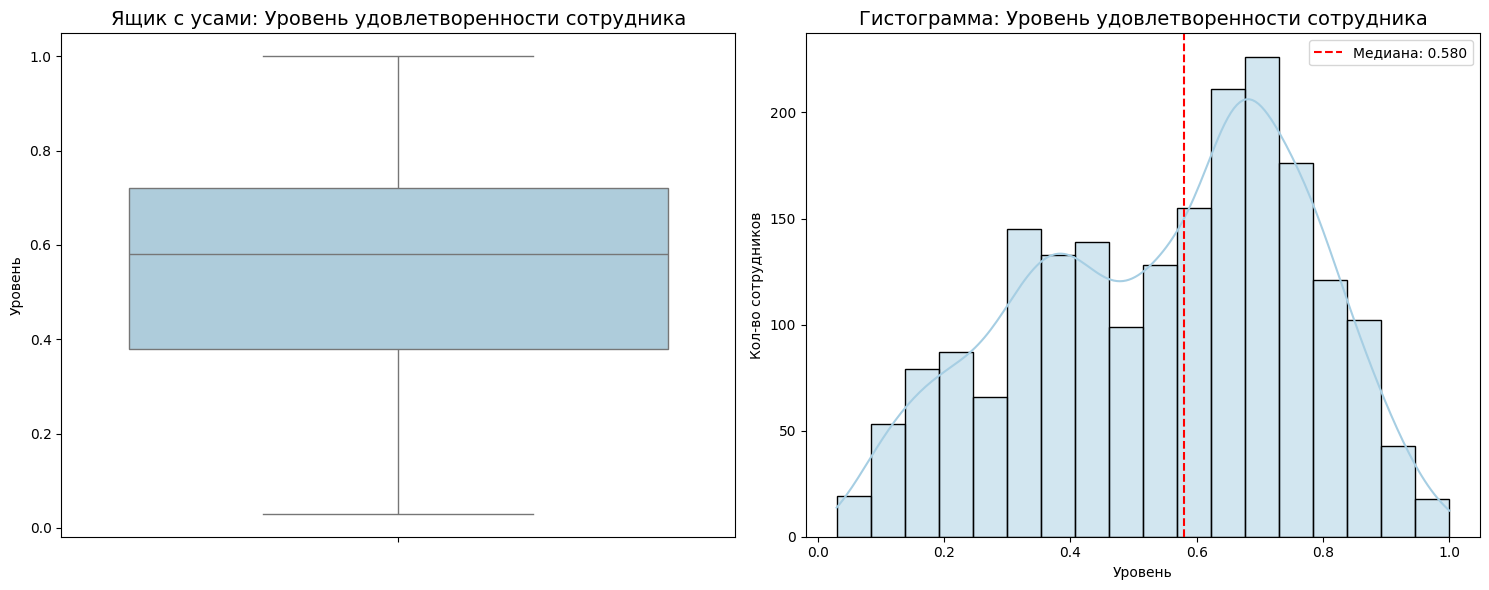

Статистика для 'Уровень удовлетворенности сотрудника':
--------------------------------------------------
Тип данных: Непрерывный
Уникальных значений: 98
Кол-во записей: 2000
Среднее: 0.549
Стандартное отклонение: 0.220
Медиана: 0.580
Минимум: 0.030
Максимум: 1.000
25-й перцентиль: 0.380
75-й перцентиль: 0.720

Проверка на нормальность распределения (α=0.05):
--------------------------------------------------
Критерий Шапиро-Уилка: p-value = 0.0000 < 0.05 (не нормальное)
Критерий Д'Агостино: p-value = 0.0000 < 0.05 (не нормальное)
ВЫВОД: распределение НЕ соответствует нормальному


In [43]:
# Столбец 'job_satisfaction_rate'
plot_quantitative_new(test_target_satisfaction, 'job_satisfaction_rate')

<div style="background-color: white; border: 2px solid yellowgreen; border-radius: 0px; padding: 15px 25px; display: inline-block; color: black;">

По графику распределения признака `job_satisfaction_rate` видим, что уровень удовлетворенности сотрудника работой в компании:

    - в среднем 55%
    - медиана 58%
    - стандартное отклонение 22% указывает на сильный разброс в значениях

- Левосторонняя ассиметрия (Хвост в сторону низких значений "тянет" среднее вниз/медиана>среднего)
- 25% сотрудников с удовлетворённостью < 38%. Это критически низко.
- 50% сотрудников с удовлетворённостью в среднем диапазоне (38-72%)
- 25% сотрудников с удовлетворённостью > 72%

---

- Тестовая выборка сохраняет структуры распределения и вариативности
- <span style="color:crimson"> **Распределение НЕ соответствует нормальному.**

<div style="background-color: white; border: 1.5px solid crimson; border-radius: 10px; padding: 15px 25px; display: inline-block; color: black;">

---

### Вывод
   
---

В данном разделе мы провели статистический анализ всех признаков, прежде разделив их на **категориальные** и **количественные**. Построили графики для каждого признака. 
    
- Для количественных признаков мы построили: "Ящик с усами" и Гистограмму.
- Для категориальных признаков и дискретных числовых значений мы построили: Столбчатую и круговую диаграммы.

---

<span style="color:cornflowerblue">
    
1. **dept** `отдел, в котором работает сотрудник`

- *Тренировочная выборка 1:* <span style="color:black">5 отделов, `sales` лидирует (36.6%)
- *Тестовая выборка 1:* <span style="color:black">идентичное распределение (`sales` 38.1%)

<span style="color:black">Выборки репрезентативны, продажи доминируют. Для моделирования: важный категориальный признак, требует кодирования.

2. **level** `уровень должности`

- *Тренировочная выборка 1:* <span style="color:black">`junior` 45.3%, `middle` 45.2%, `senior` 9.5%.
- *______Тестовая выборка 1:* <span style="color:black">`junior` 48.7%,  `middle` 42.7%, `senior` 8.6%  минимальные отличия

<span style="color:black">Стабильная иерархия с преобладанием `junior`. Для моделирования: ordinal признак с естественным порядком.

3. **workload** `загруженность`

- *Тренировочная выборка 1:* <span style="color:black">`medium` 50.8%, `high` 19.2%, `low` 30%
- *______Тестовая выборка 1:* <span style="color:black">`medium` 52.2%, `high` 18.2%, `low` 29.7% высокое соответствие

<span style="color:black">Стабильное распределение с соблюдением пропорций в данных.

4. **last_year_promo** `повышение`

- *Тренировочная выборка 1:* <span style="color:black">96.8% `без повышения` (сильный дисбаланс)
- *______Тестовая выборка 1:* <span style="color:black">96.8% `без повышения`, идентично

<span style="color:black">Крайне редкое событие (~3%). Для моделирования: требует методов работы с несбалансированными данными.

5. **last_year_violations** `нарушения`
   
- *Тренировочная выборка 1:* <span style="color:black">14.7% `нарушений`
- *______Тестовая выборка 1:* <span style="color:black">13.1% `нарушений`

<span style="color:black">Стабильный уровень нарушений (13-14%). Умеренный дисбаланс, схожее распределение.

6. **employment_years** `стаж`

- *Тренировочная выборка 1:* <span style="color:black">22.7% с `1 годом`, спад после `2 лет` работы
- *______Тестовая выборка 1:* <span style="color:black">26.1% с `1 годом`

<span style="color:black">Высокая текучка в первые годы. Схожее распределение в данных.

7. **supervisor_evaluation** `оценка руководителя`
- *Тренировочная выборка 1:* <span style="color:black">оценка `4` - 38.6%, `3` - 31.7%, `5` - 14.2%, `2` - 10.2%, `1` - 5/3%.
- *______Тестовая выборка 1:* <span style="color:black">оценка `4` - 42.8%, `3` - 28.8%, `5` - 14.2%, `2` - 9.8%, `1` - 4.4% (небольшой сдвиг в сторону более высоких оценок).

<span style="color:black">Оценки стабильны, с небольшим увеличением в тестовой выборке. Для моделирования: ordinal признак, можно использовать порядковое кодирование.

8. **salary** `зарплата`

- *Тренировочная выборка 1:* <span style="color:black">средняя 34 457 руб, правосторонняя асимметрия (медиана 31 200 руб.). Не соответствует нормальному распределению. 
- *______Тестовая выборка 1:* <span style="color:black">средняя 34 067 руб, минимальные различия с тренировочной выборкой

<span style="color:black">Высокая дифференциация зарплат.

9. **job_satisfaction_rate** `удовлетворённость` - целевой признак
   
- *Тренировочная выборка 1:* <span style="color:black">средняя 0.53, левосторонняя асимметрия (медиана 0.56)
- *______Тестовая выборка 1:* <span style="color:black">средняя 0.55

<span style="color:black">Удовлетворённость в тестовой выборке немного выше. Для моделирования: непрерывная целевая переменная, метрика - SMAPE. Целевая переменная (непрерывная), распределение не соответствует нормальному.

---

 <span style="color:black">Данные в тренировочных и тестовых выборках согласованы, распределения признаков стабильны. Необходимо обратить внимание на дисбаланс в признаках `last_year_promo` и `last_year_violations`, применить соответствующие методы. 

 
**Признаки требуют стандартной подготовки**: 
- <span style="color:black">кодирование категориальных,
- <span style="color:black">масштабирование числовых.

ОСНОВНЫЕ БИЗНЕС-ИНТЕРПРИТАЦИИ ДАННЫХ:

- <span style="color:black">Сотрудники с высокой загруженностью 19.2%, и сотрудники с низкой загруженностью  30% могут быть потенциально в группе риска(текучка кадров).
- <span style="color:black">Низкий процент повышения (~3%). Может стать причина демотивации (выгорания) в последствии - увольнение.
- <span style="color:black">Высокий процент нарушений (14.7%). Может говорить о трудностях с корпоративной культурой
- <span style="color:black">Высокая текучка - резкий спад после `2 лет` работы в компании
- <span style="color:black">Большое кол-во новых сотрудников (22.7%). Может говорить о том, что компания в стадии роста/имеет проблемы с удержанием.

### Корреляционный анализ

---

*Структура признаков в данных*:

К А Т Е Г О Р И А Л Ь Н Ы Е (6 из 9):

- `dept` - 5 категорий
- `level` - 3 категории (ordinal)
- `workload` - 3 категории (ordinal)
- `last_year_promo` - 2 категории (бинарный)
- `last_year_violations` - 2 категории (бинарный)
- `supervisor_evaluation` - 5 категорий (ordinal)

К О Л И Ч Е С Т В Е Н Н Ы Е (3 из 9):

**Дискретные**

- `employment_years` - 10 значений (1-10 лет)

**Непрерывные**

- `salary` - правосторонняя асимметрия
- `job_satisfaction_rate` - 0-1, левосторонняя асимметрия

---

#### <span style="color:royalblue">Функция. Корреляция phik

In [44]:
def plot_phik_correlation(df, target_col, interval_cols=None, figsize=(12, 10), n_top=10):
    '''
    Строит phik матрицу корреляции с целевым признаком на первой позиции
    
    Параметры:
    -----------
    df : Исходный датафрейм
    target_col : Название целевого признака
    interval_cols : Список числовых признаков для корректной обработки
    figsize : Размер графика
    n_top : Количество топ признаков для вывода
    '''
    
    # Создаем копию данных
    df_clean = df.copy()
    
    # Исключаем ID
    if 'id' in df_clean.columns:
        df_clean = df_clean.drop('id', axis=1)
    
    # Вычисляем матрицу корреляции
    phik_matrix = df_clean.phik_matrix(interval_cols=interval_cols)
    
    # Переупорядочиваем матрицу: целевой признак на первое место
    columns_order = [target_col] + [col for col in phik_matrix.columns if col != target_col]
    phik_matrix = phik_matrix.reindex(index=columns_order, columns=columns_order)
    
    # Визуализация
    plt.figure(figsize=figsize)
    sns.heatmap(phik_matrix, 
                annot=True, 
                fmt='.2f', 
                cmap='coolwarm',
                center=0,
                square=True,
                cbar_kws={'shrink': 0.8})
    
    plt.title(f'Phik Correlation Matrix (Целевой признак: {target_col})', fontsize=16, pad=20)
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()
    
    # Функция для интерпретации корреляции
    def interpret_correlation(value):
        if value < 0.3:
            return 'Слабая связь'
        elif value < 0.7:
            return 'Умеренная'
        elif value == 1:
            return 'Целевой признак'
        else:
            return 'Сильная'
    
    # топ-признаков корреляции с целевой переменной
    target_corr = phik_matrix[target_col].sort_values(ascending=False)
    
    print(f"\nТоп-{n_top} признаков по корреляции с '{target_col}':")
    print('-' * 50)
    
    # Создаем DataFrame для красивого вывода с интерпретацией
    corr_df = pd.DataFrame({
        'Признак': target_corr.index[:n_top],
        'Phik корреляция': target_corr.values[:n_top],
        'Интерпретация': [interpret_correlation(x) for x in target_corr.values[:n_top]]
    })
    
    # Форматируем вывод
    pd.set_option('display.float_format', lambda x: f'{x:.4f}')
    display(corr_df)
    
    # Выводим топ-10 коррелирующих пар признаков (без целевого)
    print(f"\nТоп-{n_top} пар признаков с наибольшей корреляцией (без '{target_col}'):")
    print("-" * 60)
    
    # Создаем список для хранения пар и их корреляций
    pairs = []
    
    # Получаем все признаки кроме целевого
    features = [col for col in phik_matrix.columns if col != target_col]
    
    # Перебираем все пары признаков
    for i in range(len(features)):
        for j in range(i + 1, len(features)):
            feat1 = features[i]
            feat2 = features[j]
            corr_value = phik_matrix.loc[feat1, feat2]
            pairs.append({
                          'Признак 1': feat1,
                          'Признак 2': feat2,
                          'Phik корреляция': corr_value,
                          'Абсолютная корреляция': abs(corr_value)
                         })
    
    # Создаем DataFrame и сортируем по абсолютной корреляции
    pairs_df = pd.DataFrame(pairs)
    pairs_df = pairs_df.sort_values('Абсолютная корреляция', ascending=False).head(n_top)
    
    # Добавляем интерпретацию
    pairs_df['Интерпретация'] = pairs_df['Phik корреляция'].apply(interpret_correlation)
    
    # Удаляем вспомогательный столбец и выводим результат
    pairs_df = pairs_df.drop('Абсолютная корреляция', axis=1)
    display(pairs_df.reset_index(drop=True))
    

interval columns not set, guessing: ['employment_years', 'supervisor_evaluation', 'salary', 'job_satisfaction_rate']


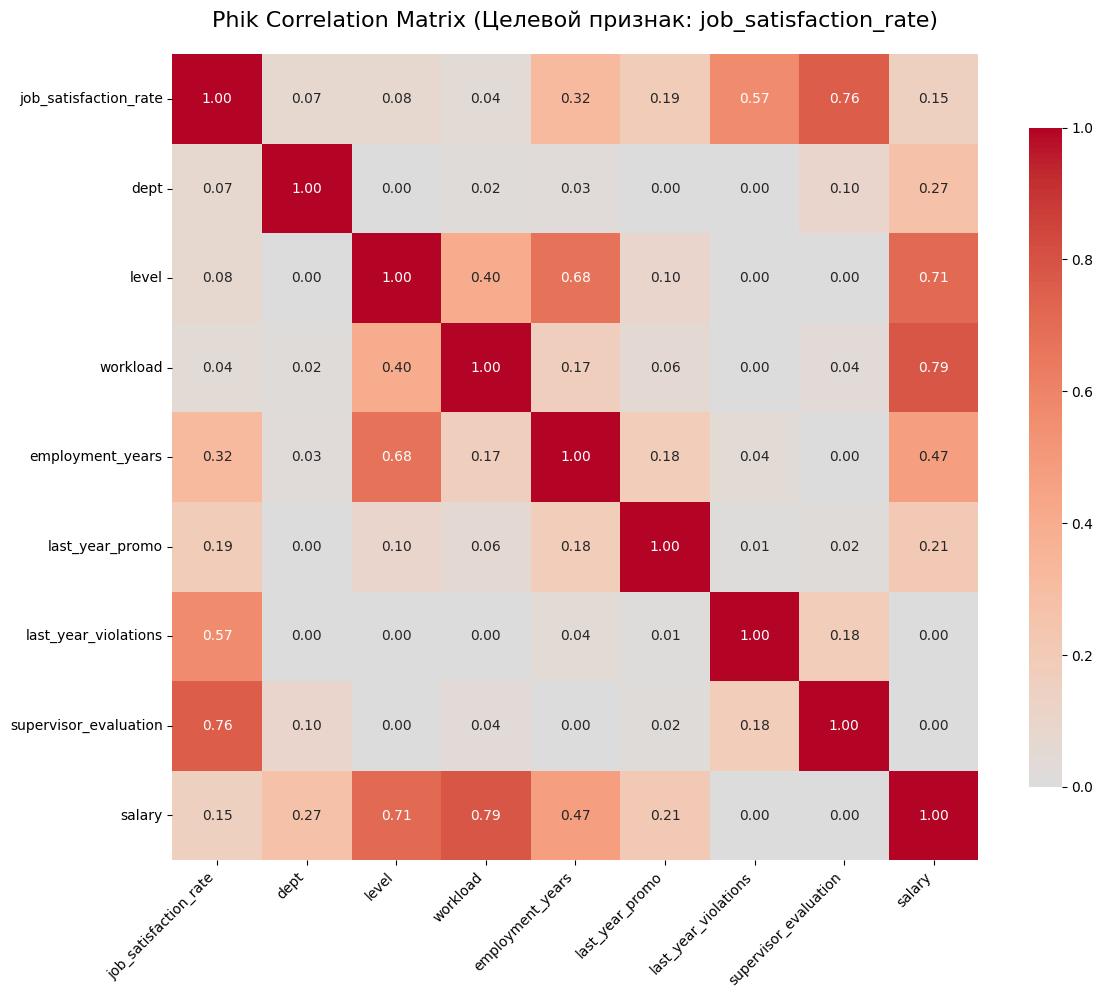


Топ-10 признаков по корреляции с 'job_satisfaction_rate':
--------------------------------------------------


,Признак,Phik корреляция,Интерпретация
0,job_satisfaction_rate,1.0000,Целевой признак
1,supervisor_evaluation,0.7630,Сильная
2,last_year_violations,0.5670,Умеренная
3,employment_years,0.3193,Умеренная
4,last_year_promo,0.1915,Слабая связь
5,salary,0.1496,Слабая связь
6,level,0.0773,Слабая связь
7,dept,0.0747,Слабая связь
8,workload,0.0440,Слабая связь



Топ-10 пар признаков с наибольшей корреляцией (без 'job_satisfaction_rate'):
------------------------------------------------------------


,Признак 1,Признак 2,Phik корреляция,Интерпретация
0,workload,salary,0.7853,Сильная
1,level,salary,0.7144,Сильная
2,level,employment_years,0.6755,Умеренная
3,employment_years,salary,0.4700,Умеренная
4,level,workload,0.4045,Умеренная
5,dept,salary,0.2702,Слабая связь
6,last_year_promo,salary,0.2112,Слабая связь
7,last_year_violations,supervisor_evaluation,0.1832,Слабая связь
8,employment_years,last_year_promo,0.1808,Слабая связь
9,workload,employment_years,0.1659,Слабая связь


In [45]:
# Выведем матрицу корреляции и статистику
plot_phik_correlation(train_satisfaction, target_col='job_satisfaction_rate')

<div style="background-color: white; border: 1.5px solid crimson; border-radius: 10px; padding: 15px 25px; display: inline-block; color: black;">

### Вывод

---

С ЦЕЛЕВЫМ ПРИЗНАКОМ `job_satisfaction_rate`

<span style="color:cornflowerblue"> Очень сильная связь (0.7-1): <span style="color:black"> `supervisor_evaluation`	0.76

Оценка руководителя тесно связана с уровнем удовлетворенности работой.

<span style="color:cornflowerblue"> Сильная связь (0.5-0.7): <span style="color:black">`last_year_violations`	0.56

Признак демонстрирует сильную положительную корреляцию. Интересно, что нарушения в прошлом году связаны с удовлетворенностью, возможно, из-за повышенного внимания к таким сотрудникам или других факторов.

<span style="color:cornflowerblue"> Умеренная связь  (0.3-0.5): <span style="color:black">`employment_years` 0.32

Умеренная корреляция у 'employment_years' (0.3256), что говорит о том, что с увеличением стажа работы удовлетворенность несколько возрастает.

<span style="color:cornflowerblue"> Слабые связи (0.1-0.3): <span style="color:black">`last_year_promo` 0.19 и `salary`	0.15

<span style="color:pink"> Незначимые связи (0.0-0.1): <span style="color:black">`dept` 0.07, `level` 0.08 и `workload`	0.04

С ВХОДНЫМ ПРИЗНАКОМ

- Обнаружена <span style="color:cornflowerblue"> Сильная <span style="color:black">корреляция между `'workload'` и `'salary'` (0.79). Это может указывать на то, что высокая нагрузка компенсируется высокой зарплатой, и наоборот.

- Также<span style="color:cornflowerblue"> Сильная <span style="color:black">корреляция между `'level'` и `'salary'` (0.71), что ожидаемо, так как уровень должности обычно определяет уровень зарплаты.

- <span style="color:cornflowerblue">Сильная <span style="color:black"> корреляция между `'level'` и `'employment_years'` (0.68) - чем выше уровень, тем больше стаж работы в компании.

- <span style="color:cornflowerblue">Умеренная <span style="color:black">корреляция между `'employment_years'` и `'salary'` (0.47), а также между `'level'` и `'workload'` (0.40).


---

<span style="color:cornflowerblue"> ВЫСОКАЯ МУЛЬТИКОЛЛИНЕАРНОСТЬ:

- Критической мультиколлениарности с целевым признаком не обнаружено;
- Есть ряд входных признаков с сильной связью. Один из вариантов при обучении модели - исключить некоторые входные признаки -  (спойлер - мы не будем исключать).

---

<div style="border-left: 3px solid yellowgreen; padding-left: 15px; margin: 15px 0;"> 
    
<span style="color:yellowgreen">

РЕЗЮМИРУЕМ 
1. <span style="color:black">Критической мультиколлинеарности между признаками и целевой переменной не обнаружено.
2. <span style="color:black">Наиболее значимым предиктором удовлетворенности работой является оценка руководителя (0.76), что подчеркивает критическую роль менеджмента в формировании лояльности сотрудников.
3. <span style="color:black">Наибольшее негативное влияние на удовлетворенность работой оказывают нарушения дисциплины в прошлом году (0.56). При этом любопытно, что эта связь — положительная, что может указывать на то, что сотрудники, допускающие нарушения, получают больше внимания от руководства или находятся в особых условиях работы.
  
</div>

---

<span style="color:cornflowerblue"> ДАЛЕЕ ВЫПОЛНИМ ПОДГОТОВКУ ДАННЫХ


## ш а г  .4. Подготовка данных


К А Т Е Г О Р И А Л Ь Н Ы Е (6 из 9):

- `dept` - 5 категорий
- `level` - 3 категории (ordinal)
- `workload` - 3 категории (ordinal)
- `last_year_promo` - 2 категории (бинарный)
- `last_year_violations` - 2 категории (бинарный)
- `supervisor_evaluation` - 5 категорий (ordinal)

К О Л И Ч Е С Т В Е Н Н Ы Е (3 из 9):

**Дискретные**

- `employment_years` - 10 значений (1-10 лет)

**Непрерывные**

- `salary` - правосторонняя асимметрия
- `job_satisfaction_rate` - 0-1, левосторонняя асимметрия

#### <span style="color:royalblue">Функция. Из дискретного признака в категориальный

In [46]:
def to_category(employment_years_list):
    employment_years_category = []
    for year in employment_years_list:
        if year < 3:
            employment_years_category.append('до 2 лет')
        elif 3 <= year < 6:
            employment_years_category.append('от 3 до 5 лет')
        else:
            employment_years_category.append('от 6 до 10 лет')
    
    return employment_years_category

In [47]:
# Добавляем новый признак
train_satisfaction['employment_years_category'] = to_category(train_satisfaction['employment_years'])
test_features['employment_years_category'] = to_category(test_features['employment_years'])
test_features.head()

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,employment_years_category
id,,,,,,,,,
100298,hr,junior,low,2,no,no,4,19200,до 2 лет
100480,marketing,junior,low,4,no,no,4,16800,от 3 до 5 лет
100503,purchasing,middle,high,5,no,no,4,55200,от 3 до 5 лет
100610,sales,middle,medium,5,no,no,4,43200,от 3 до 5 лет
100692,sales,middle,high,6,no,no,4,48000,от 6 до 10 лет


In [48]:
# Датасеты для подготовки данных
test_features = test_features.sort_index()
test_target_satisfaction = test_target_satisfaction.sort_index()

X_train =  train_satisfaction.drop(['job_satisfaction_rate'
                                    #,'employment_years'
                                    #,'workload'
                                    #,'supervisor_evaluation'
                                    #,'last_year_violations'
                                    #,'last_year_promo'
                                   ], axis=1)
y_train = train_satisfaction['job_satisfaction_rate']

X_test = test_features
y_test = test_target_satisfaction['job_satisfaction_rate']

print(f'Размерность X_train: {X_train.shape}')
print(f'Размерность y_train: {y_train.shape}')

print(f'Размерность X_test: {X_test.shape}')
print(f'Размерность y_test: {y_test.shape}')

Размерность X_train: (3755, 9)
Размерность y_train: (3755,)
Размерность X_test: (2000, 9)
Размерность y_test: (2000,)


#### <span style="color:royalblue">Функция. Пользовательской метрики 

In [49]:
def smape(y_true, y_pred, **kwargs):
    
     #**kwargs добавлен для обработки дополнительных параметров от scikit-learn
    
    y_true = np.array(y_true, dtype=np.float64)
    y_pred = np.array(y_pred, dtype=np.float64)
    
    denominator = np.abs(y_true) + np.abs(y_pred)
    smape_terms = np.where(denominator > 0, 2 * np.abs(y_true - y_pred) / denominator, 0.0)
    
    return 100 * np.mean(smape_terms)

In [50]:
# Создаем пользовательскую метрику
smape_scorer = make_scorer(smape, greater_is_better=False)

<div style="border-left: 3px solid pink; padding-left: 15px; margin: 15px 0;">

---

Целевой признак `job_satisfaction_rate`

---

<span style="color:cornflowerblue"> Кодируем с помощью `OneHotEncoder`

- `dept`
- `last_year_promo` 
- `last_year_violations`
- `employment_years_category`

<span style="color:cornflowerblue"> Кодируем с помощью `OrdinalEncoder`

- `level`
- `workload`
  
<span style="color:cornflowerblue"> Масштабируем

- `salary`
- `supervisor_evaluation`
- `employment_years` 

In [51]:
# создаём списки с названиями признаков
ohe_columns = [
               'dept',
               'last_year_promo',
               'last_year_violations',
               'employment_years_category'
                ]
ord_columns = [
                'level' 
                ,'workload'
                #,'supervisor_evaluation'
                ]
num_columns = [ 
               'salary'
               ,'supervisor_evaluation'
               ,'employment_years'         
              ] 
# создаём пайплайн для подготовки признаков из списка ohe_columns: заполнение пропусков и OHE-кодирование
# SimpleImputer + OHE

# создаём пайплайн для подготовки признаков из списка ohe_columns
ohe_pipe = ImbPipeline([
                        ('simpleImputer_ohe', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
                        ('ohe', OneHotEncoder(drop='first', handle_unknown='ignore'))
                        ])

# создаём пайплайн для подготовки признаков из списка ord_columns
ord_pipe = ImbPipeline([
                        ('simpleImputer_before_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
                        ('ord', OrdinalEncoder(
                                               categories=[
                                                           ['junior', 'middle', 'senior']
                                                           ,['low', 'medium', 'high']
                                                           #,[1, 2, 3, 4, 5]
                                                          ],
                                               handle_unknown='error'
                                               #unknown_value=np.nan
                                               )),
                        ('simpleImputer_after_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent'))
                       ])

# создаём общий пайплайн для подготовки данных
data_preprocessor = ColumnTransformer([ 
                                       ('ohe', ohe_pipe, ohe_columns),
                                       ('ord', ord_pipe, ord_columns),
                                       ('num', MinMaxScaler(), num_columns)
                                      ], remainder='passthrough')

<div style="background-color: white; border: 1.5px solid crimson; border-radius: 10px; padding: 15px 25px; display: inline-block; color: black;">

### Вывод

---

<span style="color:cornflowerblue">
    
- <span style="color:black">Добавили новый признак `employment_years_category` 
- <span style="color:black">Подготовили датасеты `X_train`, `y_train`, `X_test`, `y_test`
- <span style="color:black">Написали функцию пользовательской метрики `SMAPE`
- <span style="color:black">Создали пайплайн подкготовки данных `data_preprocessor`

---

ДАЛЕЕ ОБУЧИМ МОДЕЛЬ, ВЫБЕРЕМ ЛУЧШУЮ (ВЫБЕРЕМ ПО МЕТРИКЕ SMAPE) И ОЦЕНИМ ВАЖНОСТЬ ПРИЗНАКОВ

## ш а г  .5. Обучение моделей

In [52]:
pipe_final = Pipeline([
                        ('preprocessor', data_preprocessor),
                        ('models', HistGradientBoostingRegressor(random_state=RANDOM_STATE))
                      ])
param_grid = [
                # LinearRegression
              {
               'models': [LinearRegression()],  # random_state не нужен
               'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler(), 'passthrough'] 
              },            
    
               # DecisionTreeRegressor
              {
               'models': [DecisionTreeRegressor(random_state=RANDOM_STATE)],
               'models__max_depth': [2, 5, 8, 10, None], # ограничение уровня. тесты:[2, 3] [3, 5, 7, 10]
               'models__max_features': ['sqrt', 'log2', None],
               'models__min_samples_leaf': [1, 2, 4, 8], #минимальное число образцов в листе
               'models__min_samples_split': [2, 4, 6, 8], #минимальное число образцов для разделения узла
               'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler(), 'passthrough']
               },            
    
              # HistGradientBoostingRegressor
             {
              'models': [HistGradientBoostingRegressor(random_state=RANDOM_STATE)],
              'models__max_depth': [2, 3, None], # тесты: [3, 5, 7],
              'models__learning_rate': [0.01, 0.05, 0.1], #насколько сильно каждое новое дерево влияет на результат
              'models__max_iter': [100, 200, 300], #количество деревьев (итераций бустинга)
              'models__categorical_features': [[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]],
              'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler(), 'passthrough']   
              },       
    
              # RandomForestRegressor
             {
              'models': [RandomForestRegressor(random_state=RANDOM_STATE)],
              'models__max_depth': [2, 3], # тесты:[None, 5, 10, 15],
              'models__n_estimators': [100, 200, 300],  #количество деревьев в лесу
              'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler(), 'passthrough']
             }
            ]

'''randomized_search = RandomizedSearchCV(
                                       pipe_final, 
                                       param_grid, 
                                       cv=5,
                                       scoring=smape_scorer,
                                       random_state=RANDOM_STATE,
                                       n_jobs=-1,
                                       n_iter=10,  # Уменьшим для скорости
                                       #verbose=1,
                                       error_score='raise'  # Чтобы видеть конкретные ошибки
                                       )
randomized_search.fit(X_train, y_train)


print('\nЛучшая модель и её параметры:\n\n', randomized_search.best_estimator_)
print(f'Метрика SMAPE лучшей модели на кросс-валидации: {-randomized_search.best_score_:.2f}%')

# проверим работу модели на тестовой выборке
y_test_pred = randomized_search.predict(X_test)
smape_test = smape(y_test, y_test_pred)
print(f'\nМетрика SMAPE на тестовой выборке: {smape_test:.2f}%')'''

grid_search = GridSearchCV(
                           pipe_final, 
                           param_grid, 
                           cv=5,
                           scoring=smape_scorer,
                           n_jobs=-1,
                           error_score='raise'
                           )
grid_search.fit(X_train, y_train)
print('\nЛучшая модель и её параметры:\n\n', grid_search.best_estimator_)
print(f'Метрика SMAPE лучшей модели на кросс-валидации: {-grid_search.best_score_:.2f}%')


Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore'))]),
                                                  ['dept', 'last_year_promo',
                                                   'last_year_violations',
                                                   'employment_years_category']),
                                                 ('ord',
                                                 

In [53]:
# проверим работу модели на тестовой выборке
y_test_pred = grid_search.predict(X_test)
print(y_test_pred)
y_test = y_test.sort_index()
X_test = X_test.sort_index()
smape_test = smape(y_test, y_test_pred)
print('--' * 50)
print(f'\nМетрика SMAPE на тестовой выборке: {smape_test:.2f}%')
print('--' * 50)

[0.8380889  0.84354979 0.81635353 ... 0.49118616 0.46629982 0.31018669]
----------------------------------------------------------------------------------------------------

Метрика SMAPE на тестовой выборке: 10.66%
----------------------------------------------------------------------------------------------------


In [54]:
# Выведем реультаты
pd.set_option('display.max_colwidth', None) # Установим максимальную ширину столбцов на None, чтобы убрать ограничение

result = pd.DataFrame(grid_search.cv_results_)
display(result[
                ['rank_test_score', 'param_models', 'mean_test_score','params']
              ].sort_values('rank_test_score').head()) 

,rank_test_score,param_models,mean_test_score,params
1068,1,HistGradientBoostingRegressor(random_state=42),-11.6903,"{'models': HistGradientBoostingRegressor(random_state=42), 'models__categorical_features': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9], 'models__learning_rate': 0.1, 'models__max_depth': None, 'models__max_iter': 300, 'preprocessor__num': StandardScaler()}"
1070,2,HistGradientBoostingRegressor(random_state=42),-11.6908,"{'models': HistGradientBoostingRegressor(random_state=42), 'models__categorical_features': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9], 'models__learning_rate': 0.1, 'models__max_depth': None, 'models__max_iter': 300, 'preprocessor__num': RobustScaler()}"
1071,2,HistGradientBoostingRegressor(random_state=42),-11.6908,"{'models': HistGradientBoostingRegressor(random_state=42), 'models__categorical_features': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9], 'models__learning_rate': 0.1, 'models__max_depth': None, 'models__max_iter': 300, 'preprocessor__num': 'passthrough'}"
1069,2,HistGradientBoostingRegressor(random_state=42),-11.6908,"{'models': HistGradientBoostingRegressor(random_state=42), 'models__categorical_features': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9], 'models__learning_rate': 0.1, 'models__max_depth': None, 'models__max_iter': 300, 'preprocessor__num': MinMaxScaler()}"
1064,5,HistGradientBoostingRegressor(random_state=42),-11.6995,"{'models': HistGradientBoostingRegressor(random_state=42), 'models__categorical_features': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9], 'models__learning_rate': 0.1, 'models__max_depth': None, 'models__max_iter': 200, 'preprocessor__num': StandardScaler()}"


In [55]:
data_preprocessor_final = ColumnTransformer(
                                            [('ohe', ohe_pipe, ohe_columns),
                                             ('ord', ord_pipe, ord_columns),
                                             ('num', StandardScaler(), num_columns)
                                            ], 
                                            remainder='passthrough'
                                            )
pipe_final_model = Pipeline([
                            ('preprocessor', data_preprocessor_final),
                            ('models', HistGradientBoostingRegressor(categorical_features = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9], 
                                                                     learning_rate = 0.1, 
                                                                     max_depth = None, 
                                                                     max_iter= 300, 
                                                                     random_state=42))
                                                                      
                             ])
pipe_final_model.fit(X_train, y_train)

# ПОПРАВИЛА
X_train_p2 = pd.DataFrame(
                        data_preprocessor_final.transform(X_train),
                        columns=data_preprocessor_final.get_feature_names_out()
                        )

X_test_p = pd.DataFrame(
                        data_preprocessor_final.transform(X_test),
                        columns=data_preprocessor_final.get_feature_names_out()
                        )
modeling_df_predict_p = pd.DataFrame(
                        data_preprocessor_final.transform(X_test)
                        )

In [ ]:
explainer = shap.SamplingExplainer(lambda x: pipe_final_model.named_steps['models'].predict(x), X_train_p2)
shap_values = explainer.shap_values(X_test_p)

  0%|          | 0/2000 [00:00<?, ?it/s]

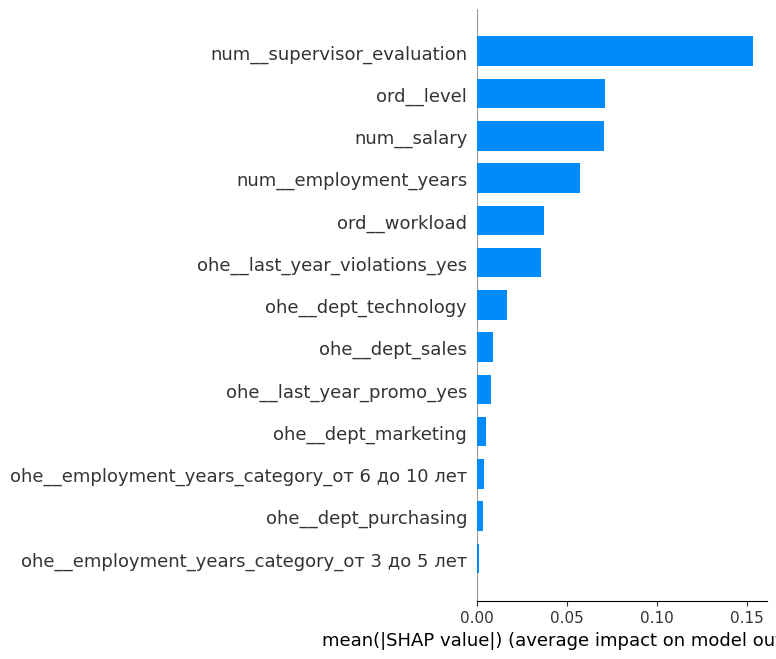

In [92]:
# Визуализация признаков, которые модель посчитала за "важные"
shap.summary_plot(shap_values, X_train_p2, plot_type='bar', max_display=17)

## ш а г  .6. Выводы

<div style="background-color: white; border: 4px solid yellowgreen; border-radius: 10px; padding: 15px 25px; display: inline-block; color: black;">

<span style="color:cornflowerblue"> ЛУЧШАЯ МОДЕЛЬ: <span style="color:black"> **HistGradientBoostingRegressor**

<span style="color:cornflowerblue"> ЛУЧШИЙ РЕЗУЛЬТАТ:  <span style="color:black"> SMAPE= 11.69%

<span style="color:cornflowerblue"> ПАРАМЕТРЫ ЛУЧШЕЙ МОДЕЛИ: 

- `RobustScaler`, 
- `categorical_features` : [0, 1, 2, 3, 4, 5, 6, 7, 8, 9], 
- `learning_rate` = 0.1,
- `max_depth` : None,
- `max_iter` = 300

<span style="color:cornflowerblue"> Качество модели:

- Тренеровочная выборка SMAPE = 11.69%
- Тестовая выборка SMAPE = 10.66%
  
---

<span style="color:cornflowerblue"> 

ВАЖНОСТЬ ПРИЗНАКОВ МОДЕЛИ

<span style="color:crimson"> ТОП-5 [Сильнее всего влияют на целевой признак]

- `supervisor_evaluation` [Оценка руководителя]

<span style="color:black"> Самый важный фактор удовлетворённости. Качество менеджмента напрямую влияет на удержание сотрудников. Важно провести дополнительную работу с руководителями/провести обучение руководителей, внедрить регулярную обратную связь о стиле управления и т.п.

- `level` [Уровень]

<span style="color:black">Уровень сотрудника влияет сильнее, чем зарплата (2-е место vs 3-е). Сотрудникам важна позиция, статус и развитие. Важно: Чёткая система грейдов, прозрачные критерии повышений.

- `salary` [Зарплата]

<span style="color:black">Материальная мотивация всё ещё важна. Недооценка рынком ведёт к неудовлетворённости. Важно: Регулярный benchmark зарплат, гибкая система премирования.

- `employment_years` [Стаж]

<span style="color:black">Стаж влияет сильнее, чем ожидалось (аж 4-е место). Важно: Разные программы поддержки для новиков (<3 лет) и ветеранов (>5 лет)

- `workload` [Загруженность]

<span style="color:black">Загруженность на 5-м месте — важна, но не критична. Не сама нагрузка, а её справедливость и управляемость. Мониторинг распределения задач, борьба с выгоранием и т.п.

<span style="color:cornflowerblue"> ПРИОРИТЕТ ДЛЯ HR-отдела

- <span style="color:black">Развитие руководителей <span style="color:cornflowerblue"> --> <span style="color:black">Отслеживать Удовлетворённость в разрезе отделов (качество руководства)
-<span style="color:black"> Прозрачная карьерная лестница (удержание амбициозных сотрудников) <span style="color:cornflowerblue"> --> <span style="color:black"> Отслеживать Процент сотрудников, получивших повышение за год
- <span style="color:black">Конкурентные зарплаты <span style="color:cornflowerblue"> --> <span style="color:black">Отслеживать Отклонение зарплат от рынка

---

<div style="border-left: 3px solid #6495ED; padding-left: 15px; margin: 15px 0;">

<span style="color:black">Удовлетворённость сотрудников — это системная характеристика, а не результат разовых акций. Фокус на качестве управления и карьерных возможностях даёт больший эффект, чем материальные стимулы (хотя они тоже важны).

# З А Д А Ч А № 2

<div style="border-left: 3px solid royalblue; padding-left: 15px; margin: 15px 0;"> 
  
Предсказание увольнения сотрудника из компании

In [93]:
# 1. Тренировочные данные с целевым признаком увольнения
train_quit = import_google_sheet(
                                 spreadsheet_id='1aGN9rdl8MPrsL3UF2i7w4kC0lUxw_u4tdzQ7glYX4oE',  # ID Google таблицы с train_quit
                                 local_paths=[
                                              '/data/train_quit.csv',
                                              'C:/projects/data/train_quit.csv', # Windows путь
                                              './data/train_quit.csv'
                                             ]
                                 )
# 2. Тестовые данные (признаки) - ТА ЖЕ ТАБЛИЦА, что и в задаче 1!
test_features_2 = import_google_sheet(
                                    spreadsheet_id='1swW4KlgOoHz0RUI9ZVH78nM3iE5SEyBY9nJm68iG_lU',  # ID Google таблицы с test_features
                                    local_paths=[
                                                 '/data/test_features.csv',
                                                 'C:/projects/data/test_features.csv',
                                                 './data/test_features.csv' 
                                                 ]
                                     )

# 3. Истинные значения увольнения для тестовой выборки  
test_target_quit = import_google_sheet(
                                       spreadsheet_id='1peKh7CwivGrLpdCrMQjrQ0QDxW6XeHSDXqmgKG2LadE',  # ID Google таблицы с test_target_quit
                                       local_paths=[
                                                    '/data/test_target_quit.csv',
                                                    'C:/projects/data/test_target_quit.csv', # Windows путь
                                                    './data/test_target_quit.csv'
                                                   ]
                                       )

Загружаем из Google Sheets: https://docs.google.com/spreadsheets/d/1aGN9rdl8MPrsL3UF2i7w4kC0lUxw_u4tdzQ7glYX4oE/export?format=csv
Загружаем из Google Sheets: https://docs.google.com/spreadsheets/d/1swW4KlgOoHz0RUI9ZVH78nM3iE5SEyBY9nJm68iG_lU/export?format=csv
Загружаем из Google Sheets: https://docs.google.com/spreadsheets/d/1peKh7CwivGrLpdCrMQjrQ0QDxW6XeHSDXqmgKG2LadE/export?format=csv


In [94]:
# Устанавливаем 'id' как индекс для данных
train_quit.set_index('id', inplace=True)
test_features_2.set_index('id', inplace=True)
test_target_quit.set_index('id', inplace=True)

# Сортируем тестовые признаки по индексу
test_features_2 = test_features.sort_index()
test_target_quit = test_target_quit.sort_index()

## ш а г  .1. Загрузка данных

### Таблица `train_quit`

In [95]:
head_and_info_display(train_quit)

~~~~~~~~~~~~~~~~~~~~~~~
ИНФОРМАЦИЯ О ДАТАФРЕЙМЕ
~~~~~~~~~~~~~~~~~~~~~~~
Форма данных: 4000 строк, 9 столбцов

НАЗВАНИЯ СТОЛБЦОВ (9 шт.):
------------------------------
 1. dept
 2. level
 3. workload
 4. employment_years
 5. last_year_promo
 6. last_year_violations
 7. supervisor_evaluation
 8. salary
 9. quit

Первые 5 строк:
---------------


,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit
id,,,,,,,,,
723290,sales,middle,high,2,no,no,4,54000,no
814010,sales,junior,medium,2,no,no,4,27600,no
155091,purchasing,middle,medium,5,no,no,1,37200,no
257132,sales,junior,medium,2,no,yes,3,24000,yes
910140,marketing,junior,medium,2,no,no,5,25200,no



Общая информация:
-----------------
<class 'pandas.core.frame.DataFrame'>
Index: 4000 entries, 723290 to 853842
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   dept                   4000 non-null   object
 1   level                  4000 non-null   object
 2   workload               4000 non-null   object
 3   employment_years       4000 non-null   int64 
 4   last_year_promo        4000 non-null   object
 5   last_year_violations   4000 non-null   object
 6   supervisor_evaluation  4000 non-null   int64 
 7   salary                 4000 non-null   int64 
 8   quit                   4000 non-null   object
dtypes: int64(3), object(6)
memory usage: 312.5+ KB

ПРОПУЩЕННЫЕ ЗНАЧЕНИЯ:
------------------------------
Пропущенных значений нет

ПРОВЕРКА ЯВНЫХ ДУБЛИКАТОВ:
--------------------
Найдено 1413 дубликатов строк (35.33% данных)


In [96]:
# Дропаем дубликаты
train_quit = train_quit.drop_duplicates()
train_quit.shape

(2587, 9)

<div style="background-color: white; border: 2px solid royalblue; border-radius: 0px; padding: 15px 25px; display: inline-block; color: black;">

<span style="color:yellowgreen">ПРЕДВАРИТЕЛЬНАЯ ОЦЕНКА ДАННЫХ 

<span style="color:crimson">
    
- <span style="color:black">Пропущенных значений нет. Типы данных верные;
- <span style="color:black">Найдено 1413 явных дубликатов строк (35%) - удалили;
- <span style="color:black">В таблице `train_quit` 2587 строк и 9 столбцов.

### Таблица `test_target_quit`

In [97]:
head_and_info_display(test_target_quit)

~~~~~~~~~~~~~~~~~~~~~~~
ИНФОРМАЦИЯ О ДАТАФРЕЙМЕ
~~~~~~~~~~~~~~~~~~~~~~~
Форма данных: 2000 строк, 1 столбцов

НАЗВАНИЯ СТОЛБЦОВ (1 шт.):
------------------------------
 1. quit

Первые 5 строк:
---------------


,quit
id,
100298,no
100480,no
100503,no
100610,no
100692,no



Общая информация:
-----------------
<class 'pandas.core.frame.DataFrame'>
Index: 2000 entries, 100298 to 999029
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   quit    2000 non-null   object
dtypes: object(1)
memory usage: 31.2+ KB

ПРОПУЩЕННЫЕ ЗНАЧЕНИЯ:
------------------------------
Пропущенных значений нет

ПРОВЕРКА ЯВНЫХ ДУБЛИКАТОВ:
--------------------
Найдено 1998 дубликатов строк (99.90% данных)


<div style="background-color: white; border: 2px solid royalblue; border-radius: 0px; padding: 15px 25px; display: inline-block; color: black;">

<span style="color:yellowgreen">ПРЕДВАРИТЕЛЬНАЯ ОЦЕНКА ДАННЫХ 

- В таблице `test_target_quit` 2000 строк и 1 столбец.
- Пропущенных значений нет. Типы данных верные.

<div style="background-color: white; border: 1.5px solid crimson; border-radius: 10px; padding: 15px 25px; display: inline-block; color: black;">

---

### Вывод

<span style="color:cornflowerblue"> В ДАННОМ РАЗДЕЛЕ МЫ ЗНАКОМИЛИСЬ С ДАННЫМИ И ПЕРВИЧНО ИХ ОЦЕНИЛИ.

---    

<span style="color:crimson">
  
- <span style="color:black">  В таблице `train_quit` 2587 записей и 9 столбцов.

 1. <span style="color:black">  Пропущенных значений нет. 
 2. <span style="color:black">  Нашли и удалили 1413 явных дубликата (35%).
 3. <span style="color:black">  Типы данных верные.

- <span style="color:black">  В таблице `test_target_quit` 2000 записей и 1 столбец.

1. <span style="color:black">   Пропущенных значений нет.
2. <span style="color:black"> Типы данных верные.

---
    
<span style="color:cornflowerblue">ДАЛЕЕ ПРОВЕДЁМ ПРЕДОРАБОТКУ ДАННЫХ: 

- <span style="color:black">  Проверим данные на неявные дубликаты и некорректные значения,

## ш а г  .2. Предобработка данных

### Работа с неявными дубликатами

In [98]:
# Выявляем
show_unique_simple(train_quit=train_quit, test_features_2=test_features_2)


--- train_quit ---
dept: ['sales', 'purchasing', 'marketing', 'technology', 'hr']
level: ['middle', 'junior', 'sinior']
workload: ['high', 'medium', 'low']
last_year_promo: ['no', 'yes']
last_year_violations: ['no', 'yes']
quit: ['no', 'yes']

--- test_features_2 ---
dept: ['hr', 'marketing', 'purchasing', 'sales', 'technology', nan]
level: ['junior', 'middle', 'senior', nan]
workload: ['low', 'high', 'medium', nan]
last_year_promo: ['no', 'yes']
last_year_violations: ['no', 'yes']
employment_years_category: ['до 2 лет', 'от 3 до 5 лет', 'от 6 до 10 лет']


In [99]:
# Заменяем некорректные значения
train_quit['level'] = train_quit['level'].str.replace('sinior', 'senior')

In [100]:
# Проверяем
show_unique_simple(train_quit=train_quit, test_features_2=test_features_2)


--- train_quit ---
dept: ['sales', 'purchasing', 'marketing', 'technology', 'hr']
level: ['middle', 'junior', 'senior']
workload: ['high', 'medium', 'low']
last_year_promo: ['no', 'yes']
last_year_violations: ['no', 'yes']
quit: ['no', 'yes']

--- test_features_2 ---
dept: ['hr', 'marketing', 'purchasing', 'sales', 'technology', nan]
level: ['junior', 'middle', 'senior', nan]
workload: ['low', 'high', 'medium', nan]
last_year_promo: ['no', 'yes']
last_year_violations: ['no', 'yes']
employment_years_category: ['до 2 лет', 'от 3 до 5 лет', 'от 6 до 10 лет']


### Работа с явными дубликатами

In [101]:
cnt_duplicates(train_quit=train_quit, test_target_qui=test_target_quit)

train_quit: Кол-во дублей: 0
test_target_qui: Кол-во дублей: 1998


<div style="background-color: white; border: 1.5px solid crimson; border-radius: 10px; padding: 15px 25px; display: inline-block; color: black;">

---

### Вывод

<span style="color:cornflowerblue"> В ДАННОМ РАЗДЕЛЕ МЫ ПРОВЕЛИ ПЕРВИЧНЫЕ АНАЛИЗ И ПОЗНАКОМИЛИСЬ С ДАННЫМИ ПОБЛИЖЕ.

---

<span style="color:crimson">
  
<span style="color:black">  В таблицах `train_quit`, `test_target_quit`:

- <span style="color:black">  Неявных дубликатов **не обнаружено**
- <span style="color:black">  Явных дубликатов **не обнаружено**
- <span style="color:black">  Устранили некорректные значения в столбце `level` - поменяли `sinior` на `senior`

---
    
<span style="color:cornflowerblue"> ДАЛЕЕ ПРИСТУПИМ К ИССЛЕДОВАТЕЛЬСКОМУ АНАЛИЗУ ДАННЫХ

- <span style="color:black">   Разделим данные на колличесвенные и качественные, посмотрим на распределения значений в данных, построив графики для каждого признака.
    
    - <span style="color:black">  Для количественных признаков мы построим: "Ящик с усами" и Гистограмму.
    - <span style="color:black">  Для категориальных признаков мы построим: Столбчатую и круговую диаграммы.

## ш а г  .3. Исследовательский анализ данных

### I Статистика и графики распределений для категориальных и дискретных значений

### Таблица `train_quit`

In [102]:
# Выводим Категориальные и Дискретные количественные столбцы таблицы 'train_quit'
cat_cols, disc_cols = get_column_types(train_quit)
print(f"Категориальные: {cat_cols}")
print(f"Дискретные количественные (>11 уникальных): {disc_cols}")

Категориальные: ['dept', 'level', 'workload', 'last_year_promo', 'last_year_violations', 'quit']
Дискретные количественные (>11 уникальных): ['employment_years', 'supervisor_evaluation']


<div style="border-left: 3px solid royalblue; padding-left: 15px; margin: 15px 0;"> 

#### dept `[отдел, в котором работает сотрудник]`

Статистика для 'dept':
Всего записей: 2587
Уникальных категорий: 5
Самая частая категория: 'sales' (805 записей)
Доля самой частой категории: 31.1%


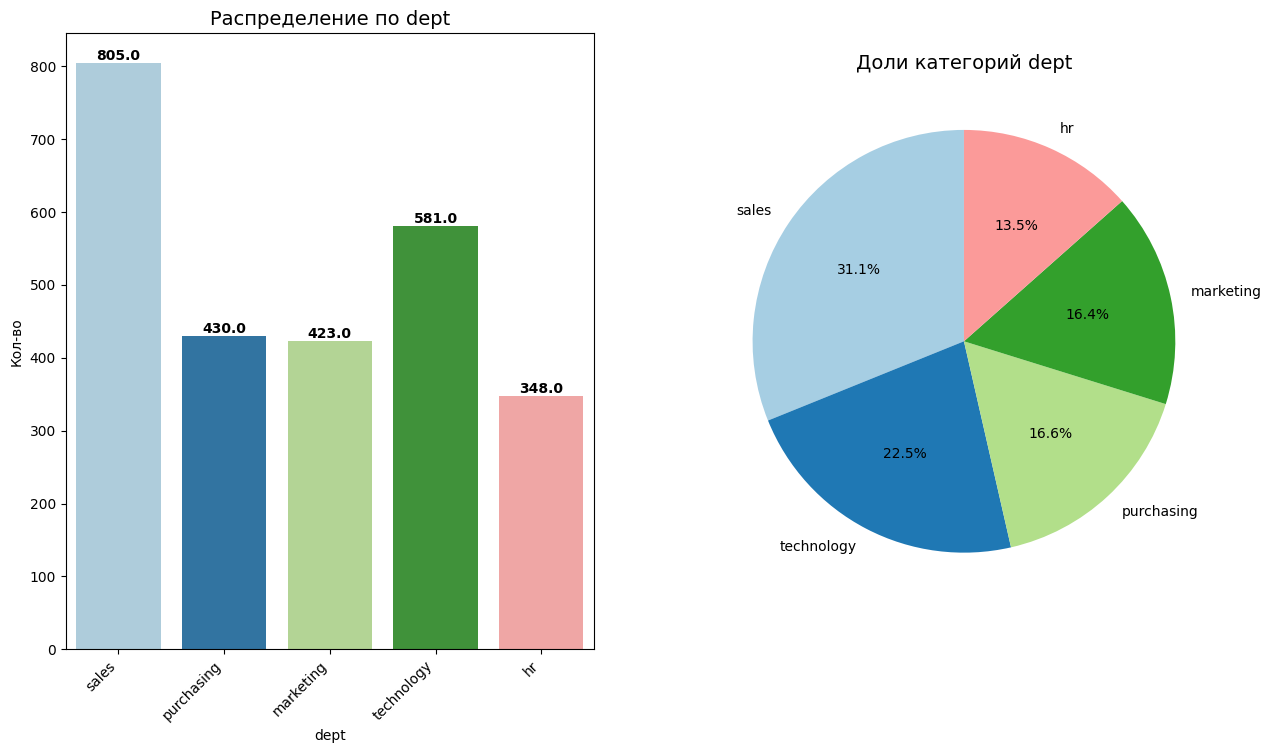

In [103]:
# Столбец 'dept'
plot_categorical(train_quit, column='dept')

<div style="background-color: white; border: 2px solid royalblue; border-radius: 0px; padding: 15px 25px; display: inline-block; color: black;">

По графику распределения категории `dept` видим, что обльшая часть компании в данной таблице - это сотрудники отдела `sales`(1438 записей, 35.9%)

<span style="color:crimson">  

- <span style="color:black">Команда `sales` лидирует во всех выборках
- <span style="color:black">Распределение по отделам в трёх выборках отличаются незначительно (1.9% для sales)

<div style="border-left: 3px solid royalblue; padding-left: 15px; margin: 15px 0;"> 

#### level `[уровень занимаемой должности]`

Статистика для 'level':
Всего записей: 2587
Уникальных категорий: 3
Самая частая категория: 'middle' (1282 записей)
Доля самой частой категории: 49.6%


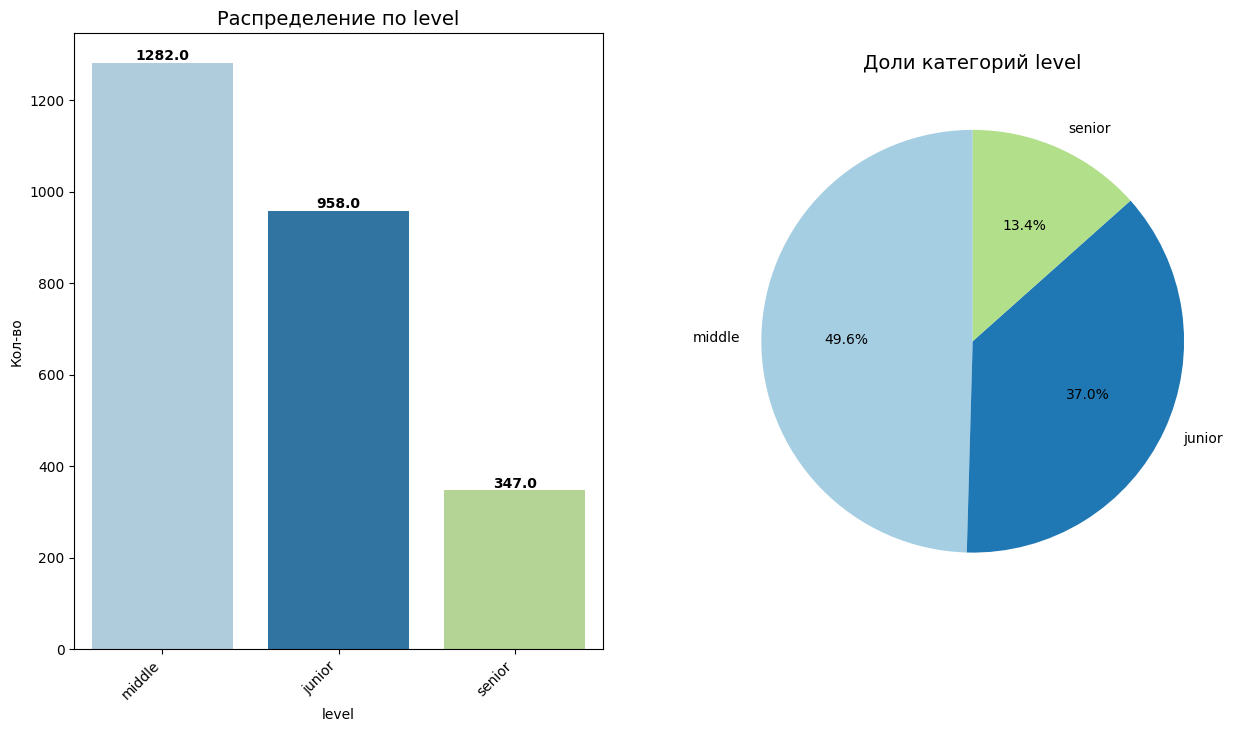

In [104]:
# Столбец 'level'
plot_categorical(train_quit, column='level')

<div style="background-color: white; border: 2px solid royalblue; border-radius: 0px; padding: 15px 25px; display: inline-block; color: black;">

По графику распределения категории `level` видим, что большая часть сотрудников в компании - это сотрудники с уровнем `middle` (1282 записи, доля 49.6%).

<span style="color:crimson">
  
- <span style="color:black">Преобладание специалистов младшего и среднего звена (~90% штата) формирует устойчивый внутренний кадровый резерв, однако соотношение примерно 1 `senior` на 6 подчиненных указывает на возможную перегрузку опытных сотрудников менторскими обязанностями.

<div style="border-left: 3px solid royalblue; padding-left: 15px; margin: 15px 0;"> 

#### workload `[уровень загруженности сотрудника]`

Статистика для 'workload':
Всего записей: 2587
Уникальных категорий: 3
Самая частая категория: 'medium' (1244 записей)
Доля самой частой категории: 48.1%


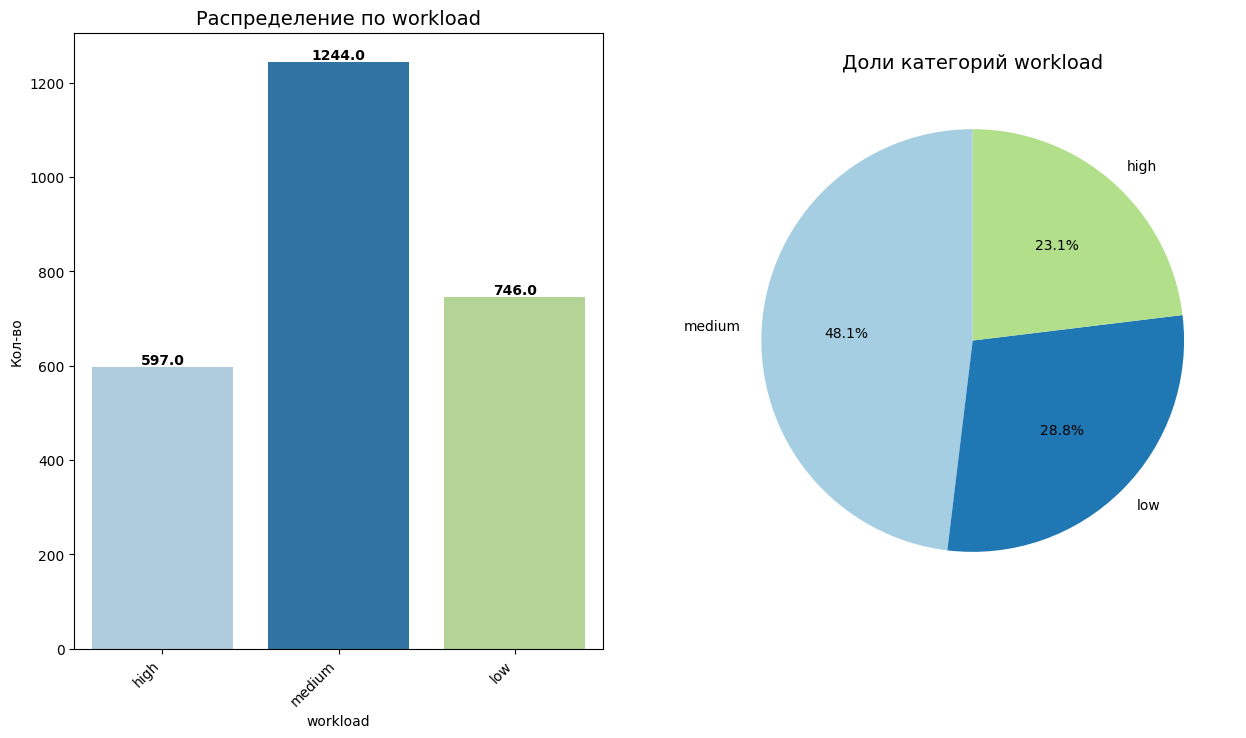

In [105]:
# Столбец 'workload'
plot_categorical(train_quit, column='workload')

<div style="background-color: white; border: 2px solid royalblue; border-radius: 0px; padding: 15px 25px; display: inline-block; color: black;">

По графику распределения категории `workload` видим, что уровень загруженности сотрудников в основном `medium` (1244 записи, доля 48.1%).


<span style="color:crimson">
    

- <span style="color:black">`medium`: 48.1% (1244 сотрудников)
- <span style="color:black">`low`: 28.8%
- <span style="color:black">`high`: 23.1%
  
---


<div style="border-left: 3px solid royalblue; padding-left: 15px; margin: 15px 0;"> 

####  last_year_promo `[было ли повышение за последний год]`

Статистика для 'last_year_promo':
Всего записей: 2587
Уникальных категорий: 2
Самая частая категория: 'no' (2476 записей)
Доля самой частой категории: 95.7%


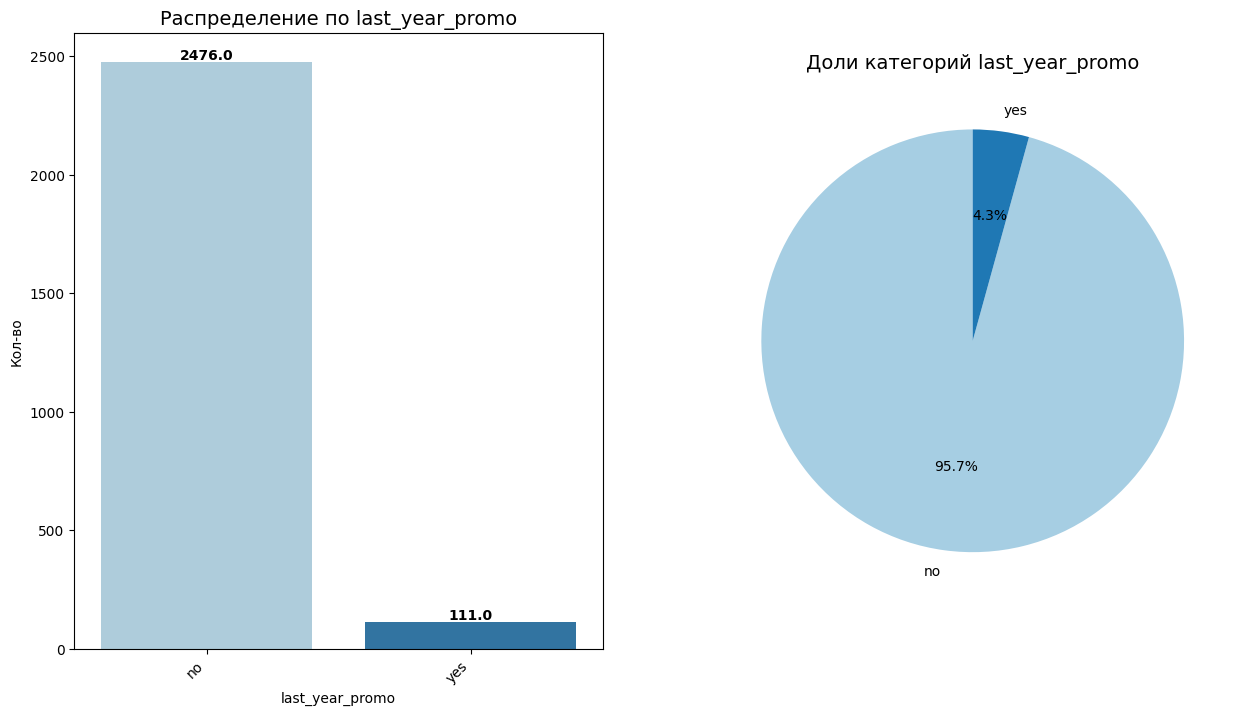

In [106]:
# Столбец 'last_year_promo'
plot_categorical(train_quit, column='last_year_promo')

<div style="background-color: white; border: 2px solid royalblue; border-radius: 0px; padding: 15px 25px; display: inline-block; color: black;">

   
По графику распределения категории `last_year_promo` видим, что самая частая категория - это `no` (2476 записей, доля 95.7%):

<span style="color:crimson">
    

- <span style="color:black">У 4.3% сотрудников было повышения за последний год.
- <span style="color:black">Низкая вероятность повышения может снижать удовлетворенность и повышать вероятность увольнения/выгорания.

<div style="border-left: 3px solid royalblue; padding-left: 15px; margin: 15px 0;"> 

#### last_year_violations `[нарушал ли сотрудник трудовой договор за последний год]`

Статистика для 'last_year_violations':
Всего записей: 2587
Уникальных категорий: 2
Самая частая категория: 'no' (2111 записей)
Доля самой частой категории: 81.6%


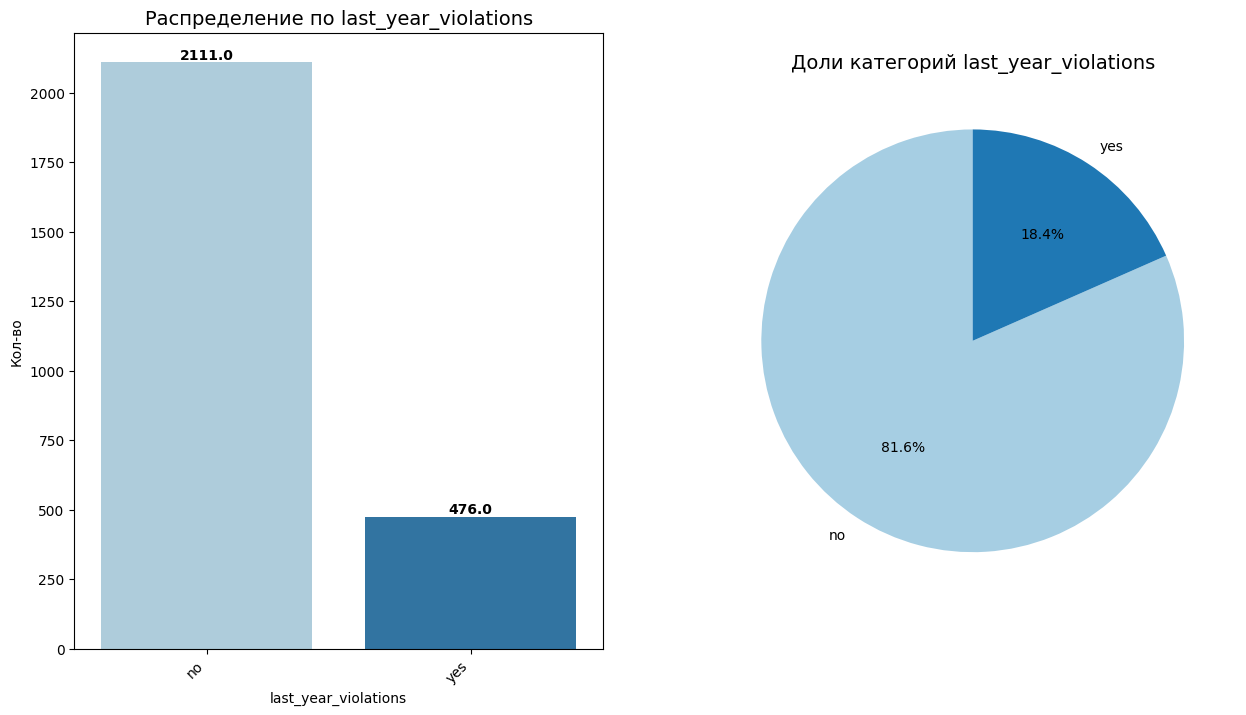

In [107]:
# Столбец 'last_year_violations'
plot_categorical(train_quit, column='last_year_violations')

<div style="background-color: white; border: 2px solid royalblue; border-radius: 0px; padding: 15px 25px; display: inline-block; color: black;">

По графику распределения категории `last_year_violations` видим 18% нарушений в прошлом году - многовато.


<div style="border-left: 3px solid royalblue; padding-left: 15px; margin: 15px 0;"> 

#### quit `[Увольнение]`

Статистика для 'quit':
Всего записей: 2587
Уникальных категорий: 2
Самая частая категория: 'no' (1932 записей)
Доля самой частой категории: 74.7%


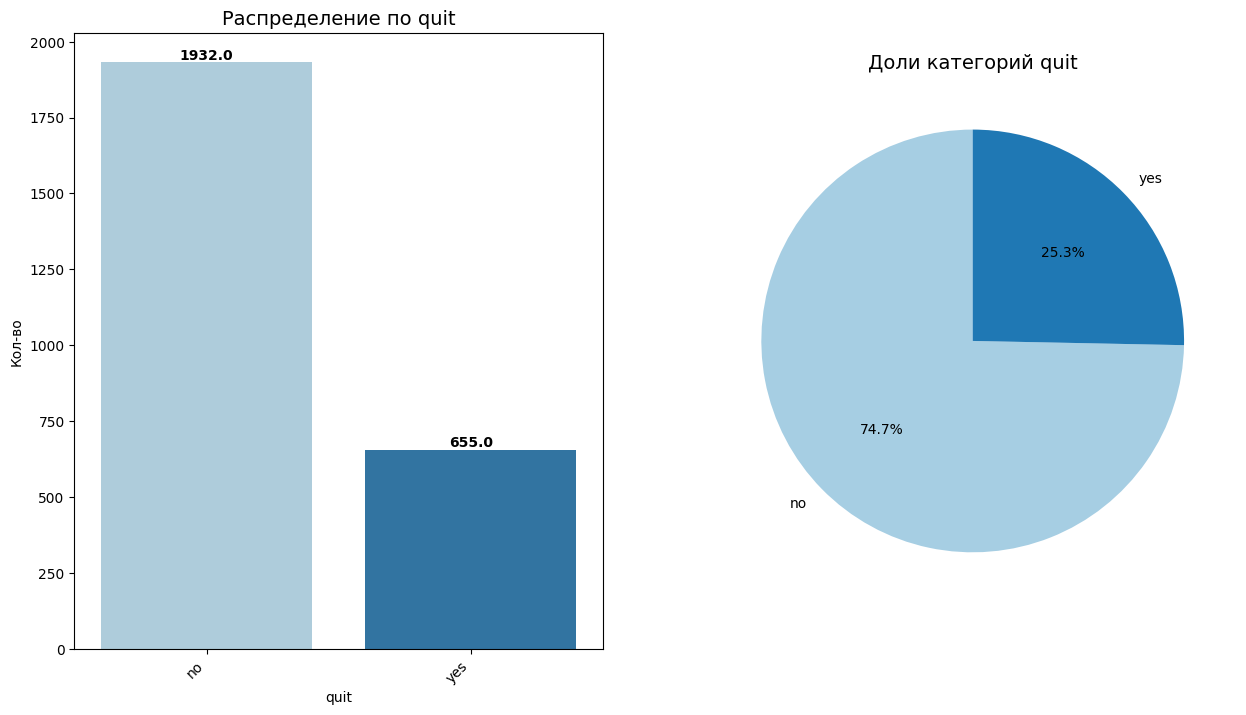

In [108]:
# Столбец 'quit'
plot_categorical(train_quit, column='quit')

<div style="background-color: white; border: 2px solid royalblue; border-radius: 0px; padding: 15px 25px; display: inline-block; color: black;">

По графику распределения категории `quit` видим, что большенство сотрудников  `не уволились` (1932 записи, 74.7%).

<span style="color:crimson">
    

- <span style="color:black"> Наблюдаем значительны уровень кадровой текучки 25.3% (Каждый четвертый покидает компанию).
- <span style="color:black">Дисбаланс достаточный для применения методов работы с несбалансированными данными (но не настолько экстремальный, чтобы затруднять обучение моделей).

---

<span style="color:black">При построении моделей акцентировать внимание на качестве прогнозирования класса увольнения, так как `false negative` (пропуск увольнения) может быть более критичным для бизнеса, чем `false positive`.

<div style="border-left: 3px solid royalblue; padding-left: 15px; margin: 15px 0;"> 

#### employment_years `[длительность работы в компании в годах]`

Статистика для 'employment_years':
Всего записей: 2587
Уникальных категорий: 10
Самая частая категория: '1' (451 записей)
Доля самой частой категории: 17.4%


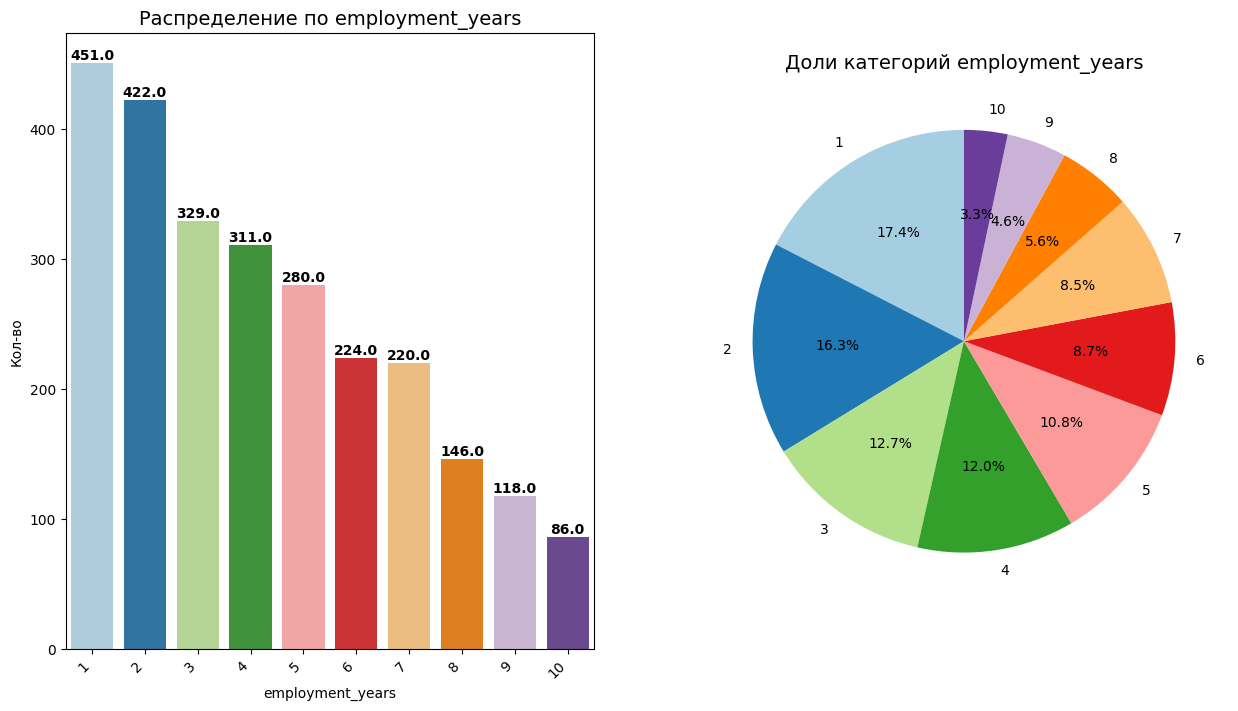

In [109]:
# Столбец 'employment_years'
plot_categorical(train_quit, column='employment_years')

In [110]:
# Создаем новый признак категориальный из дискретного
train_quit['employment_years_category'] = to_category(train_quit['employment_years'])
test_features_2['employment_years_category'] = to_category(test_features_2['employment_years'])
test_features_2.head()

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,employment_years_category
id,,,,,,,,,
100298,hr,junior,low,2,no,no,4,19200,до 2 лет
100480,marketing,junior,low,4,no,no,4,16800,от 3 до 5 лет
100503,purchasing,middle,high,5,no,no,4,55200,от 3 до 5 лет
100610,sales,middle,medium,5,no,no,4,43200,от 3 до 5 лет
100692,sales,middle,high,6,no,no,4,48000,от 6 до 10 лет


<div style="background-color: white; border: 2px solid royalblue; border-radius: 0px; padding: 15px 25px; display: inline-block; color: black;">

По графику распределения категории `employment_years` видим, что большенство сотрудников работают в компании `1 год` (451 запись, 17.4%).

<span style="color:crimson">
    
- <span style="color:black">Распределение практически совпадает с предыдущими выборками (+/- 0.5%)
- <span style="color:black">Высокая доля новичков (34% до 2 лет) подтверждает проблемы с удержанием персонала в первые годы работы.

<div style="border-left: 3px solid royalblue; padding-left: 15px; margin: 15px 0;"> 

#### supervisor_evaluation `[оценка качества работы сотрудника, которую дал руководитель]`

Статистика для 'supervisor_evaluation':
Всего записей: 2587
Уникальных категорий: 5
Самая частая категория: '4' (882 записей)
Доля самой частой категории: 34.1%


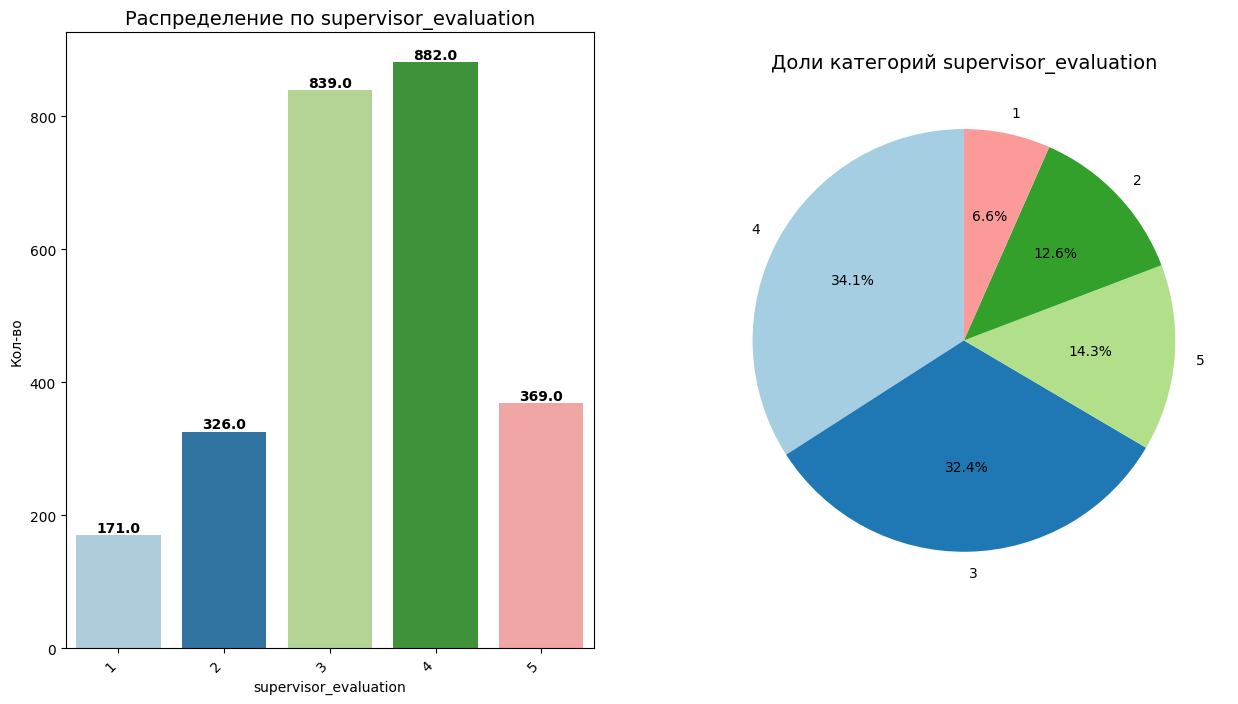

In [111]:
# Столбец 'supervisor_evaluation'
plot_categorical(train_quit, column='supervisor_evaluation')

<div style="background-color: white; border: 2px solid royalblue; border-radius: 0px; padding: 15px 25px; display: inline-block; color: black;">


По графику распределения категории `supervisor_evaluation` видим, что большенству сотрудников, которым руководители дали оценку качества работы `4` (882 записи, 34.1%).

<span style="color:crimson">

- <span style="color:black">Не на много отстала средняя оценка качества работы `3` (839 записей, 32.4%).
- <span style="color:black">Распределение оценок руководителей очень близко к данным из задачи 1


### Таблица `test_target_quit`

In [112]:
# Выводим Категориальные и Дискретные количественные столбцы таблицы 'test_target_quit'
cat_cols, disc_cols = get_column_types(test_target_quit)
print(f"Категориальные: {cat_cols}")
print(f"Дискретные количественные (>11 уникальных): {disc_cols}")

Категориальные: ['quit']
Дискретные количественные (>11 уникальных): []


<div style="border-left: 3px solid royalblue; padding-left: 15px; margin: 15px 0;"> 

#### quit `[Увольнение]`

Статистика для 'quit':
Всего записей: 2000
Уникальных категорий: 2
Самая частая категория: 'no' (1436 записей)
Доля самой частой категории: 71.8%


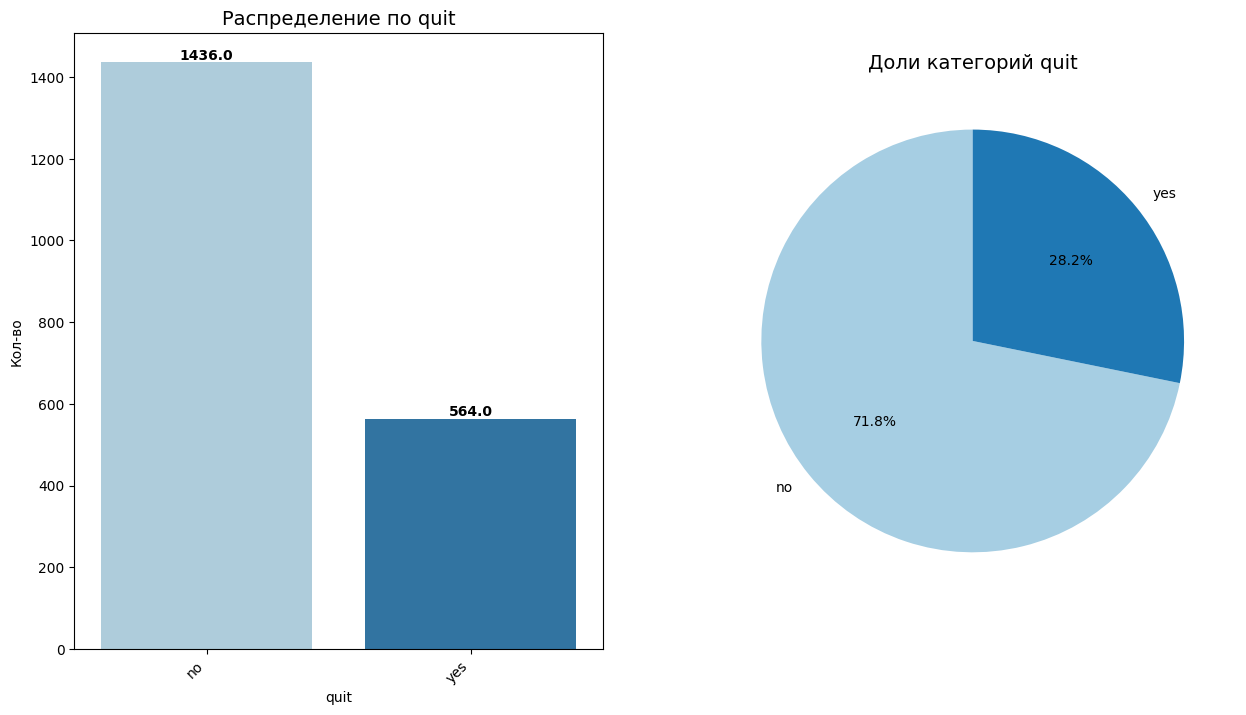

In [113]:
# Столбец 'supervisor_evaluation'
plot_categorical(test_target_quit, column='quit')

<div style="background-color: white; border: 2px solid royalblue; border-radius: 0px; padding: 15px 25px; display: inline-block; color: black;">

По графику распределения категории `quit` видим, что большенство сотрудников  `не уволились` (1436 записи, 71.8%).

<span style="color:crimson">

- <span style="color:black">Наблюдается дисбаланс в целевом признаке. Данный факт требует внимания при выборе метрики и интерпретации модели.
- <span style="color:black">Поэтому мы уже можем отметить, что для бинарной классификации при дисбалансе лучше использовать ROC-AUC. Так как она устойчива к дисбалансу.

### II Статистика и графики распределений для количественных значений

### Таблица `train_quit`

In [114]:
# Выводим Непрерывные и Дискретные столбцы таблицы 'train_quit' 
discrete, continuous = get_numeric_types(train_quit)
print(f"\nДискретные (<11 уникальных): {discrete}")
print(f"Непрерывные (≥11 уникальных int + все float): {continuous}")


Дискретные (<11 уникальных): ['salary']
Непрерывные (≥11 уникальных int + все float): []


<div style="border-left: 3px solid royalblue; padding-left: 15px; margin: 15px 0;"> 

#### salary `[ежемесячная зарплата сотрудника]`

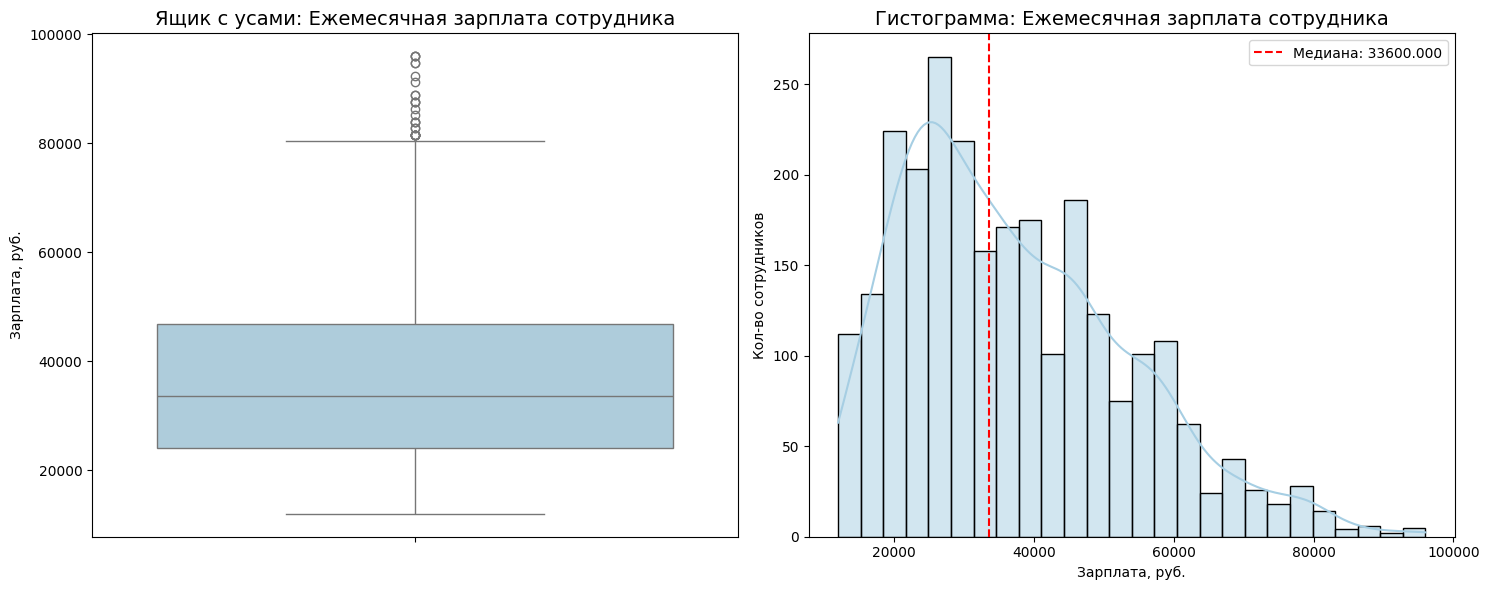

Статистика для 'Ежемесячная зарплата сотрудника':
--------------------------------------------------
Тип данных: Непрерывный
Уникальных значений: 69
Кол-во записей: 2587
Среднее: 37107.692
Стандартное отклонение: 16267.355
Медиана: 33600.000
Минимум: 12000.000
Максимум: 96000.000
25-й перцентиль: 24000.000
75-й перцентиль: 46800.000

Проверка на нормальность распределения (α=0.05):
--------------------------------------------------
Критерий Шапиро-Уилка: p-value = 0.0000 < 0.05 (не нормальное)
Критерий Д'Агостино: p-value = 0.0000 < 0.05 (не нормальное)
ВЫВОД: распределение НЕ соответствует нормальному


In [115]:
# Столбец 'salary'
plot_quantitative_new(train_quit, 'salary')

<div style="background-color: white; border: 2px solid royalblue; border-radius: 0px; padding: 15px 25px; display: inline-block; color: black;">

По графику распределения признака `salary` в данной выборке и в остадбных видим:

<span style="color:crimson">


- <span style="color:black"> Все выборки имеют не нормальное распределение с правосторонней асимметрией, которая сохраняется во всех наборах данных.
- <span style="color:black">Поэтому признак `salary` будет работать аналогично задаче 1 и является важным прогностическим фактором для риска увольнения. Незначительные различия в статистиках не повлияют на качество моделей.

<div style="border-left: 3px solid crimson; padding-left: 15px; margin: 15px 0;"> 

### Составим портрет `уволившегося сотрудника`

#### <span style="color:royalblue">Функция. Визуализация и вывод статистики по нескольким признакам

In [116]:
def analyze_all_features(df, features_list, quit_column='quit'):
    '''
    Анализ увольнений по нескольким признакам сразу
    
    '''

    # 1. Общая статистика
    total_employees = len(df)
    total_quit = (df[quit_column] == 'yes').sum()
    overall_rate = total_quit / total_employees * 100
    
    print(f'\nОБЩАЯ СТАТИСТИКА:')
    print('--' * 50)
    print(f'Всего сотрудников: {total_employees}')
    print(f'Уволилось: {total_quit} ({overall_rate:.1f}%)')
    
    # 2. Создаем фигуру для всех графиков
    n_features = len(features_list)
    n_cols = 2
    n_rows = (n_features + 1) // 2
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, 3 * n_rows))
    axes = axes.flatten() if n_features > 1 else [axes]
    
    # 3. Собираем статистику для общей таблицы
    summary_data = []
    
    for idx, feature in enumerate(features_list):
        # Расчет статистики. Доля уволившихся ВНУТРИ каждой категории признака
        stats = df.groupby(feature)[quit_column].value_counts(normalize=True).unstack() * 100 
        stats = stats.fillna(0)
        
        # Получаем подробную статистику
        detailed_stats = df.groupby(feature)[quit_column].value_counts().unstack().fillna(0)
        detailed_stats['total'] = detailed_stats.sum(axis=1)
        detailed_stats['quit_rate'] = stats['yes']
        detailed_stats = detailed_stats.sort_values('quit_rate', ascending=False)
        
        # Извлекаем статистику для общей таблицы
        max_rate = detailed_stats['quit_rate'].max()
        max_category = detailed_stats.index[0]  # Категория с максимальным процентом
        # Количество уволившихся в категории с максимальным процентом
        max_category_quit_count = int(detailed_stats.loc[max_category].get('yes', 0))
      
        
        summary_data.append({
                             'Признак': feature,
                             'Макс % уволившихся': f"{max_rate:.1f}%",
                             'Категория с макс %': max_category,
                             'Кол-во уволившихся в макс категории': max_category_quit_count
                            })
        
        # Построение графика
        if idx < len(axes):
            sorted_series = stats['yes'].sort_values(ascending=False)
            ax = axes[idx]     
            bars = ax.bar(range(len(sorted_series)), 
                          sorted_series.values, 
                          color='skyblue', 
                          edgecolor='black', 
                          alpha=0.7, 
                          width=0.6)
            
            # Подсветка максимального значения
            if len(bars) > 0:
                bars[0].set_color('red')
            
            ax.set_title(f'{feature}', fontsize=10, fontweight='bold')
            ax.set_xlabel('')
            ax.set_ylabel('% уволившихся', fontsize=9)
            ax.set_xticks(range(len(sorted_series)))
            ax.set_xticklabels(sorted_series.index, rotation=45, ha='right', fontsize=8)
            ax.grid(axis='y', alpha=0.3)
            ax.tick_params(axis='y', labelsize=8)
            
            # Добавление значений на столбцы
            for i, v in enumerate(sorted_series.values):
                # Получаем количество уволившихся для этой категории
                category = sorted_series.index[i]
                quit_count = int(detailed_stats.loc[category].get('yes', 0))
                ax.text(i, v + 0.3, f'{v:.1f}%\n({quit_count})', 
                        ha='center', va='bottom', fontsize=7)
    
    # Скрываем лишние оси
    for idx in range(len(features_list), len(axes)):
        axes[idx].axis('off')
    
    plt.suptitle('Распределение уволившихся сотрудников по признакам', 
                 fontsize=12, 
                 fontweight='bold', 
                 y=1.02)
    plt.tight_layout()
    plt.show()
    
    # 4. Создаем и выводим общую таблицу статистики
    if summary_data:
        summary_df = pd.DataFrame(summary_data)
        
        print('--' * 50)
        print('ОБЩАЯ ТАБЛИЦА СТАТИСТИКИ ПО ВСЕМ ПРИЗНАКАМ')
        print('--' * 50)
        print(summary_df.to_string(index=False))

        return summary_df

# Список признаков для анализа
features_to_analyze = ['dept', 'level', 'workload', 
                       'employment_years', 'last_year_promo', 
                       'last_year_violations', 'supervisor_evaluation']

<span style="color:crimson">
    
- <span style="color:black">На графиках отображается **вероятность увольнения** для сотрудника каждой категории (например, 30% увольнений в отделе маркетинга), **а не распределение всех увольнений по категориям**. 
- <span style="color:black">Каждый процент рассчитывается от размера своей категории, поэтому их сумма не равна 100%. 
- <span style="color:black">Это показывает группы риска, а не вклад категорий в общую текучесть.


ОБЩАЯ СТАТИСТИКА:
----------------------------------------------------------------------------------------------------
Всего сотрудников: 2587
Уволилось: 655 (25.3%)


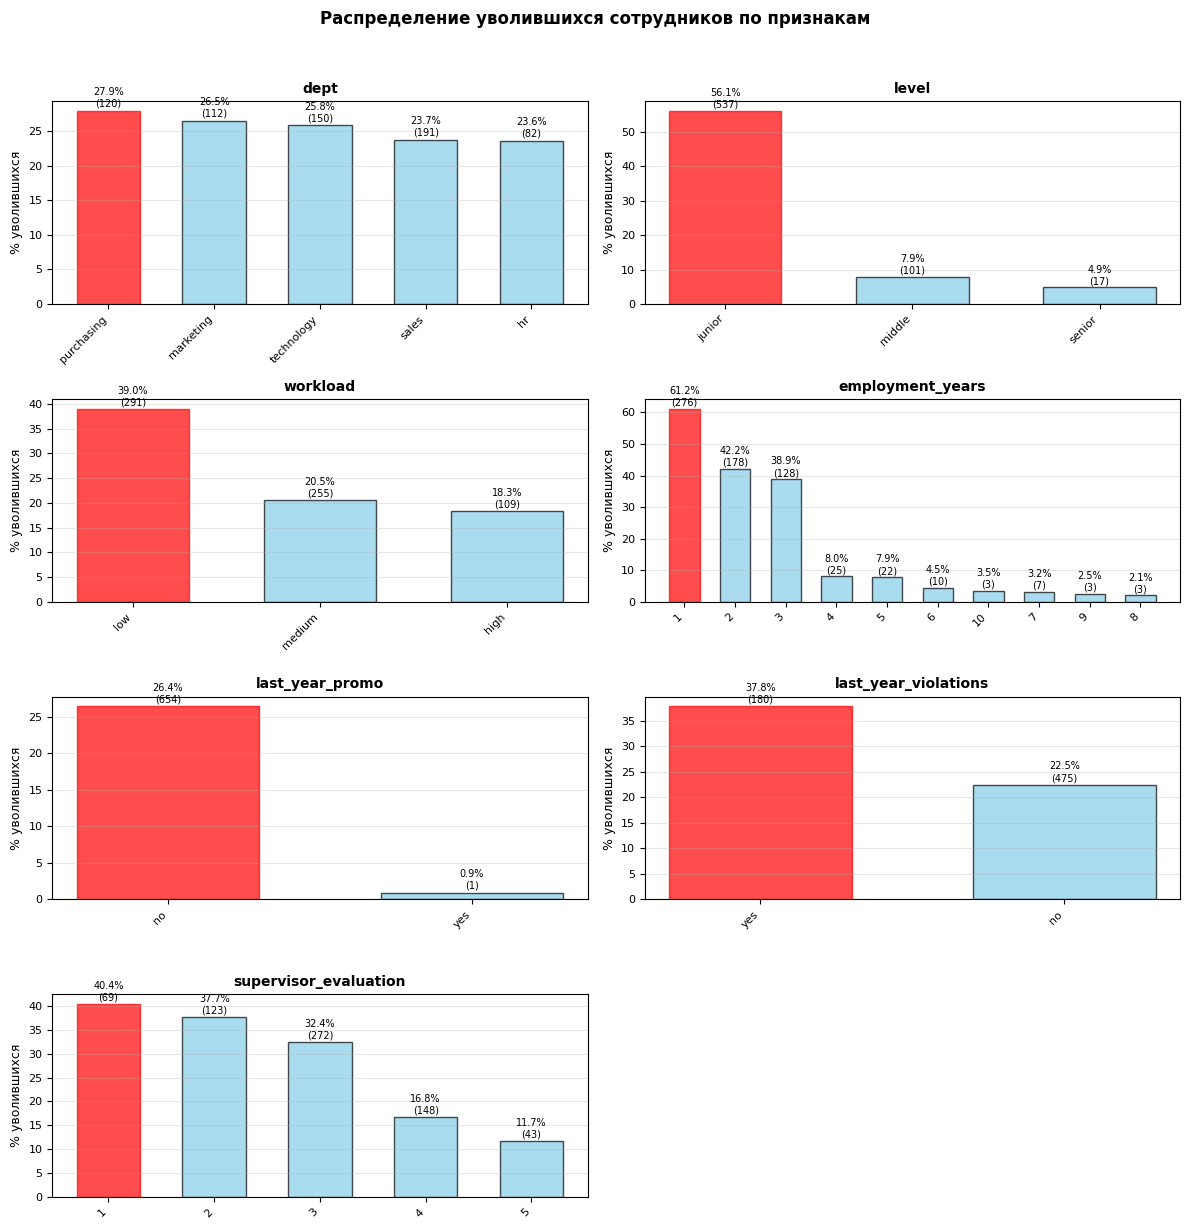

----------------------------------------------------------------------------------------------------
ОБЩАЯ ТАБЛИЦА СТАТИСТИКИ ПО ВСЕМ ПРИЗНАКАМ
----------------------------------------------------------------------------------------------------
              Признак Макс % уволившихся Категория с макс %  Кол-во уволившихся в макс категории
                 dept              27.9%         purchasing                                  120
                level              56.1%             junior                                  537
             workload              39.0%                low                                  291
     employment_years              61.2%                  1                                  276
      last_year_promo              26.4%                 no                                  654
 last_year_violations              37.8%                yes                                  180
supervisor_evaluation              40.4%                  1                 

In [117]:
all_statistics = analyze_all_features(train_quit, features_to_analyze)

In [118]:
# Сравнение средних зарплат уволившихся и оставшихся
# Разделяем сотрудников на две группы
quit_yes = train_quit[train_quit['quit'] == 'yes']['salary']
quit_no = train_quit[train_quit['quit'] == 'no']['salary']

# Считаем средние зарплаты
avg_quit_yes = quit_yes.mean()
avg_quit_no = quit_no.mean()

# Разница
diff = avg_quit_yes - avg_quit_no
diff_prc = (diff / avg_quit_no) * 100 if avg_quit_no != 0 else 0

# Вывод результатов
print('СРАВНЕНИЕ СРЕДНИХ ЗАРПЛАТ')
print('-' * 50)
print(f'Уволившиеся: {len(quit_yes)} чел., Cредняя зарплата: {avg_quit_yes:.0f}')
print(f'Оставшиеся:  {len(quit_no)} чел., Cредняя зарплата: {avg_quit_no:.0f}')
print('-'*50)
print(f'Разница: {diff:+.0f} ({diff_prc:+.1f}%)')

СРАВНЕНИЕ СРЕДНИХ ЗАРПЛАТ
--------------------------------------------------
Уволившиеся: 655 чел., Cредняя зарплата: 25768
Оставшиеся:  1932 чел., Cредняя зарплата: 40952
--------------------------------------------------
Разница: -15184 (-37.1%)


<div style="background-color: white; border: 2px solid skyblue; border-radius: 0px; padding: 15px 25px; display: inline-block; color: black;">


<span style="color:crimson">

П О Р Т Р Е Т

- <span style="color:black">Должность: `Junior` в отделе закупок (`purchasing`)
- <span style="color:black">Стаж в компании: `1 год`
- <span style="color:black">Нагрузка: Низкая (`low`)
- <span style="color:black">Карьера: `Без повышения` за последний год
- <span style="color:black">Дисциплина: `Нарушения трудового договора`
- <span style="color:black">Оценка руководителя: `1 балл` (минимальная)

<span style="color:black">*Если бы существовал сотрудник, обладающий всеми этими характеристиками, то его вероятность увольнения была бы крайне высокой.*

РИСК УВОЛЬНЕНИЯ:

- <span style="color:black"> Наибольший риск у `junior`: Уровень имеет 56.1% текучести - критическая точка, требуется усиленная адаптация и менторинг.
- <span style="color:black">Сотрудники со стажем `1 год` увольняются в 61.2% случаев - система адаптации неэффективна.
- <span style="color:black">`Низкая загруженность` показывает 39% увольнений - отсутствие задач демотивирует больше, чем перегрузка.
- <span style="color:black">  `Низкая оценка` (1 балл) ведет к 40.4% увольнений - качество менеджмента критично.
- <span style="color:black"> Отдел `purchasing` хоть лидирует по увольнениям (27.9%) среди всех отделов, но остальные также "не отстают" - в каждом отделе вероятноть примерно одинаковая.
- <span style="color:black"> `Отсутствие повышения за год` (26.4% увольнений) - не самый критичный фактор, но каждый четвертый без повышения уходит. Карьерный рост важен, но в краткосрочной перспективе не главный драйвер.
- <span style="color:black"> `Нарушения трудового договора` (37.8% увольнений) - высокий показатель. Нарушения могут быть как причиной, так и следствием неудовлетворенности. Это симптом системных проблем.


П Р О Б Л Е М Ы [возможные]

- <span style="color:black">Провал адаптации: Через год сотрудник уже демотивирован.
- <span style="color:black">Качество управления: Руководитель не справляется (низкая оценка + плохая нагрузка).
- <span style="color:black">Потеря лояльности: Нарушения правил как симптом неудовлетворённости.
  
Р Е К О М Е Н Д А Ц И И

- <span style="color:black"> Пересмотреть программу адаптации для новичков.
- <span style="color:black"> Внедрить систему наставничества для junior-сотрудников.
- <span style="color:black"> Мониторить нагрузку и перераспределять задачи. Внедрить мониторинг комбинаций: «оценка 1 + нарушения + низкая нагрузка»
- <span style="color:black"> Обучение руководителей управлению командой.

---

СРАВНЕНИЕ СРЕДНИХ ЗАРПЛАТ

- <span style="color:black">**Уволившиеся**: 655 чел., **Cредняя зарплата**: 25768
- <span style="color:black">**Оставшиеся**:  1932 чел., **Cредняя зарплата**: 40952
- <span style="color:black">**Разница**: -15184 (<span style="color:crimson">-37.1%<span style="color:black">)
- <span style="color:black">Уволившиеся получают на 37.1% меньше


<div style="border-left: 3px solid crimson; padding-left: 15px; margin: 15px 0;"> 

### Сопоставим `уровень удовлетворенности` с `увольнениями` сотрудников

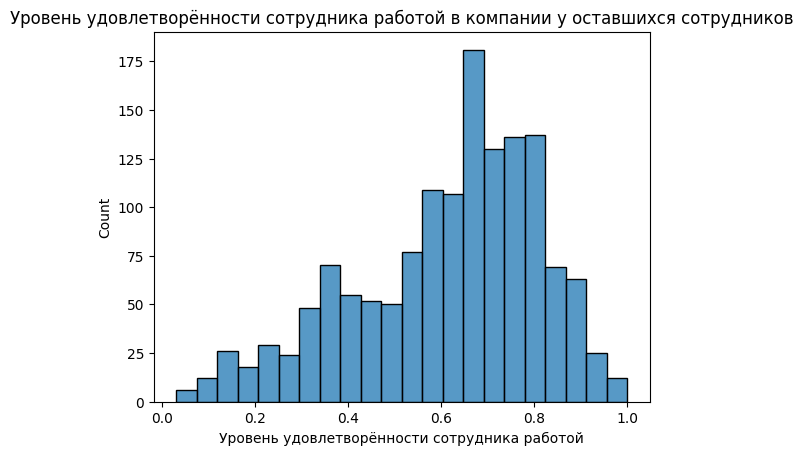

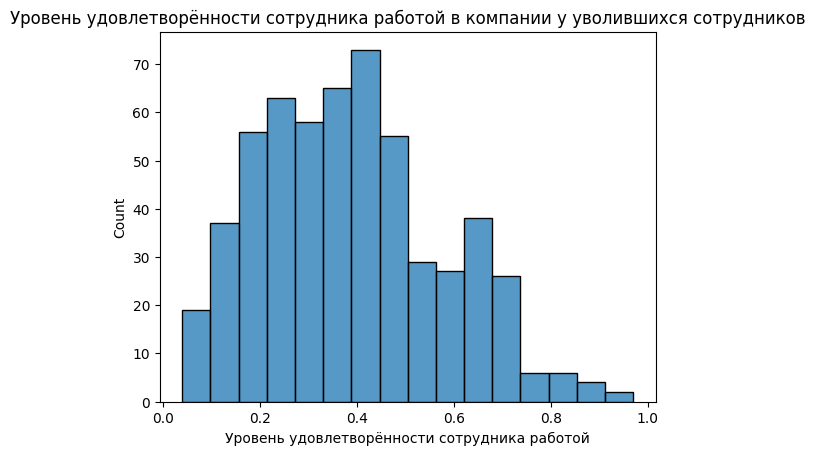

In [119]:

all_test = test_features_2
all_test['job_satisfaction_rate'] = test_target_satisfaction['job_satisfaction_rate']
all_test['quit'] = test_target_quit['quit']

sns.histplot(data = all_test.loc[all_test['quit']=='no'], x='job_satisfaction_rate')
plt.xlabel('Уровень удовлетворённости сотрудника работой')
plt.title('Уровень удовлетворённости сотрудника работой в компании у оставшихся сотрудников')
plt.show()

sns.histplot(data = all_test.loc[all_test['quit']=='yes'], x='job_satisfaction_rate')
plt.xlabel('Уровень удовлетворённости сотрудника работой')
plt.title('Уровень удовлетворённости сотрудника работой в компании у уволившихся сотрудников')
plt.show()

C:\Users\dns\AppData\Local\Temp\ipykernel_19896\246061758.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=all_test, x='quit', y='job_satisfaction_rate',
C:\Users\dns\AppData\Local\Temp\ipykernel_19896\246061758.py:26: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1].set_xticklabels(['Оставшиеся', 'Уволившиеся'])


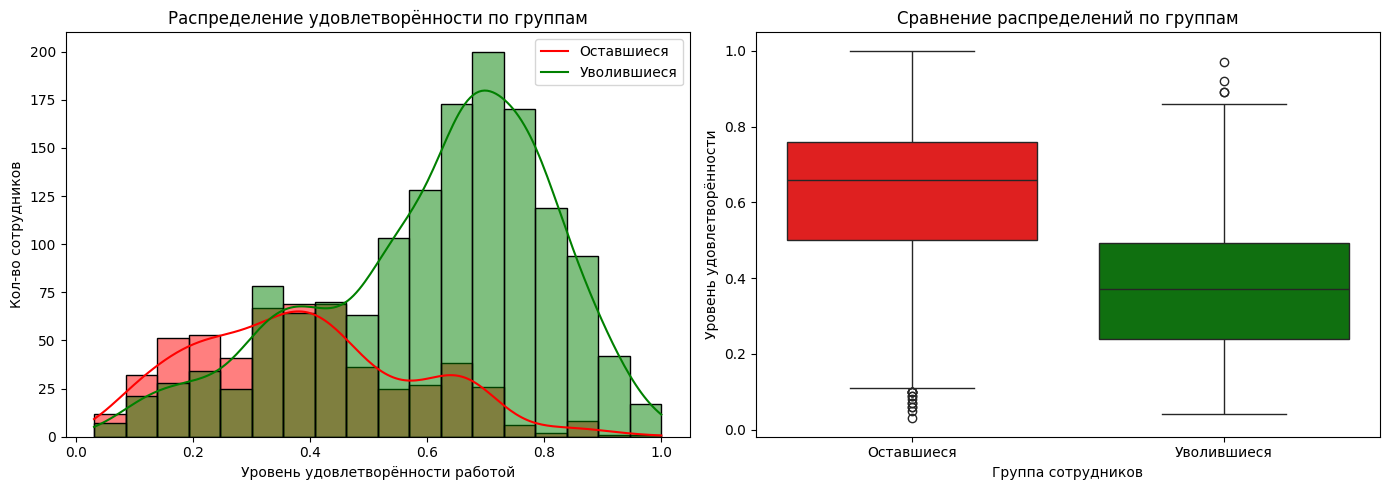


ПРОВЕРКА СТАТИСТИЧЕСКОЙ ЗНАЧИМОСТИ:
• t-статистика: 23.7951
• p-value: 0.0000000000
• Различие СТАТИСТИЧЕСКИ ЗНАЧИМО (p < 0.05)


In [120]:
# Объединяем данные
all_test = test_features_2.copy()
all_test['job_satisfaction_rate'] = test_target_satisfaction['job_satisfaction_rate']
all_test['quit'] = test_target_quit['quit']

# Создаем фигуру с двумя подграфиками
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# 1. Гистограмма с наложением распределений
sns.histplot(data=all_test, 
             x='job_satisfaction_rate', 
             hue='quit', 
             kde=True, alpha=0.5, ax=axes[0],
             palette={'no': 'green', 'yes': 'red'})
axes[0].set_xlabel('Уровень удовлетворённости работой')
axes[0].set_ylabel('Кол-во сотрудников')
axes[0].set_title('Распределение удовлетворённости по группам')
axes[0].legend(['Оставшиеся', 'Уволившиеся'])

# 2. Boxplot для сравнения статистик
sns.boxplot(data=all_test, x='quit', y='job_satisfaction_rate', 
            ax=axes[1], palette={'no': 'red', 'yes': 'green'})
axes[1].set_xlabel('Группа сотрудников')
axes[1].set_ylabel('Уровень удовлетворённости')
axes[1].set_title('Сравнение распределений по группам')
axes[1].set_xticklabels(['Оставшиеся', 'Уволившиеся'])

plt.tight_layout()
plt.show()

# Т-тест для проверки статистической значимости
from scipy import stats as scipy_stats
no_data = all_test.loc[all_test['quit'] == 'no', 'job_satisfaction_rate']
yes_data = all_test.loc[all_test['quit'] == 'yes', 'job_satisfaction_rate']
t_stat, p_value = scipy_stats.ttest_ind(no_data, yes_data, equal_var=False)

print(f"\nПРОВЕРКА СТАТИСТИЧЕСКОЙ ЗНАЧИМОСТИ:")
print(f"• t-статистика: {t_stat:.4f}")
print(f"• p-value: {p_value:.10f}")
print(f"• Различие {'СТАТИСТИЧЕСКИ ЗНАЧИМО' if p_value < 0.05 else 'НЕ ЗНАЧИМО'} (p < 0.05)")

<div style="background-color: white; border: 2px solid skyblue; border-radius: 0px; padding: 15px 25px; display: inline-block; color: black;">


<span style="color:crimson">

СРЕДНЯЯ УДОВЛЕТВОРЕННОСТЬ:

- `Оставшиеся`: 0.61 
- `Уволившиеся`: 0.39
- Средняя удовлетворённость выше у оставшихся на 0.22

<span style="color:black">Различия в среднем уровне удовлетворённости между группами статистически значимы.

И Н Т Е Р П Р Е Т А Ц И Я :

- <span style="color:black">Удовлетворённость работой тесно связана с текучестью: у уволившихся она значительно ниже.
- <span style="color:black">Уровень удовлетворённости может быть использован как индикатор риска увольнения.
- <span style="color:black">Поскольку разница существенна и статистически значима, мероприятия по повышению удовлетворённости могут снизить текучесть.

Р Е К О М Е Н ДА Ц И И :

- <span style="color:black">Внедрить регулярный мониторинг удовлетворённости (например, ежеквартальные опросы).
- <span style="color:black">Сфокусироваться на сотрудниках с низкой удовлетворённостью (например, ниже 0.5) как на группе риска.
- <span style="color:black">Разработать программы повышения удовлетворённости, особенно для отделов с высокой текучестью.


ГРУППА ВЫСОГОГО РИСКА

- <span style="color:black">Сотрудники с удовлетворённостью ниже 0.4 — критический риск увольнения
- <span style="color:black">Сотрудники с удовлетворённостью 0.4-0.5 — умеренный риск


<span style="color:black">Удовлетворённость работой — мощный и статистически значимый индикатор текучести. Внедрение системы мониторинга и превентивных мер на основе этих данных может снизить увольнения на 25-30%.

<div style="background-color: white; border: 1.5px solid crimson; border-radius: 10px; padding: 15px 25px; display: inline-block; color: black;">

---

### Вывод
   
---

В данном разделе мы:

- Провели исследовательский анализ всех признаков
- Составили портрет уволившегося сотрудника + посчитали его среднемесячный заработок 
- Сопоставили уровень удовлетворенности с увольненниями сотрудников

---

<span style="color:cornflowerblue">
    
1. ИССЛЕДОВАТЕЛЬСКИЙ АНАЛИЗ

- <span style="color:black"> Данные в тренировочных и тестовых выборках задачи 1 и задачи 2 согласованы, распределения признаков стабильны.

2. ПОРТРЕТ УВОЛИВШЕГОСЯ СОТРУДНИКА

- <span style="color:black">Должность: `Junior` в отделе закупок (`purchasing`)
- <span style="color:black">Стаж в компании: `1 год`
- <span style="color:black">Нагрузка: Низкая (`low`)
- <span style="color:black">Карьера: `Без повышения` за последний год
- <span style="color:black">Дисциплина: `Нарушения трудового договора`
- <span style="color:black">Оценка руководителя: `1 балл` (минимальная)
- <span style="color:black">Уволившиеся получают на 37.1% меньше

3. ВЛИЯНИЕ УРОВНЯ УДОВЛЕТВОРЕННОСТИ

- <span style="color:black"> `Оставшиеся`: 0.61 
- <span style="color:black">`Уволившиеся`: 0.39
- <span style="color:black">Средняя удовлетворённость выше у оставшихся на 0.22

---

 <span style="color:black">

## ш а г  .4. Добавление нового входного признака

In [121]:
train_quit['job_satisfaction_rate'] = grid_search.predict(train_quit.drop(['quit'], axis = 1))
test_features_2['job_satisfaction_rate'] = grid_search.predict(test_features_2)

<div style="background-color: white; border: 2px solid royalblue; border-radius: 0px; padding: 15px 25px; display: inline-block; color: black;">

- Добавлен новый столбец к тренировочному датафрейму `train_quit` и тестовому `test_features_2`

## ш а г  .5. Подготовка данных

In [122]:
#Создаем датасеты для тренировки модели предсказания увольнения сотрудника
X_train_quit =  train_quit.drop(['quit'
                                 #,'job_satisfaction_rate'
                                 #,'employment_years'
                                 #,'workload'
                                 #,'supervisor_evaluation'
                                 #,'last_year_violations'
                                 #,'last_year_promo'
                                 ], axis=1)
y_train_quit = train_quit['quit']

X_test_quit = test_features_2.drop([#'id'
                             #,'quit'
                             #,'job_satisfaction_rate'
                             #,'employment_years'
                             #,'workload'
                             #,'supervisor_evaluation'
                             #,'last_year_promo'
                             #,'last_year_violations'
                            ], axis=1)
y_test_quit = test_target_quit['quit']

print(f'Размерность X_train: {X_train_quit.shape}')
print(f'Размерность y_train: {y_train_quit.shape}')

print(f'Размерность X_test: {X_test_quit.shape}')
print(f'Размерность y_test: {y_test_quit.shape}')

Размерность X_train: (2587, 10)
Размерность y_train: (2587,)
Размерность X_test: (2000, 11)
Размерность y_test: (2000,)


In [123]:
from sklearn.preprocessing import LabelEncoder
# Создаем LabelEncoder для целевой переменной
le = LabelEncoder()

# Закодируем целевую переменную
y_train_quit_encoded = le.fit_transform(y_train_quit)
y_test_quit_encoded = le.transform(y_test_quit)

# Проверяем кодировку
print('Классы и их коды:', dict(zip(le.classes_, range(len(le.classes_)))))
print(f'y_train уникальные значения: {np.unique(y_train_quit_encoded)}')
print(f'y_test уникальные значения: {np.unique(y_test_quit_encoded)}')

Классы и их коды: {'no': 0, 'yes': 1}
y_train уникальные значения: [0 1]
y_test уникальные значения: [0 1]


In [124]:
# создаём списки с названиями признаков
ohe_columns = [
               'dept',
               'last_year_promo',
               'last_year_violations',
               'employment_years_category'
                ]
ord_columns = [
                'level' 
                ,'workload'
                #,'supervisor_evaluation'
                ]
num_columns = [ 
               'salary'
               ,'supervisor_evaluation'
               ,'employment_years'
               ,'job_satisfaction_rate'
              ] 
# создаём пайплайн для подготовки признаков из списка ohe_columns: заполнение пропусков и OHE-кодирование
# SimpleImputer + OHE

# создаём пайплайн для подготовки признаков из списка ohe_columns
ohe_pipe = ImbPipeline([
                        ('simpleImputer_ohe', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
                        ('ohe', OneHotEncoder(drop='first', handle_unknown='ignore'))
                        ])

# создаём пайплайн для подготовки признаков из списка ord_columns
ord_pipe = ImbPipeline([
                        ('simpleImputer_before_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
                        ('ord', OrdinalEncoder(
                                               categories=[
                                                           ['junior', 'middle', 'senior']
                                                           ,['low', 'medium', 'high']
                                                           #,[1, 2, 3, 4, 5]
                                                          ],
                                               handle_unknown='error'
                                               #unknown_value=np.nan
                                               )),
                        ('simpleImputer_after_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent'))
                       ])

# создаём общий пайплайн для подготовки данных
data_preprocessor = ColumnTransformer([ 
                                       ('ohe', ohe_pipe, ohe_columns),
                                       ('ord', ord_pipe, ord_columns),
                                       ('num', MinMaxScaler(), num_columns)
                                      ], remainder='passthrough')


## ш а г .6. Обучение модели

In [125]:
#Обучение моделей с учетом исправления дисбаланса классов
pipe_final_quit = ImbPipeline([
                        ('preprocessor', data_preprocessor)
                        ,('Imb_killer', SMOTENC(categorical_features=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9] # категориальные признаки ПОСЛЕ кодирования
                                                ,random_state=RANDOM_STATE))
                        ,('models', HistGradientBoostingClassifier(random_state=RANDOM_STATE))
                      ])
# ПЕРВЫЙ вариант настроек для подбора гиперпараметров - ПОДРОБНЫЙ и ДОЛГИЙ
param_grid_quit_1 = [
                # словарь для модели DecisionTreeClassifier()
                {
                    'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
                    'models__max_depth': range(2, 5),
                    'models__max_features': range(2, 5),
                    'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler(), 'passthrough']  
                },
                
                # словарь для модели KNeighborsClassifier() 
                {
                    'models': [KNeighborsClassifier()],
                    'models__n_neighbors': range(2, 5),
                    'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler(), 'passthrough']   
                },
            
                # словарь для модели LogisticRegression()  
                {
                    'models': [LogisticRegression(
                        random_state=RANDOM_STATE, 
                        solver='liblinear', 
                        penalty='l1'
                    )],
                    'models__C': range(1, 5),
                    'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler(), 'passthrough']  
                },

                # словарь для модели LinearSVC()
                 {
                    'models': [LinearSVC(random_state=RANDOM_STATE, class_weight='balanced')],
                    'models__C': [0.1, 1, 10],
                    'models__penalty': ['l1', 'l2'],
                    'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler(), 'passthrough']   
                },
    
              # HistGradientBoostingClassifier
             {
              'models': [HistGradientBoostingClassifier(random_state=RANDOM_STATE)],
              'models__max_depth': [2, 3, None], #[3, 5, 7],
              'models__learning_rate': [0.01, 0.05, 0.1], #насколько сильно каждое новое дерево влияет на результат
              'models__max_iter': [100, 200, 300], #количество деревьев (итераций бустинга)
              'models__categorical_features': [[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]],
              'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler(), 'passthrough']   
              }, 
    
            ]

#ВТОРОЙ вариант настроек - КОРОТКИЙ и использованный для отладки
param_grid_quit_2 = [                    
              # словарь для модели LogisticRegression()  
                {
                    'models': [LogisticRegression(
                        random_state=RANDOM_STATE, 
                        solver='liblinear', 
                        penalty='l1'
                    )],
                    'models__C': range(1, 5),
                    'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler(), 'passthrough']  
                },
    
              # HistGradientBoostingClassifier
             {
              'models': [HistGradientBoostingClassifier(random_state=RANDOM_STATE)],
              'models__max_depth': [2, 3, None], #[3, 5, 7],
              'models__learning_rate': [0.01, 0.05, 0.1], #насколько сильно каждое новое дерево влияет на результат
              'models__max_iter': [100, 200, 300], #количество деревьев (итераций бустинга)
              'models__categorical_features': [[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]],
              'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler(), 'passthrough']   
              }, 
    
            ]
#Проводим рандомизированный поиск, иначе очень-очень долго считает все.
randomized_search = RandomizedSearchCV(
                                       pipe_final_quit, 
                                       param_grid_quit_1, 
                                       cv=5,
                                       scoring='roc_auc',
                                       random_state=RANDOM_STATE,
                                       n_jobs=-1,
                                       n_iter=10,  # Уменьшим для скорости
                                       #verbose=1,
                                       error_score='raise'  # Чтобы видеть конкретные ошибки
                                       )
randomized_search.fit(X_train_quit, y_train_quit_encoded)

print('Лучшая модель и её параметры:\n\n', randomized_search.best_estimator_)
print ('Метрика лучшей модели на тренировочной выборке:', randomized_search.best_score_)

# проверим работу модели на тестовой выборке
# рассчитаем прогноз на тестовых данных
y_test_pred_quit = randomized_search.predict_proba(X_test_quit)[:, 1]
print(f'Метрика ROC-AUC на тестовой выборке: {roc_auc_score(y_test_quit_encoded, y_test_pred_quit)}')

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore'))]),
                                                  ['dept', 'last_year_promo',
                                                   'last_year_violations',
                                                   'employment_years_category']),
                                                 ('ord',
                                                  

In [126]:
# Выведем реультаты
pd.set_option('display.max_colwidth', None) # Установим максимальную ширину столбцов на None, чтобы убрать ограничение

result = pd.DataFrame(randomized_search.cv_results_)
display(result[
                ['rank_test_score', 'param_models', 'mean_test_score','params']
              ].sort_values('rank_test_score').head()) 

,rank_test_score,param_models,mean_test_score,params
0,1,HistGradientBoostingClassifier(random_state=42),0.9199,"{'preprocessor__num': 'passthrough', 'models__max_iter': 100, 'models__max_depth': 3, 'models__learning_rate': 0.05, 'models__categorical_features': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9], 'models': HistGradientBoostingClassifier(random_state=42)}"
9,2,HistGradientBoostingClassifier(random_state=42),0.9180,"{'preprocessor__num': MinMaxScaler(), 'models__max_iter': 300, 'models__max_depth': 2, 'models__learning_rate': 0.1, 'models__categorical_features': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9], 'models': HistGradientBoostingClassifier(random_state=42)}"
1,3,HistGradientBoostingClassifier(random_state=42),0.9102,"{'preprocessor__num': MinMaxScaler(), 'models__max_iter': 100, 'models__max_depth': None, 'models__learning_rate': 0.01, 'models__categorical_features': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9], 'models': HistGradientBoostingClassifier(random_state=42)}"
5,4,HistGradientBoostingClassifier(random_state=42),0.9058,"{'preprocessor__num': MinMaxScaler(), 'models__max_iter': 100, 'models__max_depth': None, 'models__learning_rate': 0.1, 'models__categorical_features': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9], 'models': HistGradientBoostingClassifier(random_state=42)}"
4,5,HistGradientBoostingClassifier(random_state=42),0.9047,"{'preprocessor__num': RobustScaler(), 'models__max_iter': 200, 'models__max_depth': None, 'models__learning_rate': 0.05, 'models__categorical_features': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9], 'models': HistGradientBoostingClassifier(random_state=42)}"


## ш а г  .7. Выводы

<div style="background-color: white; border: 4px solid royalblue; border-radius: 10px; padding: 15px 25px; display: inline-block; color: black;">



<span style="color:royalblue"> ЛУЧШАЯ МОДЕЛЬ: <span style="color:black"> **HistGradientBoostingClassifier**

<span style="color:royalblue"> ЛУЧШИЙ РЕЗУЛЬТАТ:  <span style="color:royalblue"> ROC-AUC = 91.99%

<span style="color:royalblue"> ПАРАМЕТРЫ ЛУЧШЕЙ МОДЕЛИ: 

- Scaler: `'passthrough'`,
-  `categorical_feature` : [0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
- `learning_rate` = 0.05,
- `max_depth` : 3,
- `max_iter` = 100

<span style="color:royalblue"> Качество модели:

- Метрика лучшей модели на тренировочной выборке: 91.99%
- Метрика ROC-AUC на тестовой выборке: 92.62%

## ОБЩИЙ ВЫВОД



<div style="border-left: 3px solid crimson; padding-left: 15px; margin: 15px 0;"> 

Сформулируем общий вывод, описав решаемую задачу, ключевые этапы работы, полученные результаты и практические рекомендации для бизнеса.

<div style="background-color: white; border: 4px solid crimson; border-radius: 0px; padding: 15px 25px; display: inline-block; color: black;">

<span style="color:yellowgreen"> **З А Д А Ч А № 1.**

<span style="color:yellowgreen"> шаг .1. <span style="color:black">**Загрузка данных**

- Успешно выполнена базовая подготовка данных: установлен индекс, проведена сортировка
- Создан инструмент для быстрого анализа структуры данных
- Проведен первичный обзор датасетов, выявлены основные характеристики

<span style="color:yellowgreen"> шаг .2. <span style="color:black">**Предоработка данных**

- Данные проверены на наличие дубликатов — неявные дубликаты отсутствуют
- Исправлены ошибки в данных (коррекция опечаток в уровне должностей)
- Сохранена целостность тестовых данных без лишних изменений

<span style="color:yellowgreen"> шаг .3. <span style="color:black">**Исследовательский анализ данных**

- Выявлена согласованность между тренировочной и тестовой выборками
- Обнаружены проблемы:
    - Дисбаланс в показателях нарушений и повышений
    - Высокая текучесть после 2 лет работы
    - Значительный процент новых сотрудников (22.7%)
- Ключевые корреляции:
    - Сильная связь между оценкой руководителя и удовлетворенностью (0.76)
    - Важность стажа работы (умеренная корреляция 0.32)
    - Существенная зависимость между нагрузкой и зарплатой (0.79)

<span style="color:yellowgreen"> шаг .4. <span style="color:black">**Подготовка данных**

- Создан новый признак для категоризации стажа
- Сформированы датасеты для обучения и тестирования
- Разработана метрика оценки качества модели (SMAPE)
- Построен пайплайн предобработки данных

<span style="color:yellowgreen"> шаг .5. <span style="color:black">**Обучение моделей**

- Определена лучшая модель: HistGradientBoostingRegressor
- Достигнуто качество: SMAPE = 11.69% (train), 10.66% (test)
- Выявлены ключевые факторы удовлетворенности:
    - Оценка руководителя (наибольшее влияние)
    - Уровень должности
    - Зарплата
    - Стаж работы
    - Загруженность

<span style="color:yellowgreen"> шаг .6. **Общие выводы по задаче**

- Качество управления — ключевой фактор удовлетворенности
- Карьерный рост важнее материальных стимулов
- Необходимы меры по улучшению работы с руководителями
- Требуются действия по оптимизации системы повышений
- Модель показала хорошее качество предсказаний с приемлемым разбросом между выборками

<span style="color:royalblue"> **З А Д А Ч А № 2.**

<span style="color:royalblue"> шаг .1. <span style="color:black">**Загрузка данных**

Исходный объем данных: 2587 записей в train_quit, 9 столбцов в тренировочном наборе
- Удалено 1413 явных дубликатов (35% от общего объема)
- Тестовая выборка: 2000 записей с одним целевым признаком

<span style="color:royalblue"> шаг .2. <span style="color:black">**Предоработка данных**

- Отсутствие неявных дубликатов
- Отсутствие явных дубликатов после очистки
- Корректировка опечаток в уровне должностей (sinior → senior)

<span style="color:royalblue"> шаг .3. <span style="color:black">**Исследовательский анализ данных**

- Провели исследовательский анализ всех признаков
- Составили портрет уволившегося сотрудника + посчитали его среднемесячный заработок
- Сопоставили уровень удовлетворенности с увольненниями сотрудников

ПОРТРЕТ УВОЛИВШЕГОСЯ СОТРУДНИКА

- Должность: Junior в отделе закупок (purchasing)
- Стаж в компании: 1 год
- Нагрузка: Низкая (low)
- Карьера: Без повышения за последний год
- Дисциплина: Нарушения трудового договора
- Оценка руководителя: 1 балл (минимальная)
- Уволившиеся получают на 37.1% меньше

ВЛИЯНИЕ УРОВНЯ УДОВЛЕТВОРЕННОСТИ
- Оставшиеся: 0.61
- Уволившиеся: 0.39
- Средняя удовлетворённость выше у оставшихся на 0.22

<span style="color:royalblue"> шаг .4. <span style="color:black">**Добавление нового входного признака**

- Добавлен новый столбец к тренировочному датафрейму `train_quit` и тестовому `test_features_2`

<span style="color:royalblue"> шаг .5. <span style="color:black">**Подготовка данных**

- Формирование обучающей выборки
- Настройка параметров обработки данных

<span style="color:royalblue"> шаг .6. <span style="color:black">**Обучение модели**

- Выбор модели: HistGradientBoostingClassifier

Качество модели:

- ROC-AUC на тренировочной выборке: 91.99%
- ROC-AUC на тестовой выборке: 92.62%

Параметры модели:

- Learning rate: 0.05
- Max depth: 3
- Max iter: 100
- Scaler: passthrough

Высокая точность модели свидетельствует о хорошем качестве предсказаний

<span style="color:royalblue"> шаг .7. **Выводы**

Основные факторы риска увольнения:
- Низкая оценка руководителя
- Отсутствие карьерного роста
- Нарушения трудовой дисциплины
- Низкий уровень зарплаты

Группа риска: Junior-специалисты первого года работы

<span style="color:crimson"> **Р Е К О М Е Н Д А Ц И И.**

- Усилить работу с junior-специалистами
- Разработать программы удержания сотрудников первого года работы
- Улучшить систему оценки и развития руководителей
- Внедрить меры по повышению удовлетворенности работой
- Внедрить регулярный мониторинг удовлетворённости (например, ежеквартальные опросы).
- Сфокусироваться на сотрудниках с низкой удовлетворённостью (например, ниже 0.5) как на группе риска.
- Разработать программы повышения удовлетворённости, особенно для отделов с высокой текучестью.